# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [490]:
# DEPENDENCIES
# ------------
# GENERAL
import os
import ipdb
import time
from copy import deepcopy
import itertools

# handle warnings
import warnings
warnings.simplefilter('ignore')

# HANDLING FILES & STRINGS
import io
import pypandoc
import csv
import re
from bs4 import BeautifulSoup

# SCIENTIFIC COMPUTATION
# basics
# -------
import math
from numbers import Number
import numpy as np
import numpy.ma as ma
import pandas as pd
from pandas.api.types import CategoricalDtype

# special statistical libraries
# -----------------------------
import scipy.stats as stats
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.power import tt_ind_solve_power, zt_ind_solve_power, GofChisquarePower
import dython.nominal as dt
from dython._private import convert

# set up embeded r process
# --------------------------------
# import r modules & functions
import rpy2                                       # library for r embeded process in python
import rpy2.rlike.container as rlc                # modul to access r ordered dictionary
from rpy2 import robjects
import rpy2.robjects.packages as rpackages        # module for r package installations
from rpy2.robjects.packages import importr        # function to import r packages
from rpy2.robjects.vectors import StrVector       # r string vector class
from rpy2.robjects.vectors import IntVector       # r integer vector class
from rpy2.robjects.vectors import FloatVector     # r flaot vector class
from rpy2.robjects.vectors import FactorVector    # r factor vector class, equivalent to pd.Categorical
from rpy2.robjects.vectors import ListVector      # r list of different vectors
from rpy2.robjects.vectors import Matrix          # r matrix
from rpy2.robjects.vectors import DataFrame       # r dataframe class
from rpy2.robjects import pandas2ri               # module for dataframe conversion between pandas and r
pandas2ri.activate()
pandas2ri.deactivate()
from rpy2.rinterface import NA_Character          # r missing value for StrVector  
utils = importr('utils')                          # import utilities to install pacakges

from rpy2.robjects.functions import SignatureTranslatedFunction      # for use of argument mapping
STM = SignatureTranslatedFunction

# install r packages necessary to handle missing data
packnames = ('base', 'stats', 'mvnmle', 'BaylorEdPsych', 'mice', 'VIM')
names_to_install = [packname for packname in packnames if not rpackages.isinstalled(packname)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

# import necessary r packages
pandas2ri.activate()                        # activate dataframe conversion between pandas and r
base = rpackages.importr('base')            # import basic computation package
mvnmle = rpackages.importr('mvnmle')        # ML estimation for multivariate normal data with missing values
bep = rpackages.importr('BaylorEdPsych')    # R package including little's MCAR test (dependency: mvnmle package)
mc = rpackages.importr('mice')              # R package for multiple imputation by chained equations
vim = rpackages.importr('VIM')              # R packge for k-nearest neighbours imputation
statsr = rpackages.importr('stats')         # R package to use varimax rotation 

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# sklearn imports
# ---------------
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans


# graphical support
# -----------------
# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from ipywidgets import interact
%matplotlib inline

# progress bar
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm_nt
tqdm.pandas()

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# LOAD DATA
# ---------
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# MAP FEATURES SHORT NAMES to DETIALS
# -----------------------------------
def get_feature_details(path, short_names):
    '''
    Create mapping of short to long feature names and feature levels in form of nested dictionary
    Agrs:
        path: path to mark down file with feature names
        short_names: list of short names

    Returns:
        feature_details: mapping of short to long feature names and feature levels in form of nested dictionaries
                         ex: {<short_name>: {'long_name': <long_name>,
                                             'levels': {<level_code>:, <level_name>,...}}}
    '''
    # Convert markdown file feature to html format
    html = pypandoc.convert_file('Data_Dictionary.md', 'html5')
    
    # create html DOM 
    soup = BeautifulSoup(html, 'html.parser')
    
    # parse feature short names in html Dom
    # -------------------------------------
    # get h3 heading tags which contains short names
    excluded_h3_idx = 1   # number of h3 introduction headings without short names
    feat_short_names = soup('h3')[excluded_h3_idx:]
    
    # extract short names from id of h3 tags
    feat_short_names = [feat_short_name['id'].upper() for feat_short_name in feat_short_names]
    
    # parse concatenated short names and split them apart
    feat_short_names = [sub_name for feat_short_name in feat_short_names for sub_name in feat_short_name.split('-')]
    
    # raise exception if short names in markdown does not matched with passed ones
    assert set(feat_short_names) == set(short_names), \
    'Provided and parsed feature short names does not match!'

    # parse feature details in html DOM
    # ---------------------------------
    # get p tag which contains feature detials
    excluded_p_idx = 2    # number of p introduction tags without feature details
    feat_details = soup('p')[excluded_p_idx:]
    feat_details = [feat_detail.text for feat_detail in feat_details]

    # parse feature details and extract long name, codes and codes names
    ft_dtls = []
    # cycle over features
    for feat_detail in feat_details:
        # try to split feature detail record to form [long_name, code1, code_name2, etc...]
        # try to split detail by ' - ' following arbitrary number of non space characters, not greede, ending by ':'
        detail_split = re.split(r'- ([^ ]*?:)', feat_detail)
        
        # if code and code name can't be extracted from detail
        if len(detail_split) == 1: 
            # try to split feature detail record to form [long_name, missing_value_code, 'missing value']
            # try to split detail by ' - ' to from [long_name, code_info]
            detail_split = re.split(r' - ', feat_detail)
            
            # if detail can't be split extract only long name
            if not detail_split: 
                detail_split = feat_detail
                
            # if detail record can be split
            else:
                # extract long name, reconstruct code information 
                long_name, code_info = detail_split[0], ' - '.join(detail_split[1:])
                
                # if code information contains missing code
                if 'missing' in code_info:
                    # extract missing code as signed integer
                    nan_code = re.findall(r'\s+([-]?\d+)\s?', code_info)
                    
                    # if not only one code extracted raise exception
                    assert len(nan_code)==1, f'No or ambigious integer missing code for feature detail {feat_detail}' 
                    
                    # reconstruct detail record in form of [long_name, missing_value_code, 'missing value']
                    detail_split = [long_name, nan_code[0] + ': missing value']
        
        # if code and code name can be extracted from detail first time right
        else:
            # extract long name
            long_name = detail_split[0]
            
            # reconstruct detail record in form of [long_name, code1, code_name1, ...]
            detail_split = [code_name if code_name == long_name else code + code_name 
                       for code, code_name in zip(([''] + detail_split)[::2], detail_split[::2])]
        
        # append reconstruct detail record to feature details list
        ft_dtls.append(detail_split)

    # correct consolidated features details
    # -------------------------------------
    feat_details, ft_dtls = ft_dtls, []
    feat_long_name, feat_levels = str(), str()
    for feat_detail in feat_details:
        # if details refers to general info about consolidated features 
        # extract and temporarily store its long name prefix and and shared code information
        if 'each dimension' in feat_detail[0]:
            long_name_prefix = feat_detail[0].split(',')[0]
            shared_code_info = feat_detail[1:]
            
        # if details refer to consolidated features long names
        elif 'Dimension translations' in feat_detail[0]:
            # extract long name and prefix them with long name prefix
            long_names = [(long_name_prefix + ':' + long_name_info.split(':')[1]) for long_name_info in feat_detail[1:]]
            
            # reconstruct feature details record to form [feature1[long_name, code_info], ...]
            feat_details_temp = [[long_name] + shared_code_info for long_name in long_names] 
            
            # append corrected feature details records to details list
            ft_dtls.extend(feat_details_temp)
            
         # if detail refers not consolidated feature just append original record to details list
        else:
            ft_dtls.append(feat_detail)
    
    
    # create nested dictionary mapping feature short names to long names and codes to codes names
    # -------------------------------------------------------------------------------------------
    feat_details = ft_dtls
    feature_details = dict()    # initiate mapping dictionary
    code_info_idx = 1          # index between feature long name and codes information
    
    # cycle over feature short names and details
    for feat_short_name, feat_detail in zip(feat_short_names, feat_details):
            # extract long name
            long_name = feat_detail[0]
            
            # map codes to code names in form {code1: code_name1, ...}
            code_info = {code_info.split(': ')[0].strip():              # code
                         ':'.join(code_info.split(': ')[1:]).strip()     # code name
                         for code_info in feat_detail[code_info_idx:]}
            
            # add record to mapping dictionary
            feature_details[feat_short_name] = {'long_name': long_name, 'levels': code_info}

    return feature_details

# map features short names to details
feat_details = get_feature_details(path='Data_Dictionary.md', short_names=[*azdias.columns])

In [552]:
# EXPLORE DATA
# ------------
# Demographics data
display(azdias.head(n=3))
display(azdias.tail(n=3))

display(azdias.info(verbose=False))

# summary of non numeric features
[print('{:15}: {}'.format(idx, val.unique())) for idx, val in azdias.select_dtypes('O').iteritems()];

with pd.option_context('display.max_columns', None):
    display(azdias.describe())

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3  ...         NaN         NaN   
1                      4                 5  ...         2.0         3.0   
2                      3                 5  ...         3.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  

[3 rows x 85 columns]

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
891218        -1                     2          2            4.0   
891219        -1                     1          1            3.0   
891220        -1                     4          1            1.0   

        FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
891218                  2              4                 2               5   
891219                  1              5                 3               5   
891220                  4              2                 5               2   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
891218                      4                 3  ...         4.0         2.0   
891219                      5                 5  ...         1.0         4.0   
891220                      1                 5  ...         3.0         3.0   

        PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
891218         0.0         0.0          1.0       3.0       4.0     2.0   
891219         3.0         1.0          5.0       1.0       1.0     4.0   
891220         1.0         0.0          1.0       4.0       4.0     3.0   

        ORTSGR_KLS9  RELAT_AB  
891218          2.0       3.0  
891219          7.0       5.0  
891220          4.0       5.0  

[3 rows x 85 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 85 entries, AGER_TYP to RELAT_AB
dtypes: float64(49), int64(32), object(4)
memory usage: 578.0+ MB


None

OST_WEST_KZ    : [nan 'W' 'O']
CAMEO_DEUG_2015: [nan '8' '4' '2' '6' '1' '9' '5' '7' '3' 'X']
CAMEO_DEU_2015 : [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
CAMEO_INTL_2015: [nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32' 'XX']


AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      FINANZTYP    GEBURTSJAHR  \
count          891221.000000     891221.000000  891221.000000  891221.000000   
mean                2.874167          3.075121       3.790586    1101.178533   
std                 1.486731          1.353248       1.987876     976.583551   
min                 1.000000          1.000000       1.000000       0.000000   
25%                 2.000000          2.000000       2.000000       0.000000   
50%                 3.000000          3.000000       4.000000    1943.000000   
75%                 4.000000          4.000000       6.000000    1970.000000   
max                 5.000000          5.000000       6.000000    2017.000000   

       GFK_URLAUBERTYP  GREEN_AVANTGARDE     HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
count    886367.000000     891221.000000  891221.000000        886367.000000   
mean          7.350304          0.196612       1.792102            14.622637   
std           3.525723          0.397437       1.269062            12.616883   
min           1.000000          0.000000      -1.000000             0.000000   
25%           5.000000          0.000000       1.000000             4.000000   
50%           8.000000          0.000000       2.000000            11.000000   
75%          10.000000          0.000000       3.000000            27.000000   
max          12.000000          1.000000       3.000000            40.000000   

       LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
count        886367.000000    886367.000000    886367.000000   886367.000000   
mean              4.453621         3.599574         2.185966        4.791151   
std               3.855639         3.926486         1.756537        3.425305   
min               0.000000         0.000000         0.000000        1.000000   
25%               1.000000         1.000000         1.000000        2.000000   
50%               3.000000         1.000000         1.000000        4.000000   
75%               8.000000         8.000000         4.000000        9.000000   
max              12.000000        11.000000         5.000000       10.000000   

       LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  \
count   886367.000000     891221.000000          891221.000000   
mean         2.432575          1.026827               8.154346   
std          1.474315          0.586634               4.844532   
min          1.000000          0.000000               0.000000   
25%          1.000000          1.000000               5.000000   
50%          2.000000          1.000000               8.000000   
75%     

In [553]:
# summary of feature attributes for demographics data
with pd.option_context('display.max_rows', None):
    display(feat_info)

    # featur info summary
display(feat_info.info(verbose=False))

attribute information_level         type missing_or_unknown  \
0                 AGER_TYP            person  categorical             [-1,0]   
1     ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]   
2                ANREDE_KZ            person  categorical             [-1,0]   
3            CJT_GESAMTTYP            person  categorical                [0]   
4        FINANZ_MINIMALIST            person      ordinal               [-1]   
5            FINANZ_SPARER            person      ordinal               [-1]   
6         FINANZ_VORSORGER            person      ordinal               [-1]   
7           FINANZ_ANLEGER            person      ordinal               [-1]   
8    FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]   
9         FINANZ_HAUSBAUER            person      ordinal               [-1]   
10               FINANZTYP            person  categorical               [-1]   
11             GEBURTSJAHR            person      numeric                [0]   
12         GFK_URLAUBERTYP            person  categorical                 []   
13        GREEN_AVANTGARDE            person  categorical                 []   
14              HEALTH_TYP            person      ordinal             [-1,0]   
15     LP_LEBENSPHASE_FEIN            person        mixed                [0]   
16     LP_LEBENSPHASE_GROB            person        mixed                [0]   
17         LP_FAMILIE_FEIN            person  categorical                [0]   
18         LP_FAMILIE_GROB            person  categorical                [0]   
19          LP_STATUS_FEIN            person  categorical                [0]   
20          LP_STATUS_GROB            person  categorical                [0]   
21        NATIONALITAET_KZ            person  categorical             [-1,0]   
22   PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]   
23          RETOURTYP_BK_S            person      ordinal                [0]   
24               SEMIO_SOZ            person      ordinal             [-1,9]   
25               SEMIO_FAM            person      ordinal             [-1,9]   
26               SEMIO_REL            person      ordinal             [-1,9]   
27               SEMIO_MAT            person      ordinal             [-1,9]   
28              SEMIO_VERT            person      ordinal             [-1,9]   
29              SEMIO_LUST            person      ordinal             [-1,9]   
30               SEMIO_ERL            person      ordinal             [-1,9]   
31              SEMIO_KULT            person      ordinal             [-1,9]   
32               SEMIO_RAT            person      ordinal             [-1,9]   
33              SEMIO_KRIT            person      ordinal             [-1,9]   
34               SEMIO_DOM            person      ordinal             [-1,9]   
35              SEMIO_KAEM            person      ordinal             [-1,9]   
36           SEMIO_PFLICHT            person      ordinal             [-1,9]   
37             SEMIO_TRADV            person      ordinal             [-1,9]   
38             SHOPPER_TYP            person  categorical               [-1]   
39                 SOHO_KZ            person  categorical               [-1]   
40                TITEL_KZ            person  categorical             [-1,0]   
41                VERS_TYP            person  categorical               [-1]   
42                ZABEOTYP            person  categorical             [-1,9]   
43                ALTER_HH         household     interval                [0]   
44            ANZ_PERSONEN         household      numeric                 []   
45               ANZ_TITEL         household      numeric                 []   
46      HH_EINKOMMEN_SCORE         household      ordinal             [-1,0]   
47            KK_KUNDENTYP         household  categorical               [-1]   
48          W_KEIT_KIND_HH         household      ordinal             [-1,0]   
49          WOHND

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Columns: 7 entries, attribute to code_type
dtypes: object(7)
memory usage: 5.3+ KB


None

In [556]:
# explore feature attributes levels
for column in range(1, len(feat_info.columns[:4])):
    display(pd.Series(feat_info.iloc[:, column].unique(), name = feat_info.columns[column]))

0            person
1         household
2          building
3     microcell_rr4
4     microcell_rr3
5          postcode
6        region_rr1
7    macrocell_plz8
8         community
Name: information_level, dtype: object

0    categorical
1        ordinal
2        numeric
3          mixed
4       interval
Name: type, dtype: object

0      [-1,0]
1    [-1,0,9]
2         [0]
3        [-1]
4          []
5      [-1,9]
6      [-1,X]
7        [XX]
8     [-1,XX]
9         nan
Name: missing_or_unknown, dtype: object

In [557]:
# check if attributes match in both data sources
np.alltrue(azdias.columns.values == feat_info.set_index('attribute').index.values)

False

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# 1. PREPROCESSING
# --------------
# DEPENDENCIES
def cast_unknown_codes(codes_str):
    '''
    Converts missing or uknown codes from string to numpy array.
    Args:
        codes_str: missing data codes in form of string ex '[-1, 0, 9]'
    Returns:
        codes_lst: codes in form of numpy array ex [-1, 0, 9]
    '''
    # match singned integer or X, XX in text and returns list of matched strings
    codes_mask = re.compile(r'([-+]?\d|X+)')
    codes_lst_str = np.array(codes_mask.findall(codes_str))
       
    # convert matched strings to integers
    codes_lst = [int(code) if (code.startswith('-') and code[1:].isdigit()) or code.isdigit() else code
                for code in codes_lst_str]
    
    return codes_lst

def replace_unknown_codes(attr, codes, value=np.nan):
    codes_str = codes[attr.name]
    codes_lst = cast_unknown_codes(codes_str)
    attr = attr.replace(codes_lst, value)
    try:
        attr = attr.astype(float)
    except:
        pass
    return attr

def mask_unknown_codes(attr, codes):
    codes_str = codes[attr.name]
    codes_lst = cast_unknown_codes(codes_str)
    return attr.isin(codes_lst)

There are 4896838 (6.5%) naturally missing values in 53 (62.4%) features.


C:\Users\Fredo\.conda\envs\DSND-T1\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


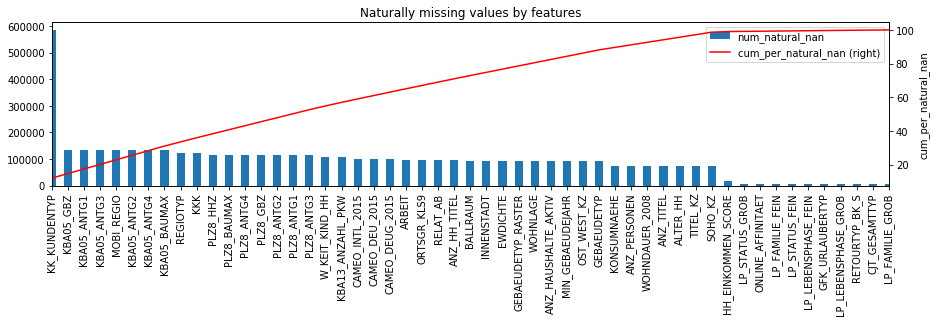

In [13]:
# 1.1 ASSES MISSING DATA
# asses naturaly missing data

# print overview
natur_nan_count = azdias.isnull().sum().sum()
natur_nan_attr = (azdias.isnull().sum() > 0).sum()
print('There are {} ({:.1f}%) naturally missing values in {} ({:.1f}%) features.'
      .format(natur_nan_count, natur_nan_count / np.product(azdias.shape) * 100, 
              natur_nan_attr, natur_nan_attr / azdias.shape[1] * 100))

# get sorted attributes by number of missing values in descandent order
azdias_nan=(azdias.isnull()                                   # get nan mask
           .sum().to_frame(name='num_natural_nan')            # calculate missing values for attribute and cast it to dataframe
           .sort_values('num_natural_nan', ascending=False))  # sort attributes by number of missing data in descanding order

# % of naturally missing data as reference to all records 
azdias_nan['cum_per_natural_nan'] = azdias_nan['num_natural_nan'].cumsum() / azdias_nan['num_natural_nan'].sum() * 100       

# filter only attributes with missing data
azdias_nan_flt = azdias_nan[azdias.isnull().sum() > 0]               

# print bar and line chart
ax = azdias_nan_flt.plot.bar(y='num_natural_nan', figsize=[15,3], title='Naturally missing values by features')
ax = azdias_nan_flt.plot.line(y='cum_per_natural_nan', secondary_y=True, color='r', ax=ax, sharex=True, rot=90)
ax.set_ylabel('cum_per_natural_nan')
plt.show()

There are 3477091 (4.6%) values with missing or uknown codes in 25 (29.4%) features


C:\Users\Fredo\.conda\envs\DSND-T1\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


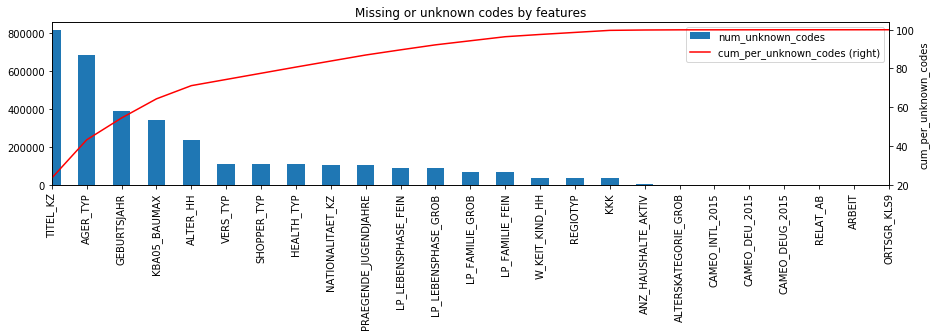

In [14]:
# asses missing or unknown codes
# get unknown codes mask
unknown_codes_mask = azdias.apply(mask_unknown_codes, axis=0, 
                                  args=(feat_info.set_index('attribute')['missing_or_unknown'],))
# print overview
unknown_codes_count = unknown_codes_mask.sum().sum()
unknown_codes_attr = (unknown_codes_mask.sum() > 0).sum()
print('There are {} ({:.1f}%) values with missing or uknown codes in {} ({:.1f}%) features'
      .format(unknown_codes_count, unknown_codes_count / np.product(azdias.shape) * 100, 
              unknown_codes_attr, unknown_codes_attr / azdias.shape[1] * 100))

# calculate unknown codes for attributes and add it to azdias_nan dataframe
azdias_nan['num_unknown_codes'] = unknown_codes_mask.sum()

# sort attributes by number of uknown codes in descanding order
azdias_nan.sort_values('num_unknown_codes', ascending=False, inplace=True)   

# % of missing and unknown codes as reference to all records 
azdias_nan['cum_per_unknown_codes'] = ( 
    azdias_nan['num_unknown_codes'].cumsum() / azdias_nan['num_unknown_codes'].sum() * 100)

# filter only attributes with missing or unknown codes
azdias_nan_flt = azdias_nan[unknown_codes_mask.sum() > 0]               

# print bar and line chart
ax = azdias_nan_flt.plot.bar(y='num_unknown_codes', figsize=[15,3], title='Missing or unknown codes by features')
ax = azdias_nan_flt.plot.line(y='cum_per_unknown_codes', secondary_y=True, color='r', ax=ax, sharex=True, rot=90)
ax.set_ylabel('cum_per_unknown_codes')
plt.show()

In [15]:
# 1.1.1 CONVERT MISSING VALUE CODES TO NaNs
azdias_cnvrt = azdias.progress_apply(replace_unknown_codes, axis=0, 
                                     args=(feat_info.set_index('attribute')['missing_or_unknown'], np.nan))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:24<00:00,  3.47it/s]


In [16]:
# summary of non numeric features
[print('{:15}: {}'.format(idx, val.unique())) for idx, val in azdias_cnvrt.select_dtypes('O').iteritems()]

OST_WEST_KZ    : [nan 'W' 'O']
CAMEO_DEU_2015 : [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


[None, None]

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

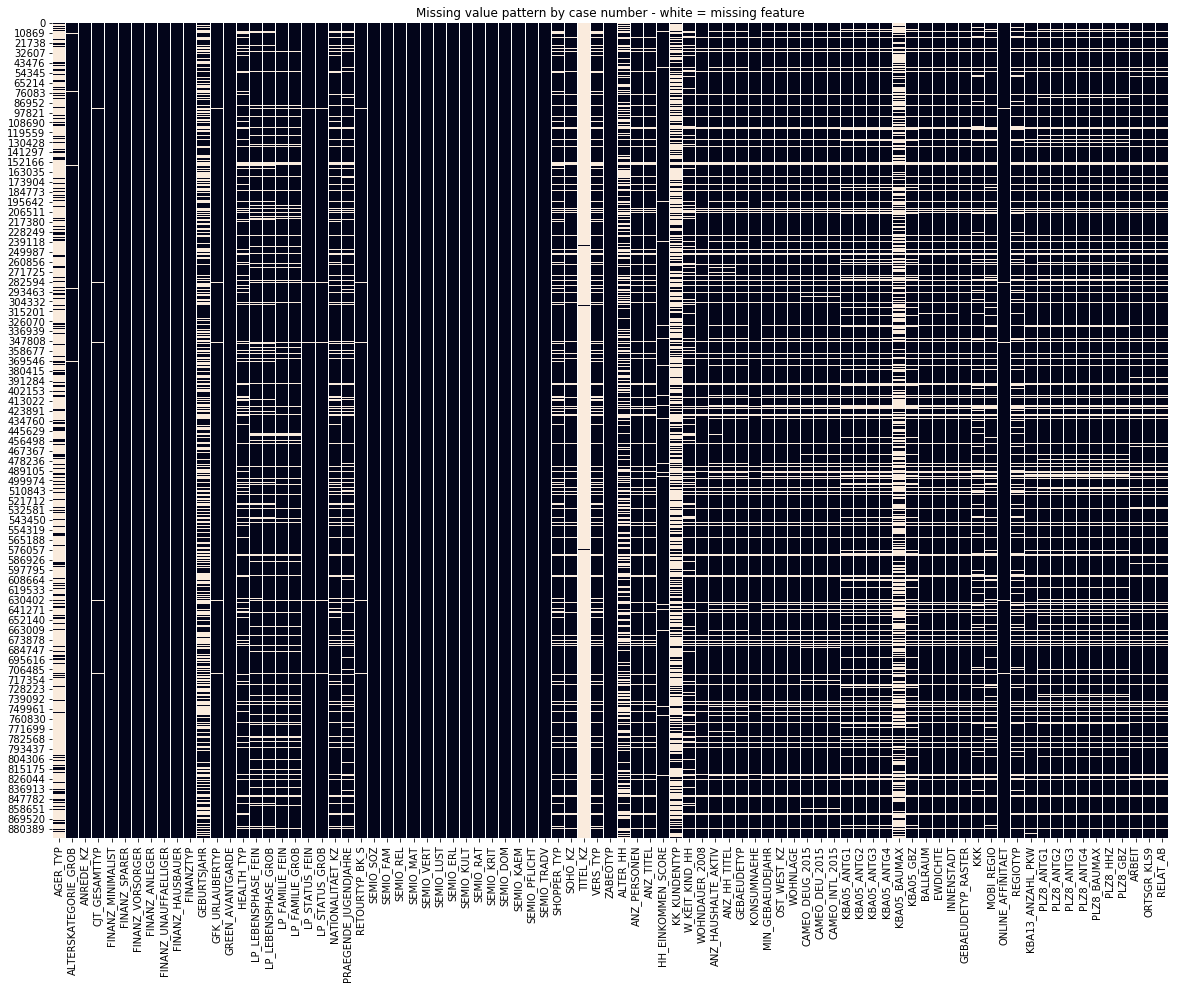

In [17]:
# MISSING VALUES PATTERNS
# print missing values patterns sorted by case number
# plot headmap of patterns missing values in white
fig = plt.figure(figsize=(20,15))
sns.heatmap(azdias_cnvrt.isnull(), cbar=False, ax=fig.gca(), square=False);
plt.title('Missing value pattern by case number - white = missing feature')
plt.show()

There are 8373929 (11.1%) missing values in 61 (71.8%) features


C:\Users\Fredo\.conda\envs\DSND-T1\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


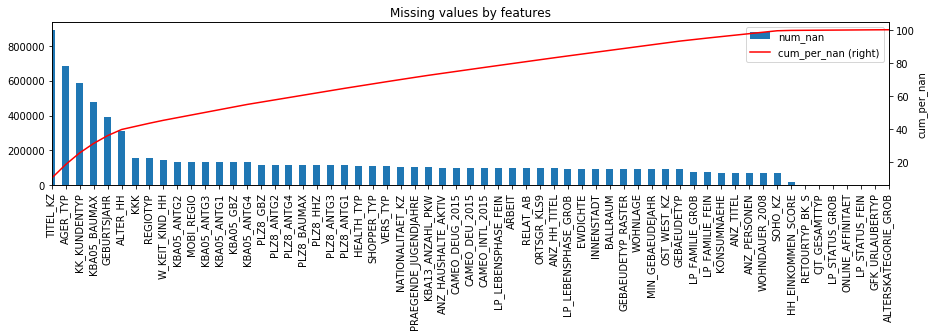

In [18]:
# 1.1.2 ASSESMENT OF HOW MUCH MISSING DATA IS IN EACH COLUMN
# print overview
nan_count = azdias_cnvrt.isnull().sum().sum()
nan_attr = (azdias_cnvrt.isnull().sum() > 0).sum()
print('There are {} ({:.1f}%) missing values in {} ({:.1f}%) features'
      .format(nan_count, nan_count / np.product(azdias.shape) * 100, 
              nan_attr, nan_attr / azdias.shape[1] * 100))

# calculate missing values for attributes and add it to azdias_nan dataframe
azdias_nan['num_nan'] = azdias_cnvrt.isnull().sum()

# sort attributes by number of missing values
azdias_nan.sort_values('num_nan', ascending=False, inplace=True)
# debug: azdias_nan.sort_index(axis=0, inplace=True)

# % of missing and unknown codes as reference to all records 
azdias_nan['per_nan'] = azdias_nan['num_nan'] / azdias.shape[0] * 100
azdias_nan['cum_per_nan'] = azdias_nan['num_nan'].cumsum() / azdias_nan['num_nan'].sum() * 100

# filter only attributes with missing values
azdias_nan_flt = azdias_nan[azdias_cnvrt.isnull().sum() > 0]               

# print bar and line chart
ax = azdias_nan_flt.plot.bar(y='num_nan', figsize=[15,3], title='Missing values by features')
ax = azdias_nan_flt.plot.line(y='cum_per_nan', secondary_y=True, color='r', ax=ax, sharex=True, rot=90)
ax.set_ylabel('cum_per_nan')
plt.show()

C:\Users\Fredo\.conda\envs\DSND-T1\lib\site-packages\IPython\core\interactiveshell.py:3325: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


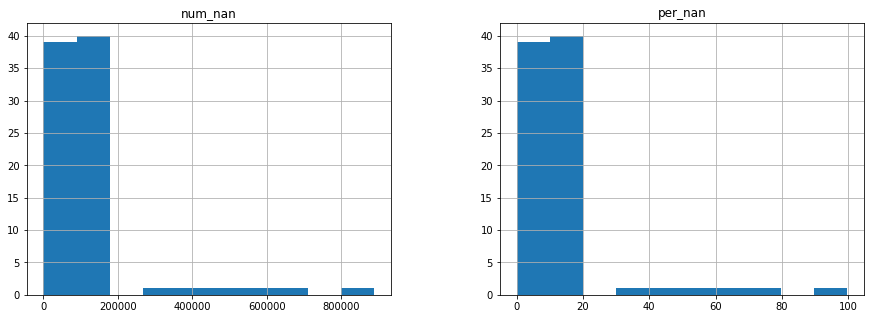

In [19]:
# check distribution of missing values in all features
fig = plt.figure(figsize=(15, 5))
azdias_nan[['num_nan', 'per_nan']].hist(ax=fig.gca());

There are 6 features with missing values over 30% which are candidates for deletion.


C:\Users\Fredo\.conda\envs\DSND-T1\lib\site-packages\IPython\core\interactiveshell.py:3325: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


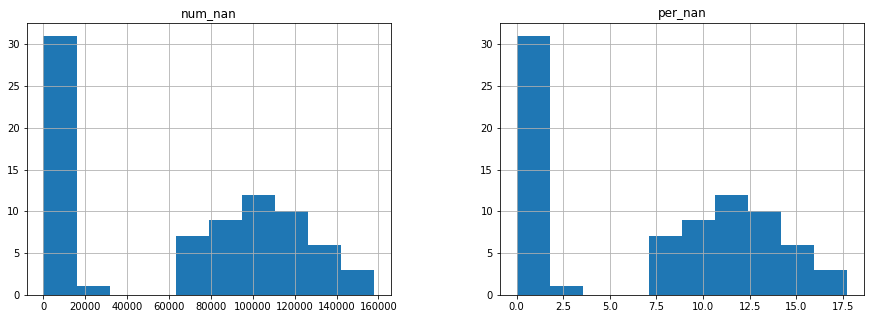

In [20]:
# check distribution of missing values exludign outliers
# set treshold for outliers
drop_treshold = 30

# get features as candidates for deletion
feat_drop = azdias_nan.index[azdias_nan['per_nan'] >= drop_treshold]

# print # or features as candidates for deletion
print('There are {} features with missing values over {}% which are candidates for deletion.'
      .format(len(feat_drop), drop_treshold))

# check distribution of missing values with excluded attributes outliers
feat_keep = azdias_nan.index[azdias_nan['per_nan'] < drop_treshold]
fig = plt.figure(figsize=(15, 5 ))
azdias_nan.loc[feat_keep, ['num_nan', 'per_nan']].hist(ax=fig.gca());

In [21]:
feat_drop

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

In [22]:
# list of features having missing values between 10-30% which should be remedied
# remedy treshold
rem_treshold = 10

# get features which (no) need remedy 
feat_remedy = azdias_nan.index[(rem_treshold < azdias_nan['per_nan']) & (azdias_nan['per_nan'] <= drop_treshold)]
feat_no_remedy = azdias_nan.index[(0 < azdias_nan['per_nan']) & (azdias_nan['per_nan'] <= rem_treshold)]

# print # or features which (no) need remedy
print('There are {} features with missing values over {}% which need remedy.'
      .format(len(feat_remedy), rem_treshold))

print('There are {} features with missing values below {}% which do not need remedy.'
      .format(len(feat_no_remedy), rem_treshold))

There are 40 features with missing values over 10% which need remedy.
There are 15 features with missing values below 10% which do not need remedy.


In [23]:
# load missing data patterns from HDF5 file
store = pd.HDFStore('temp_data.h5')
nan_pattern = store['nan_pattern']

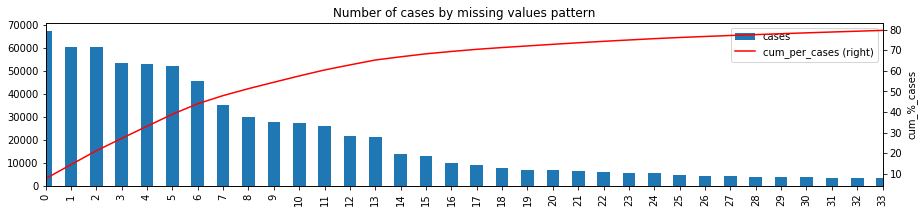

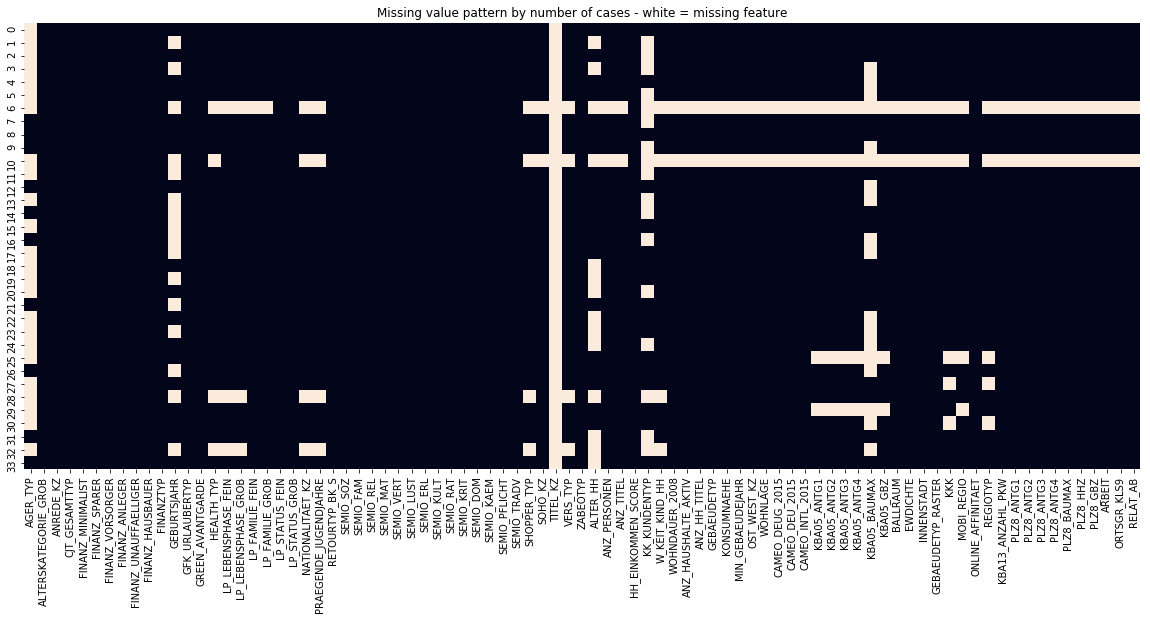

In [24]:
# ANALYSE MISSING DATA PATTERNS BY NUMBER OF CASES 
# sort patterns by number of cases in descanding order
nan_pattern.sort_values('cases', ascending=False, inplace=True)

# calculate cumulative percentage
nan_pattern['cum_per_cases'] = nan_pattern['cases'].cumsum() / nan_pattern['cases'].sum() * 100

# filter only patterns accounting for x% of cases
zoom = nan_pattern['cum_per_cases'] <= 80                        

# print pareto chart of missing patterns by number of cases
ax = nan_pattern[zoom].plot.bar(y='cases', figsize=[15,3], title='Number of cases by missing values pattern')
ax = nan_pattern[zoom].plot.line(y='cum_per_cases', secondary_y=True, color='r', ax=ax, sharex=True, rot=90, 
                                 use_index=False)
ax.set_ylabel('cum_%_cases')
plt.show()

# print missing values patterns accounting for x% of cases
# plot headmap of patterns missing values in white
fig = plt.figure(figsize=(20,15))
sns.heatmap(nan_pattern[[*azdias.columns]][zoom], cbar=False, ax=fig.gca(), square=True);
plt.title('Missing value pattern by number of cases - white = missing feature')
plt.show()

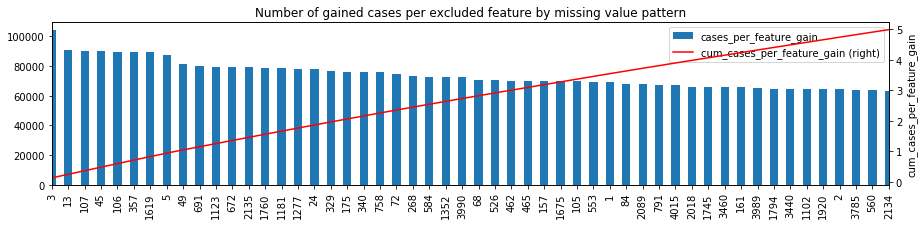

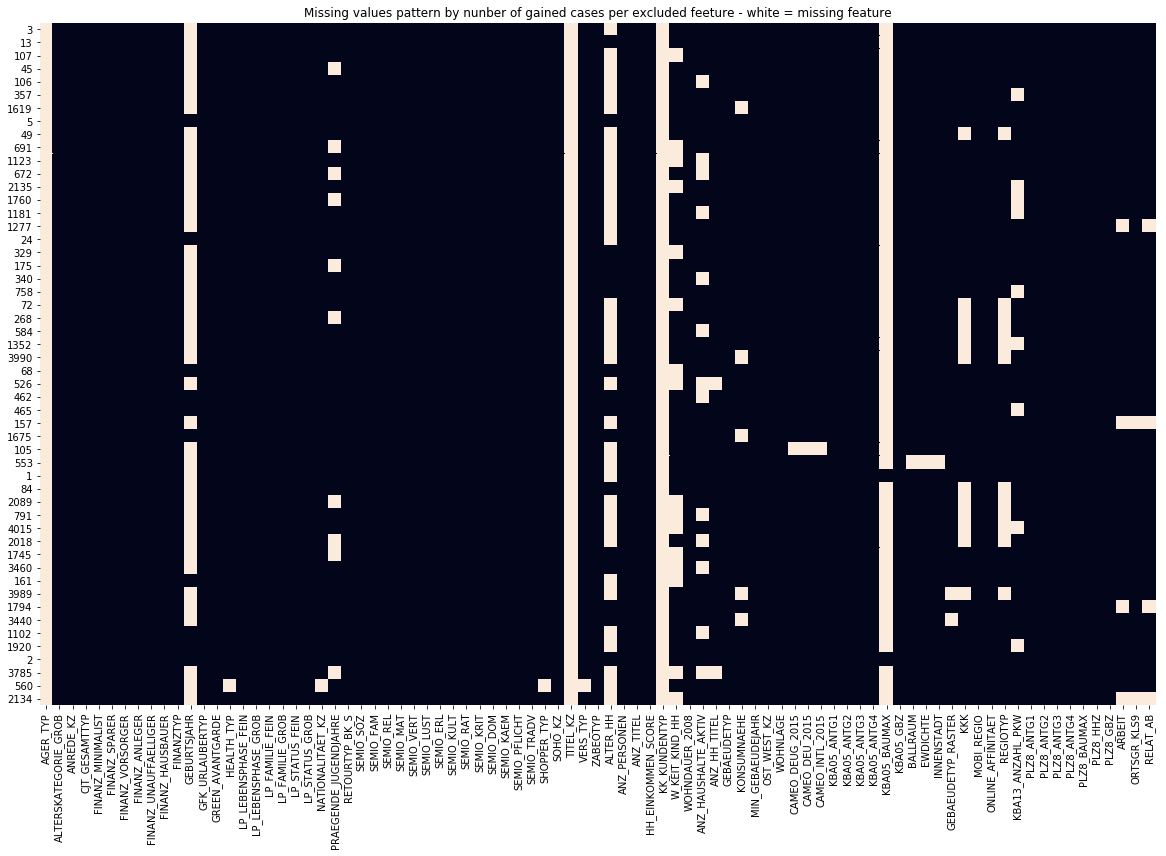

In [25]:
# ANALYSE MISSING DATA PATTERNS BY GAIN OF CASES PER EXCLUDED FEATURE
# sort patterns by number of comlete cases in descanding order
nan_pattern.sort_values('cases_per_feature_gain', ascending=False, inplace=True)

# calculate cumulative percentage
nan_pattern['cum_cases_per_feature_gain'] = (
    nan_pattern['cases_per_feature_gain'].cumsum() / nan_pattern['cases_per_feature_gain'].sum() * 100)

# filter only patterns accounting for x% of cases
zoom = nan_pattern['cum_cases_per_feature_gain'] <= 5                         

# print pareto chart of missing patterns by number of cases
ax = nan_pattern[zoom].plot.bar(y='cases_per_feature_gain', figsize=[15,3], 
                                title='Number of gained cases per excluded feature by missing value pattern')
ax = nan_pattern[zoom].plot.line(y='cum_cases_per_feature_gain', secondary_y=True, color='r', ax=ax, sharex=True, rot=90,
                                 use_index=False)
ax.set_ylabel('cum_cases_per_feature_gain')
plt.show()

# print missing values patterns accounting for x% of cases
# plot headmap of patterns missing values in white
fig = plt.figure(figsize=(20,15))
sns.heatmap(nan_pattern[[*azdias.columns]][zoom], cbar=False, ax=fig.gca(), square=True);
plt.title('Missing values pattern by nunber of gained cases per excluded feeture - white = missing feature')
plt.show()

In [26]:
# DELETE FEATURES WITH EXTREME MISSING VALUES
# get features as candidates for deletion
feat_drop = azdias_nan.index[azdias_nan['per_nan'] >= drop_treshold]

# get extra features to from form dataset
# feat_drop = feat_drop.append(pd.Index(['W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV', 'KKK', 'REGIOTYP',
#        'PRAEGENDE_JUGENDJAHRE', 'KBA13_ANZAHL_PKW']))

# remove features from dataset with converted uknown codes to missing values
azdias_feat_drop = azdias_cnvrt.drop(columns=feat_drop)
azdias_feat_drop_mask = azdias_feat_drop.isnull()


# display drop features
print('Features to drop:')
display([(feat_details[feat]['long_name'], feat) for feat in feat_drop])

# describe missing data after dropping outliers

# missing datapoints
nan_count = azdias_feat_drop_mask.sum().sum()
nan_attr = (azdias_feat_drop_mask.sum() > 0).sum()
print('There are {} ({:.2f}%) missing values in {} ({:.2f}%) features after excluding outliers'
      .format(nan_count, nan_count / np.product(azdias_feat_drop.shape) * 100, 
              nan_attr, nan_attr / azdias_feat_drop.shape[1] * 100)) 

# complete cases
complete_cases = (~azdias_cnvrt.isnull().any(axis=1)).sum()
complete_cases_drop = (~azdias_feat_drop_mask.any(axis=1)).sum()

print('There are {} ({:.2f}%) of complete cases in original dataset.'
     .format(complete_cases, complete_cases / azdias_cnvrt.shape[0] * 100))

print('There are {} ({:.2f}%) of complete cases after dropping {} features.'
     .format(complete_cases_drop, complete_cases_drop / azdias_feat_drop.shape[0] * 100,
            azdias_cnvrt.columns.size - azdias_feat_drop.columns.size))

Features to drop:


[('Academic title flag ', 'TITEL_KZ'),
 ('Best-ager typology ', 'AGER_TYP'),
 ('Consumer pattern over past 12 months ', 'KK_KUNDENTYP'),
 ('Most common building type within the microcell ', 'KBA05_BAUMAX'),
 ('Year of birth', 'GEBURTSJAHR'),
 ('Birthdate of head of household ', 'ALTER_HH')]

There are 5035304 (7.15%) missing values in 55 (69.62%) features after excluding outliers
There are 143 (0.02%) of complete cases in original dataset.
There are 623209 (69.93%) of complete cases after dropping 6 features.


#### Discussion 1.1.2: Assess Missing Data in Each Column
Discussion on missing data follows 4 step process according reference [Multivariate Data Analysis. 7th Edition.](https://www.amazon.com/Multivariate-Data-Analysis-Joseph-Hair/dp/0138132631)

#### Step 1: Determining type of missing data
Analyzing missing value patterns sorted by case number following can be concluded:
- missing values seems to be random across cases
- there is non-random pattern across variables, where missing values are concentrated mostly in right half side of the dataset

Non random pattern could indicate
- ignorable missing data, like missing inherent in data collection process (ex. some variables are not applicable for certain respondents/people)
- non-ingoralbe missing data, like some respondents did not asnwered the quetions for uknown reasons (ex. felt ofended, didn't know, get tire to complete questionaire etc...)

As details about data collection process are not known, I will consider missing data as not-ingnorable

#### Step 2: Determine the extend of missing data

##### Missing Value proportions in features
There are:
- 8373929 (11.1%) missing values in 61 (71.8%) features
- 143 (0.02%) of complete cases in original dataset
- From the pareto and distribution of proportion of missing values in features it seems that there are 6 outliers having >30% of missing values. These features are candidates for deletion to reduce missing values in the dataset. These are:
- `TITEL_KZ`- Academic title flag
- `AGER_TYP`- Best-ager typology
- `KK_KUNDENTYP`- Consumer pattern over past 12 months
- `KBA05_BAUMAX`- Most common building type within the microcell
- `GEBURTSJAHR`- Year of birth
- `Alter_HH` - Birthdate of head of household

Apart of candidates for deletion there are 40 features with missing values over 10% which need remedy and 15 below 10% where level of missing data is acceptable.

If extend of the missing data is above 10% across variables, cases and overal, the randomness of missing data process needs to be examined in order to define correct imputation method to minize possible bias due to deletion or imputation of missing values.

##### Patterns of missing values
When looking to missing value patterns sorted by number of the cases in descanding order we can conclude following:
- 7 missing value patterns accounts almost for 45% of all cases which indicate non-random missing data process across features
- pattern 1-6 include only 6 mentioned candidates for deleting
- patter 7 and 10 have >65% missing features

##### Excluding features
When looking to missing values patterns sorted by number of complete cases gained per excluded feature in descanding order we can conclude following:
- There are 143 (0.02%) of complete cases in original dataset.
- There are 623209 (69.93%) of complete cases after dropping 6 features.

This is significant 69.91% gain in # of complete cases while excluding only 6 (7.06%) of features. Totaly number of missing values will reduced from 11.1% to 7.15%.

The complete case gain justify exclusion of 6 features. It is safe to delete them as they are also highly associated with other variables in dataset, which will preserve the intent of deleted features.

Note: Association matrix is plotted and features are deleted in section "1.2.3: Complete Feature Selection" as it assosciation coeficients depends on scale type of the features, which is analyzed in secion "Step 1.2: Select and Re-Encode Features"

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

C:\Users\Fredo\.conda\envs\DSND-T1\lib\site-packages\IPython\core\interactiveshell.py:3325: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


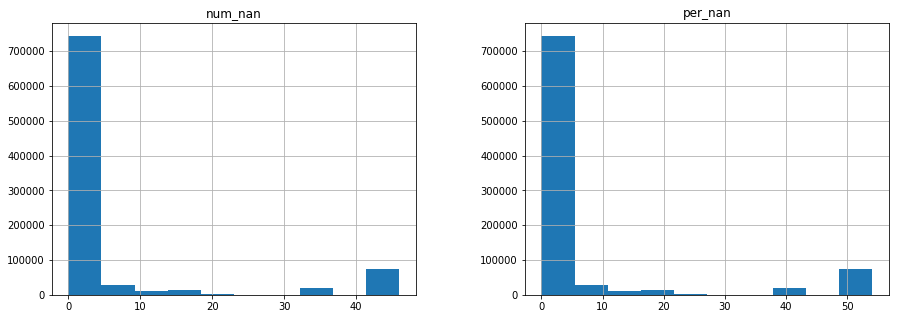

In [27]:
# 1.1.3 ASSESMENT OF HOW MUCH MISSING DATA IS IN EACH CASE
# get sorted cases by number of missing values in descandent order
azdias_nan_case = (azdias.isnull()                           # get nan mask
                  .sum(axis=1).to_frame(name='num_nan')      # calculate missing values for case and cast it to dataframe
                  .sort_values('num_nan', ascending=False))  # sort cases by number of missing data in descanding order

# % of missing values in case 
azdias_nan_case['per_nan'] = azdias_nan_case['num_nan'] / azdias.shape[1] * 100 

# check distribution of missing values in all cases
fig = plt.figure(figsize=(15, 5))
azdias_nan_case[['num_nan', 'per_nan']].hist(ax=fig.gca());

In [28]:
# divide the data into two subsets based on the number of missing values in each row
# Cases with more than 10% of missing data should be remedied ref. Multivariate Data Analysis. 7th Edition
# dataset with missing cases
azdias_missing_cases = azdias.loc[azdias_nan_case['per_nan'] > rem_treshold, :]

# dataset with almost complete cases: missing values <= 10%
azdias_complete_cases = azdias.drop(index=azdias_missing_cases.index)

# print result
print('There are {} ({:.1f}%) of cases with more than {:.1f}% of missing values. These need to ber remedied.'
     .format(azdias_missing_cases.index.size,
             azdias_missing_cases.index.size / azdias.index.size * 100, 
             rem_treshold))
print('There are {} ({:.1f}%) of cases with less or equal to {:.1f}% of missing values. These are acceptable'
      .format(azdias_complete_cases.index.size,
              azdias_complete_cases.index.size / azdias.index.size * 100, 
              rem_treshold))

# Cases with more than 20-30 % of missing data should be deleted ref. Multivariate Data Analysis. 7th Edition
# dataset with outlier missing cases
azdias_drop_cases = azdias.loc[azdias_nan_case['per_nan'] > drop_treshold, :]

# print result
print('There are {} ({:.1f}%) of outlier cases with more than {:.1f}% of missing values. These should be deleted'
     .format(azdias_drop_cases.index.size,
             azdias_drop_cases.index.size / azdias.index.size * 100, 
             drop_treshold))

There are 130125 (14.6%) of cases with more than 10.0% of missing values. These need to ber remedied.
There are 761096 (85.4%) of cases with less or equal to 10.0% of missing values. These are acceptable
There are 93222 (10.5%) of outlier cases with more than 30.0% of missing values. These should be deleted


C:\Users\Fredo\.conda\envs\DSND-T1\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


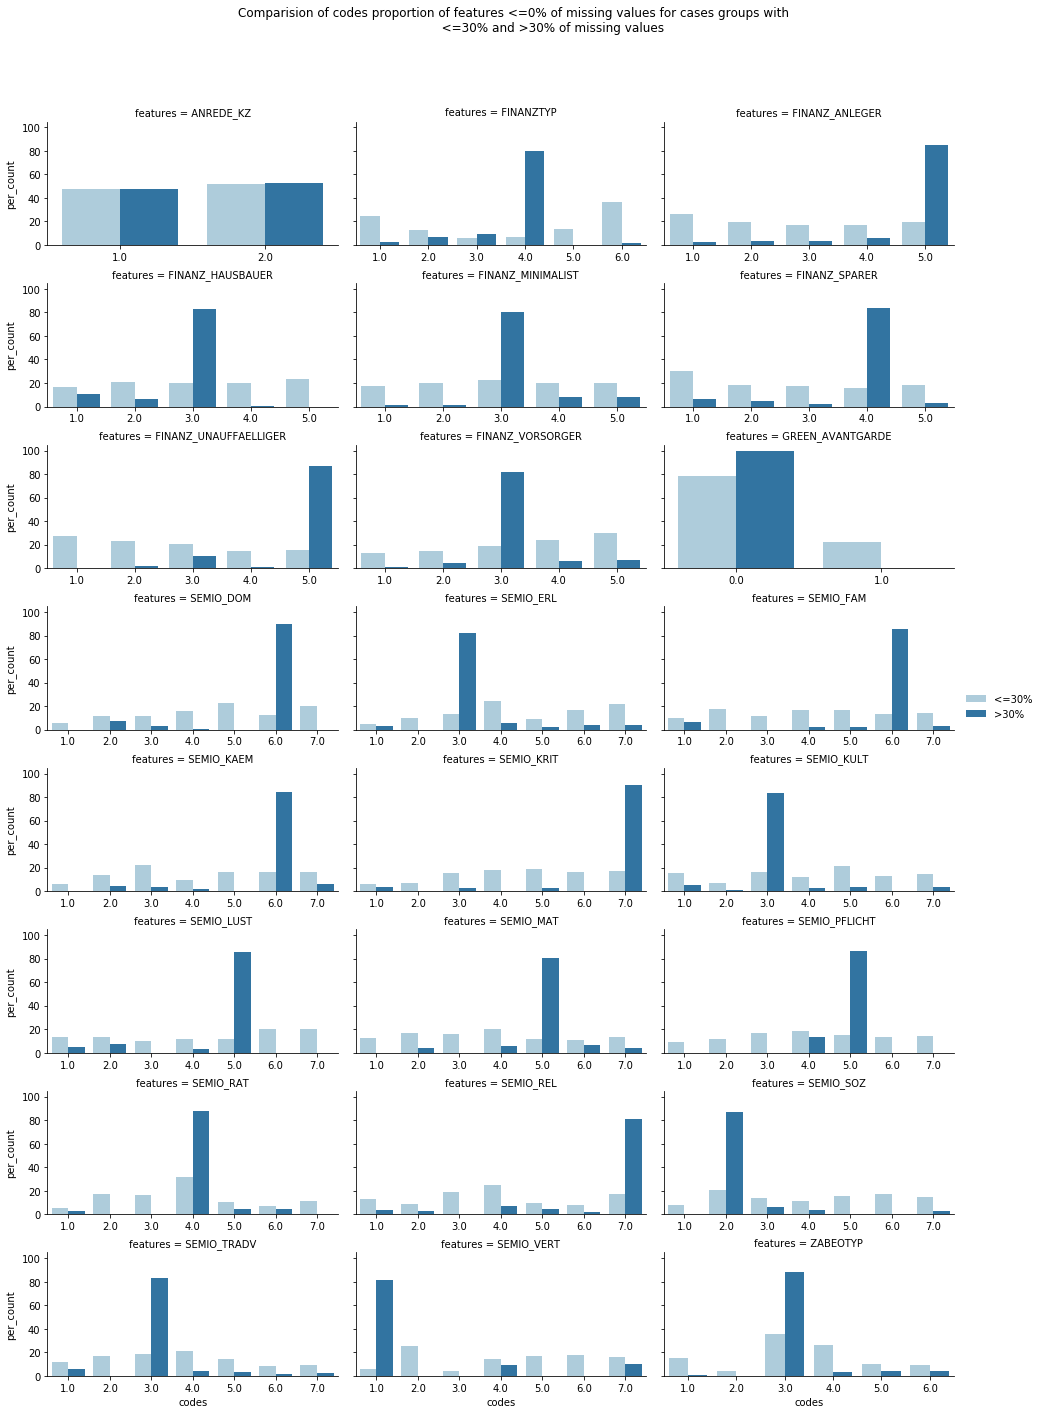

In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def map_feature_details(case, feat_details, num_char_feat=25, num_char_code=10):
    '''
    transforms features name and codes to their long versions
    Args:
        case: sample/case/row of dataset in form of series including at least 'feature' and 'codes' in index
        feat_details: mapping of feature short names to detials (long_name and levels)
        num_char_feat: number of characters to keep in feature long name, 25 by default
        num_char_code: number of characters to keep, 10 by default
        Note: if num_char argument is 0 particular transformation will not happen
    
    Returns:
        case: transformed feature name and codes to their long version in form of series
    '''
    
    # transform feature codes to levels
    if num_char_code >0:
        try: 
            case['codes'] = feat_details[case['features']]['levels'][str(int(case['codes']))][:num_char_code]
        except: pass

    # transform feature short name to long name
    if num_char_feat > 0 :
        case['features'] = feat_details[case['features']]['long_name'][:num_char_feat]
    
    return case

def per_count(group):
    group = group / group.sum() * 100
    return group
    
def show_missing_at_random(data, rem_treshold=10, drop_treshold=30, feat_show=None, feat_details=None):
    '''
    plot code proportion comparison of two groups of cases formed by treshold for specified features of the data
    
    Args:
        data: dataset in form of DataFrame with shape (# of samples, # of features)
        rem_treshold: treshold in % missing values below the features are considered 
                      having no or few missing values. Those features are selected for distribution testing.
                      By default 10%
        drop_treshold: treshold in % missing values above the cases are considered for deletion. By default 30%.
                       Suggested range 20-30% ref. Multivariate Data Anlysis. 7th Edition.
        feat_show: Integer, number of features with no or few missing values to show, by default None means shows all features
                   Features are selected randomly from set of features with no or few missing values.
                   Or array like or index of features to show.
        feat_details: mapping of feature short names to details, by default None
        
    Returns:
        seaborn.FacetGrid object
    '''
    # check validity of inputs
    # -------------------------
    assert isinstance(data, pd.DataFrame), \
    'Data need to be type of pandas.DataFrame with shape (# of samples/cases, # of features)'
    
    assert (isinstance(feat_details, dict) and set(data.columns) == set(feat_details.keys()) and \
            'long_name' in feat_details[list(feat_details.keys())[0]]) or feat_details is None, \
    '''feature details need to be a nested dictionary with 1st level keys matching data features names, 
    and have second level key "long_name".'''
    
    assert (0 <= rem_treshold <= 100) and (0 <= drop_treshold <= 100), \
    'Treshold need to be % of missing data in the cases, so interval 0-100'
    
    assert isinstance(feat_show, (int, list, np.ndarray, pd.Index)) or feat_show is None, \
                      'Features to show, need to be an integer or array like of column names'
    
    # split dataset into two groups
    # -----------------------------
    # get missing value mask
    nan_mask = data.isnull()
    
    # calculate proportion of missing values in each case
    per_nan_cases = nan_mask.sum(axis=1) / data.columns.size * 100
    
    # get cases index with missing values above treshold
    high_nan_cases = data.index[per_nan_cases > drop_treshold]
    
     # calculate proportion of missing values in each feature
    per_nan_feat = nan_mask.sum() / data.index.size * 100
    
    # get features with no or few missing velues
    # if not defined by user
    if feat_show is None: 
        # select all features with no or few (below rem_treshold %) missing values
        low_nan_feat = data.columns[per_nan_feat <= rem_treshold]
    
    # if number of features to show defined
    elif isinstance(feat_show, int):
        # select randomly x features with no or few (below rem_treshold %) missing values
        low_nan_feat = data.columns[per_nan_feat <= rem_treshold]
        low_nan_feat = np.random.choice(low_nan_feat.values,
                                        size=min(feat_show, len(low_nan_feat)),
                                        replace=False)
                      
    # if features to show specified by user  
    elif isinstance(feat_show, (list, np.ndarray, pd.Index)): low_nan_feat = feat_show

    data = data[low_nan_feat]    # filter only selected features
    
    # stratify features to groups with few missing values and high missing values cases
    data['missing_values'] = data.apply(
        lambda case: f'>{drop_treshold}%' if case.name in high_nan_cases else f'<={drop_treshold}%',
        axis=1)
    
    # transform data for easy printing
    # --------------------------------
    # stack all features into one column
    data = pd.melt(data, id_vars=['missing_values'], value_vars=data.columns.drop('missing_values'),
                  var_name='features', value_name='codes')

    # calcuate code count per feature and group and store it to 'count' column
    data = (data #.astype(str)                              # cast data to text to keep nan values as code
                .groupby([*data.columns])                   # group by missing values, features and codes
                ['codes'].count()                           # calculate codes counts
                .reset_index(name='count'))                 # create code count column
    
    # calcuate code count proprotion per feature and group and store it to 'per_count' column
    data['per_count'] = (data.groupby(['missing_values', 'features'])    # group by missing values, features
                             ['count'].transform(                        # calculate codes relative counts
                             lambda group: group / group.sum() * 100 ))  # per group and feature       
                                                                         

    # if feature details are passed, map features short names to long names
    if feat_details != None:
        num_char_feat = 45   # num of feature long name charaters to print, if 0 no maping will be done
        num_char_code = 5    # num o codes long name characters to print, if 0 no mapping will be done
        data[['features', 'codes']] = (
            data[['features', 'codes']]
            .apply(map_feature_details, axis=1, args=(feat_details, num_char_feat, num_char_code)))
        
    # print code proportion comparison of groups stratified by features
    g = sns.FacetGrid(data, col='features', col_wrap=3, sharex=False, height=2.5, aspect=1.8)
    g = g.map(sns.barplot, 'codes', 'per_count', 'missing_values', palette=sns.color_palette('Paired'),
             hue_order = data['missing_values'].unique())
    
    # print title
    title_height = 2                              # requested title height in inches
    fig_height = g.fig.get_size_inches()[1]         # current figure height
    top = (fig_height - title_height) / fig_height  # height of the subplot in % of figure height
    
    plt.subplots_adjust(top=top)
    g.fig.suptitle('''Comparision of codes proportion of features <={}% of missing values for cases groups with 
                   <={}% and >{}% of missing values'''.format(rem_treshold, drop_treshold, drop_treshold))
    
    # add legend
    g.add_legend()
    
    return g

# show if outlier cases with high proportion of missing values can be removed from dataset
# test if distribution of x randomly choosen features with no or few missing values is not diffrent 
# between groups of cases with high and low proportion of missing values
g = show_missing_at_random(data=azdias_cnvrt, rem_treshold=0, drop_treshold=drop_treshold, 
                           feat_show=None, feat_details=None);

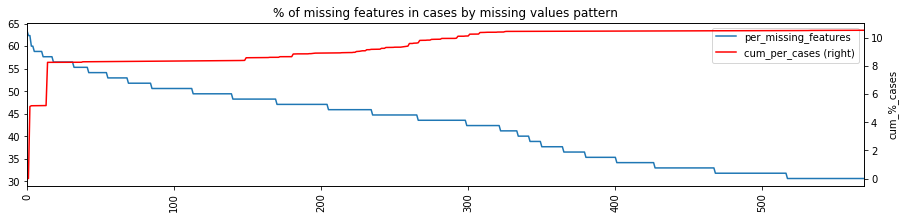

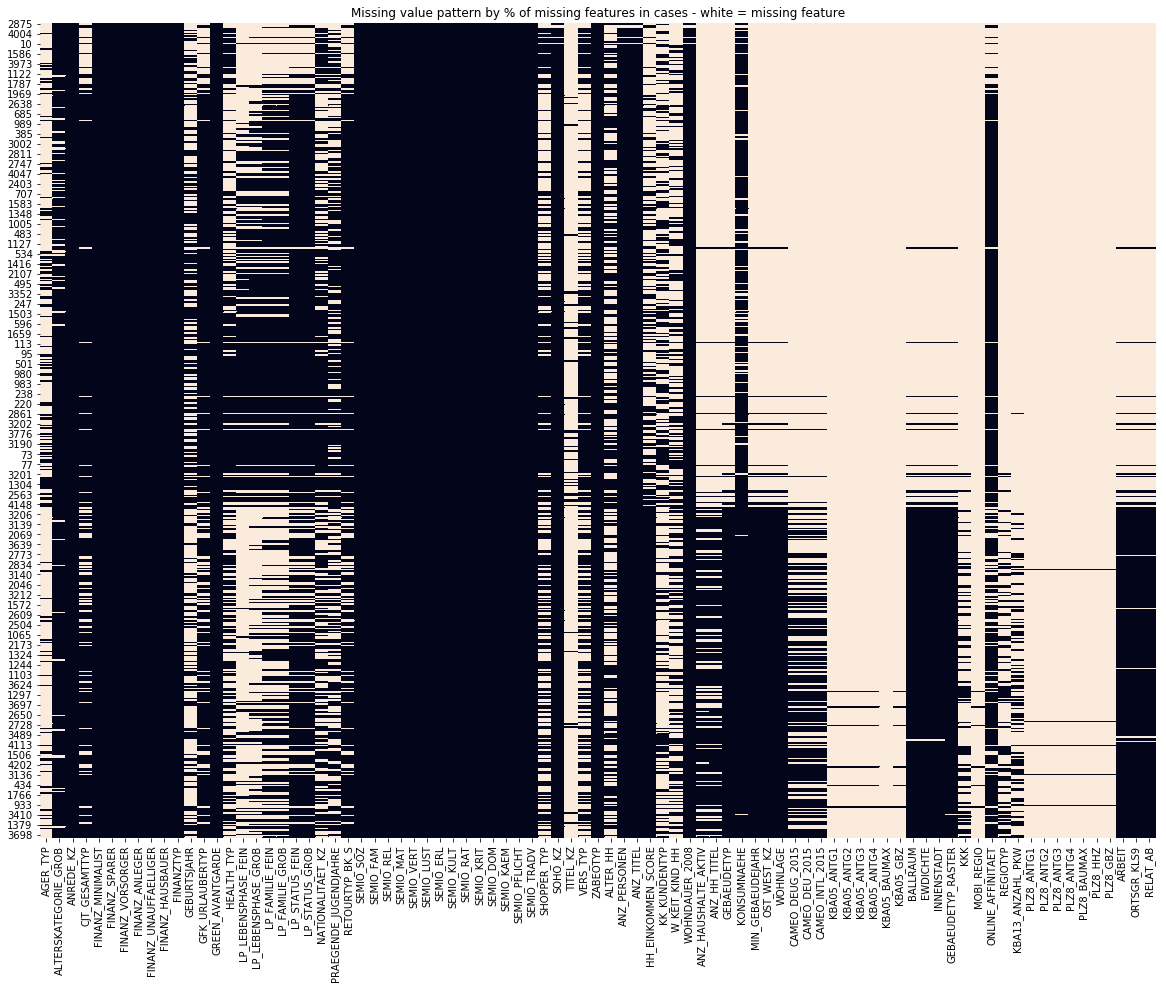

In [30]:
# ANALYSE MISSING DATA PATTERNS BY % OF MISSING FEATURES IN CASES
# sort patterns by number of cases in descanding order
nan_pattern.sort_values('missing_features', ascending=False, inplace=True)

# calculate percentage of missing features in the case
nan_pattern['per_missing_features'] = nan_pattern['missing_features'] / azdias.columns.size * 100

# calculate cumulative percentage
nan_pattern['cum_per_cases'] = nan_pattern['cases'].cumsum() / nan_pattern['cases'].sum() * 100

# filter only patterns accounting for more than x% of cases
zoom = nan_pattern['per_missing_features'] >= 30                    

# print pareto chart of missing patterns by number of cases
ax = nan_pattern[zoom].plot.line(y='per_missing_features', figsize=[15,3], 
                                title='% of missing features in cases by missing values pattern', use_index=False)
ax = nan_pattern[zoom].plot.line(y='cum_per_cases', secondary_y=True, color='r', ax=ax, sharex=True, rot=90, 
                                 use_index=False)
ax.set_ylabel('cum_%_cases')
plt.show()

# print missing values patterns accounting for x% of cases
# plot headmap of patterns missing values in white
fig = plt.figure(figsize=(20,15))
sns.heatmap(nan_pattern[[*azdias.columns]][zoom], cbar=False, ax=fig.gca(), square=False);
plt.title('Missing value pattern by % of missing features in cases - white = missing feature')
plt.show()

In [31]:
# DELETE CASES WITH EXTREME MISSING VALUES
# get outlier cases with high proportion of missing values
cases_drop = azdias_nan_case.index[azdias_nan_case['per_nan'] > drop_treshold]

# remove outlier cases from dataset with already dropped outlier features with missing values
azdias_cases_drop = azdias_feat_drop.drop(index=cases_drop)
azdias_cases_drop_mask = azdias_cases_drop.isnull()

# describe missing data after dropping outliers
# missing datapoints
nan_count = azdias_cases_drop_mask.sum().sum()
nan_attr = (azdias_cases_drop_mask.sum() > 0).sum()
print('There are {} ({:.2f}%) missing values in {} ({:.2f}%) features after excluding cases outliers.'
      .format(nan_count, nan_count / np.product(azdias_cases_drop.shape) * 100, 
              nan_attr, nan_attr / azdias_cases_drop.shape[1] * 100)) 

# complete cases
complete_cases_drop = (~azdias_cases_drop_mask.any(axis=1)).sum()
print('There are {} ({:.2f}%) of complete cases after excluding {} ({:.1f}%) cases outliers.'
     .format(complete_cases_drop, complete_cases_drop / azdias_cases_drop.shape[0] * 100,
            cases_drop.size, cases_drop.size / azdias.index.size * 100))

There are 1012584 (1.61%) missing values in 46 (58.23%) features after excluding cases outliers.
There are 623209 (78.10%) of complete cases after excluding 93222 (10.5%) cases outliers.


#### Discussion 1.1.3: Assess Missing Data in Each Row

#### Step 2: Determine the extend of missing data
As mentioned in previous section by deleting 6 features with high proportion of missing values we gained 623209 (69.93%) of complete cases. Complete cases to features ratio is 143%  which is more than min 5% and desirable 20% for executing multivariate type of analysis. On other hand we need to check if deletion of missing value cases will not cause the bias in averages and code proportions of variables, correlations and associations among variables.

##### Proportion of missing values in the cases
There are 130125 (14.6%) cases with more than 10.0% of missing values and 761096 (85.4%) cases with less or equal to 10.0% of missing values. These 14.6% cases need to be remedied. 

From distribution of proportion of missing values in cases it seems that there are 93222 (10.5%) of outlier cases with more than 30.0% of missing values. These cases are candidates for deletion to reduce missing values in the dataset.

##### Patterns of missing values
Investigating outliers missing value patterns sorted by % of missing features in cases in descanding order we can conclude:
- most of the outlier cases with >30% missing values are missing values in __"neighborhood features"__ including following feature groups (Building, Community, Postocode level features and RR1 nieghborhood, RR3-4 and PLZ8 micro-cell features) 
- this missing data process seems not to be random across features as whole neighborhood section is missing.

If it is inherent by design of data collection process (ex. the questions were not applicable for some respondents/people) outlier cases are ignorable and can be deleted.

If the outlier cases are not-ignorable (ex. the respondent was not sure what to answer, or refused to answer etc..) I would be cautious to remove them as they represent particular group of respondents which I would named as __"artists"__ due to following typology:
- finantial typology
    - finantialy prepared, 
    - with average low finantial interest
    - very low investors
    - average home ownership
    - average low finantial interest
    - low money saver
    - very low inconspicuous
    - average be prepared
- personality typology
    - very low affinity to be domintat minded
    - high affinity to be event oriented
    - very low affinity to be family minded
    - very low affinity to combative attitude
    - lowest affinity to be criticaly minded
    - high affinity to be culturarly minded
    - low affinity to be sensual minded
    - low affinity to be materialistic
    - low affinity to be dutiful
    - average affinity to be rational
    - lowest affinity to be religious
    - very high affinity to be socially minded
    - high affinity to be trandional minded
    - hihgest affinity to be dreamfull
- energy consumption typolog
    - fair suppplied

Hypothesis: Most probably artists are communting often, so they might be doubtfull about which neigberhood information to fill in questionnaire. 

##### Excluding cases
When 93222 (10.5%) outlier cases with >30% missing values would be excluded it would result in significant reduction of missing values in dataset from 7.15% to 1.61%, and improvment of complete cases from 69.93% to 78.10%. So it is wise to consider deletion but before doing so I would do following steps:

I would ask client following question:
- Do you sell artist related products or services? If no I would delete extreme cases. If yes, I would check above hypothesis with responsibles for data collection and consider some imputation methods to keeping artist in the dataset.

Anyhow imputation of the cases with proportion of missing data over 30% is very difficult. Many multiple imputation algorithms suggest to delete such a cases, or use Cold Deck Imputation from other available sources.

Even if missing data process seems to be not missign completely at random, to make decision about imputation method of remaning missing values, missing process needs to be validated statistically by:
- cross testing features with missing values for difference in group averages or group codes proportions (t-test, chi-square test, ref. `function mcar`
- Little's missing completely at random (MCAR) test

#### Discussion 1.1.4: Missing Data Imputation Methods
The missing data process is statisticaly proven not to be MCAR due to following facts:
 - mcar test heatmap shows that deleting cases with missing values for majority variables would cause bias in average estimation of personality typology features. (see blue color column pattern for SEMIO_xxx features)
 - p value of Little's MCAR test is 0

It is not recomended to use single imputation methods (like mean, mode, median, etc...) as they could introduce bias in estimates of averages and variaces. Instead specialized model techniques should be used like:
 - maximum likehoood estimation techniques
   - Expectation Maximization (EM, r-package amelia)
   - Structural Equaltion Modeling (SEM)
   - Full Information Maximum Likehood (FIML)
 - multiple imputation techniques 
   - Multiple Imputation with Chained Equations (MICE, r-packege mice)
 - hot deck methods
   - k-nearest neighbours
   - hot deck imputation
 - random Forest
  
I choosed to test MICE and KNN, where mice aims for best estimates quality and knn for speed

Note: MCAR, MICE and KNN testing are done in section "1.2.3: Complete Feature Selection" as they depends on scale type of the features, which is analyzed in secion "Step 1.2: Select and Re-Encode Features"

In [32]:
def mcar(data):
    '''
    Check if there are no differences in frequences of codes or averages between missing & valid value groups
    across all features. Helps to evalute if missing data process is MAR (Missing At Random) or
    MCAR (Missing Completely At Random) or NMAR (Not Missing At Random).
    
    Args:
        data: dataset as dataframe of shape (# of samples, # of features)
        
    Returns: Dictionary with keys and respective test characteristics as dataframes of shape (# of features, # of features) 
             described below: 
             'p_values': p values 
             'num_cases_valid_data': number of samples with valid values
             'num_cases_missing_data': number of samples with missing values
             'num_cases_power80': number of samples to have statistical power 80%
             'num_cases_used': min number of samples used to calculate statistical test, quarantied power 70-80%

    
    Note: Features in the row of the p_value dataframe determine groups with missing and valid values
          Features in the column of the p_value dataframe determine values within the groups for hypthesis testing.
          Following hypothesis tests are used:
           - t-test for numeric column features with samples size =<30 
           - z-test for numeric column features with sample size > 30
           - chi-square test for categorical column features
           
         To prevent high sensitivity of statistical tests for reason of high samples sizes in dataset (~1M samples),
         functions implements random sampling to have power of the test between 70-80%
         
         Reasons for NaN values in the p_value dataframe:
          - diagonal of the p-value dataframe, as using same feature for groups and values completely confound groups
          - if only one group is created - partial confouding of groups with values
          - if groups does not contain same codes and code feuqencies are < 5 - ref. chi-square test
          - if threre is high diffrence between # of samples between groups and invalid result is outputed 
            by statistical test
          - if power of statistical test is out of allowed range 70-80%
          - column feature is not numeric neither categorical type
           
         Column feature detection:
          - numeric features are detected based on numeric dtype
          - categorical features are detected based on 'category' dtype
          - str or object dtypes are not considered categorical neither numeric and retunrs NaN in the result
          
    Interpratation Example: It is safe to delete/impute row feature x in respect to column feature y.
                            There is no diffrence in code frequences or averages of feature y
                            between feature x groups with mising and valid values if p value >0.5 and
                            power of the test 70-80%.
    '''
    # INPUT ASSERTION
    # ---------------
    
    # check if data array like objects
    assert isinstance(data, pd.DataFrame), 'Data needs to be pd.DataFrame of np.array.' 
    
    # FUNCTION BODY
    # ------------    
    # create missing value mask
    nan_mask = data.isnull()
    
    # parameters to estimate sample size
    effect = 0.5       # medium effect between two sample groups (0.2 small effect, 0.8 large effect)
    alpha = 0.05       # significance level
    power = 0.8        # target power of the statistical test
    min_power = 0.7    # minimal  power of statistical test
    
    # initialize output dataframes
    num_feats = data.shape[1]
    # p values
    p_value = pd.DataFrame(np.full((num_feats, num_feats), np.nan), index=data.columns, columns=data.columns)
    
    # sample sizes
    no_nan_sz, nan_sz, power_sz, used_sz = (p_value.copy(deep=True) for _ in range(4))
    
    # cycle over row features determined to form missing and valid value groups
    for feat_row in tqdm_nt(data.columns):
        # get missing value mask of particular row feature
        feat_nan_mask = nan_mask[feat_row]
        
        # cycle over column features determined to fill groups by codes/values for hypothesis testing
        for feat_col in data.columns:
            # skip cycle if row and column feature are the same
            if feat_col == feat_row: 
                # calculate sample sizes
                no_nan_sz.loc[feat_row, feat_col], nan_sz.loc[feat_row, feat_col] = (~feat_nan_mask).sum(), 0
                # skip cycle
                continue
            
            # get values/codes of column feature
            values = data[feat_col]
            
            # create dataframe with groups and values/codes
            df = pd.concat([feat_nan_mask, values], axis=1)
            
            # drop missing values
            df = df.dropna(subset=[feat_col])

            # get groups sample sizes
            grouped_fr = df.groupby([feat_row])
            group_sample_sizes = grouped_fr.count()

            # ad sample sizes to output dataframes
            try: no_nan_sz.loc[feat_row, feat_col] = group_sample_sizes.loc[False, feat_col]
            except KeyError: no_nan_sz.loc[feat_row, feat_col] = 0
            try: nan_sz.loc[feat_row, feat_col] = group_sample_sizes.loc[True, feat_col]
            except KeyError: nan_sz.loc[feat_row, feat_col] = 0
            
            # check if the both groups are present
            grouped_fr_fc = df.groupby([feat_row, feat_col])    # group data by groups and codes
            frequency = grouped_fr_fc[feat_col].count()         # calculate frequency of each code within group
            groups = frequency.index.remove_unused_levels().levels[0]
#             if feat_row == 'KONSUMNAEHE' and feat_col == 'NACHBARSCHAFT_QLT': ipdb.set_trace()
            if set(groups) == set([True, False]):
            
                # check if the feature is categorical then apply chi-square test
                if values.dtype.name == 'category':
                                            
                    # account for sample size to have statistical power 80%
                    num_codes = len(frequency.index.levels[1])
                    power_sz.loc[feat_row, feat_col] = GofChisquarePower().solve_power(
                        effect, nobs=None, alpha=alpha, power=power, n_bins=num_codes)
                        
                    # select optimum sample size
                    opt_sz = int(min(power_sz.loc[feat_row, feat_col], 
                                     no_nan_sz.loc[feat_row, feat_col],
                                     nan_sz.loc[feat_row, feat_col]))
                    
                    # if optimum sample size does not reach min power return NaN and run next cycle
                    if opt_sz < GofChisquarePower().solve_power(
                        effect, nobs=None, alpha=alpha, power=min_power, n_bins=num_codes):
                        continue
                    
                    # randomply select optimimum number of samples from each group 
                    
                    df = (grouped_fr[feat_col]
                          .apply(pd.DataFrame.sample, n=opt_sz)
                          .reset_index(level=0))
                    
                    # calculate code frequences with sampled data
                    frequency = df.groupby([feat_row, feat_col]).size()
                    
                    # get observed and expected frequencies
                    observed = frequency[(True,)].values     # missing values are observed frequencies
                    expected = frequency[(False,)].values    # non missing values are expected freqencies

                    # calculate one way chi square test
                    # check if same codes are present in both groups and counts are >=5
                    if (np.product(frequency.index.levshape) == len(frequency.index.codes[0])) and \
                       (np.array(observed) >= 5).any() and (np.array(expected) >=5).any():
                        
                        # run one way chi square test
                        _, p = stats.chisquare(f_obs=observed, f_exp=expected)

                        # if test return invalid value return NaN and run next cycle
                        if isinstance(p, np.ma.MaskedArray): continue    
                        else: 
                            p_value.loc[feat_row, feat_col] = p    # else return p_value
                            used_sz.loc[feat_row, feat_col] = opt_sz   # and used sample size

                    # if expected at least one of frequenices is <5 return NaN run next cycle
                    else: continue

                # if feature is numeric apply two samples mean difference test for numerical features
                elif data[feat_col].dtype.kind in _NUMERIC_KINDS: 

                    # calculate sample size ratio as of number of observation of group 2 (missing values)
                    # to number of obesrvation of group 1 (valid values)
                    ratio = nan_sz.loc[feat_row, feat_col] / no_nan_sz.loc[feat_row, feat_col]
                    
                    # if at least one groups sample size is less then 30 apply t-test
                    if group_sample_sizes.min().values <= 30:
                        
                        # account for sample size to have statistical power 80%
                        pwr_sz = tt_ind_solve_power(
                            effect, power=power, nobs1=None, ratio=ratio, alpha=alpha)
                        
                        # add sample size to have statistical power 80% to output dataframe
                        power_sz.loc[feat_row, feat_col] = int(min(pwr_sz, pwr_sz * ratio))
                        
                        # calculate optimum sample sizes
                        no_nan_opt_sz = int(min(pwr_sz, no_nan_sz.loc[feat_row, feat_col]))
                        nan_opt_sz = int(min(pwr_sz * ratio, nan_sz.loc[feat_row, feat_col]))
                        
                        # if optimum sample size does not reach min power return NaN and run next cycle
                        min_power_sz = tt_ind_solve_power(
                            effect, power=min_power, nobs1=None, ratio=ratio, alpha=alpha)
                        if no_nan_opt_sz < min_power_sz or nan_opt_sz < min_power_sz * ratio:
                            continue
                        
                        
                        # select optimal random samples from the groups
                        values = (grouped_fr[feat_col]
                                  .apply(
                                      lambda group: group.sample(
                                          n= no_nan_opt_sz if group.name==False else nan_opt_sz))
                                  .reset_index(level=1, drop=True))
                                  
                        # extract groups and drop missing values
                        no_nan_values = values.groupby(level=0).get_group(False).values
                        nan_values = values.groupby(level=0).get_group(True).values
                        
                        # run t-test for two idependent samples
                        _, p = stats.ttest_ind(
                            no_nan_values, nan_values, equal_var=False)
                        
                        # if test was invalid return np.nan and continue next cycle
                        if isinstance(p, np.ma.MaskedArray): continue
                        else: 
                            p_value.loc[feat_row, feat_col] = p    # else return p value 
                            used_sz.loc[feat_row, feat_col] = min(no_nan_opt_sz, nan_opt_sz)   # and used sample size
                    
                    # if both group sample sizes are more then 30 apply z-test
                    elif group_sample_sizes.min().values > 30:  
                        # account for sample size to have statistical power 80%
                        pwr_sz = zt_ind_solve_power(
                            effect, power=power, nobs1=None, ratio=ratio, alpha=alpha)
                        
                        # add sample size to output dataframe
                        power_sz.loc[feat_row, feat_col] = int(min(pwr_sz, pwr_sz * ratio))
                        
                        # calculate optimum sample sizes
                        no_nan_opt_sz = int(min(pwr_sz, no_nan_sz.loc[feat_row, feat_col]))
                        nan_opt_sz = int(min(pwr_sz * ratio, nan_sz.loc[feat_row, feat_col]))
                        
                        # if optimum sample size does not reach min power return NaN and run next cycle
                        min_power_sz = zt_ind_solve_power(
                            effect, power=min_power, nobs1=None, ratio=ratio, alpha=alpha)
                        if no_nan_opt_sz < min_power_sz or nan_opt_sz < min_power_sz * ratio:
                            continue
                        
                        
                        # select optimal random samples from the groups
                        values = (grouped_fr[feat_col]
                                  .apply(
                                      lambda group: group.sample(
                                          n= no_nan_opt_sz if group.name==False else nan_opt_sz))
                                  .reset_index(level=1, drop=True))
                                                          
                        # extract groups and drop missing values
                        no_nan_values = values.groupby(level=0).get_group(False).values
                        nan_values = values.groupby(level=0).get_group(True).values
                        
                        # run z-test for two independent samples
                        _, p = ztest(no_nan_values, nan_values)
                        
                        # if test was invalid return np.nan and continue next cycle
                        if isinstance(p, np.ma.MaskedArray): continue
                        else: 
                            p_value.loc[feat_row, feat_col] = p    # else return p-value 
                            used_sz.loc[feat_row, feat_col] = min(no_nan_opt_sz, nan_opt_sz)   # and used sample size                
                # if there is non numeric feature not set as categorical dtype return np.nan and go to next cycle
                else: continue
                        
            # if both groups are not present return NaN and run next cycle
            else: continue
    return  {'p_values': p_value, 'num_cases_valid_data': no_nan_sz, 
             'num_cases_missing_data': nan_sz, 'num_cases_power80': power_sz, 'num_cases_used': used_sz}

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
# How many features are there of each data type?
feat_info.groupby('type')['type'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
# Dependencies
# ------------
def print_feat_details(feats, feat_details, verbose=False):
    '''
    Pretty printing of feature details
    
    Args: 
        feats: list of feature names
        feat_details: nested dictionary of feature details
        verbose: if verbose version info should be printed, False by default
        '''
    # check inputs
    assert isinstance(feats, (list, pd.Index)), 'Features need to be defined as list or Index.'
    assert isinstance(feat_details, dict) and \
            'long_name' in feat_details[list(feat_details.keys())[0]] or feat_details is None, \
    '''feature details need to be a nested dictionary with 1st level keys matching short names, 
    and have second level key "long_name" and "levels".'''
    assert isinstance(verbose, bool), 'Verbose has to be defined as boolean'
    
    # pretty printing
    for feat in feats:
        if verbose: 
            print('{}: {}\nlevels:{}\n'
                 .format(feat, feat_details[feat]['long_name'], feat_details[feat]['levels']))
        else:
            print('{}: {}'
                 .format(feat, feat_details[feat]['long_name']))
            
# update feature information if not yet done 
# ------------------------------------------
if 'unique_codes' not in feat_info.columns:
    # get categorical variables index
    cat_feats = pd.Index(
        feat_info.loc[feat_info['type'] == 'categorical', 'attribute'])   # filter only for categorical features

    # calculate number of features unique codes and update feature information
    feat_info['unique_codes'] = feat_info.apply(
        lambda feat: pd.Series(
            azdias_cnvrt[feat['attribute']]
            .value_counts().index.size
            if feat['type'] == 'categorical' else np.nan,
            name=feat['attribute']
        ),
        axis=1
    )

    # categorize categorical variables to unary, binary & multi-level and update feature information
    feat_info['categorical_type'] = feat_info['unique_codes'].apply(
        lambda num_codes: 
        'unary' if num_codes==1 else 'binary' if  num_codes==2 else 'multi-level' if num_codes > 2 else num_codes
    )

    # categorize variables by type of feature codes and update feature information
    # define numeric types: boolean, unsigned integer, signed integer, float, complex
    _NUMERIC_KINDS = set('buifc')
    feat_info['code_type'] = feat_info.apply(
        lambda feat: pd.Series(
            'numeric' if azdias_cnvrt[feat['attribute']].dtype.kind in _NUMERIC_KINDS else 'non-numeric',
            name=feat['attribute']), axis=1)

# print features scale overview
# -----------------------------
# feature scales
print('FEATURE SCALES:')
print('---------------')
display(feat_info.groupby('type')['type'].count())

# categorical scales
print('CATEGORICAL SCALES:')
print('-------------------')
display(feat_info.groupby('categorical_type')['categorical_type'].count())

# binary variables details
bin_feats = pd.Index(
    feat_info.loc[feat_info['categorical_type'] == 'binary', 'attribute'])
print('BINARY FEATURES:')
print('----------------')
print_feat_details(bin_feats, feat_details)

# multilevel variables details
mltlev_feats = (pd.Index(feat_info.loc[feat_info['categorical_type'] == 'multi-level', 'attribute'])
                  .sort_values())
print('\nMULTI LEVEL FEATURES:')
print('--------------------')
print_feat_details(mltlev_feats, feat_details, verbose=True)

# binary variables with non-numeric codes
non_numeric_codes_feats = (pd.Index(feat_info.loc[(feat_info['type'] == 'categorical') & 
                                           (feat_info['categorical_type'] == 'binary') & 
                                           (feat_info['code_type'] == 'non-numeric'),
                                           'attribute'])
                      .sort_values())

print('\nCATEGORICAL FEATURES WITH NON NUMERIC CODES:')
print('-------------------------------------------')
print_feat_details(non_numeric_codes_feats, feat_details, verbose=True)

# binary variables with mixed codes
mix_feats = (pd.Index(feat_info.loc[feat_info['type'] == 'mixed', 'attribute'])
               .sort_values())
print('MIXED FEATURES:')
print('---------------')
print_feat_details(mix_feats, feat_details, verbose=True)

FEATURE SCALES:
---------------


type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: type, dtype: int64

CATEGORICAL SCALES:
-------------------


categorical_type
binary          5
multi-level    16
Name: categorical_type, dtype: int64

BINARY FEATURES:
----------------
ANREDE_KZ: Gender 
GREEN_AVANTGARDE: Membership in environmental sustainability as part of youth 
SOHO_KZ: Small office / home office flag 
VERS_TYP: Insurance typology 
OST_WEST_KZ: Building location via former East / West Germany (GDR / FRG) 

MULTI LEVEL FEATURES:
--------------------
AGER_TYP: Best-ager typology 
levels:{'-1': 'unknown', '0': 'no classification possible', '1': 'passive elderly', '2': 'cultural elderly', '3': 'experience-driven elderly'}

CAMEO_DEUG_2015: German CAMEO: Wealth / Life Stage Typology, rough scale 
levels:{'-1': 'unknown', '1': 'upper class', '2': 'upper middleclass', '3': 'established middleclass', '4': 'consumption-oriented middleclass', '5': 'active middleclass', '6': 'low-consumption middleclass', '7': 'lower middleclass', '8': 'working class', '9': 'urban working class', 'X': 'unknown'}

CAMEO_DEU_2015: German CAMEO: Wealth / Life Stage Typology, detailed scale 
levels:{'1A': 'Work-Life-Balance', '1B': 'Wealthy Bes


LP_LEBENSPHASE_GROB: Life stage, rough scale 
levels:{'1': 'single low-income and average earners of younger age', '2': 'single low-income and average earners of higher age', '3': 'single high-income earners', '4': 'single low-income and average-earner couples', '5': 'single high-income earner couples', '6': 'single parents', '7': 'single low-income and average earner families', '8': 'high-income earner families', '9': 'average earners of younger age from multiperson households', '10': 'low-income and average earners of higher age from multiperson households', '11': 'high-income earners of younger age from multiperson households', '12': 'high-income earners of higher age from multiperson households'}

PLZ8_BAUMAX: Most common building type within the PLZ8 region 
levels:{'-1': 'unknown', '0': 'unknown', '1': 'mainly 1-2 family homes', '2': 'mainly 3-5 family homes', '3': 'mainly 6-10 family homes', '4': 'mainly 10+ family homes', '5': 'mainly business buildings'}

PRAEGENDE_JUGENDJAHR

In [35]:
# Re-encode categorical variable(s) to be kept in the analysis
# ------------------------------------------------------------
azdias_encoded = azdias_cnvrt.copy(deep=True)

# re-encode categorical features with non-metric codes
for feat in non_numeric_codes_feats:
    # get feature codes
    non_numeric_codes = sorted([code for code in azdias_encoded[feat].unique() if code is not np.nan])
    codes = range(len(non_numeric_codes))
    
    # encode non-numeric codes
    azdias_encoded[feat].replace(non_numeric_codes, codes, inplace=True)

C:\Users\Fredo\.conda\envs\DSND-T1\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


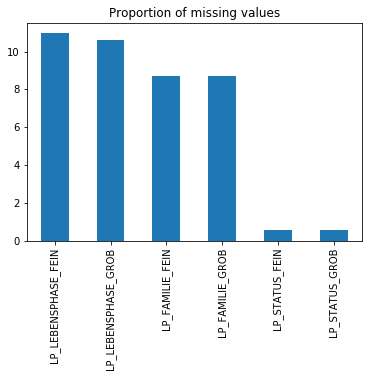

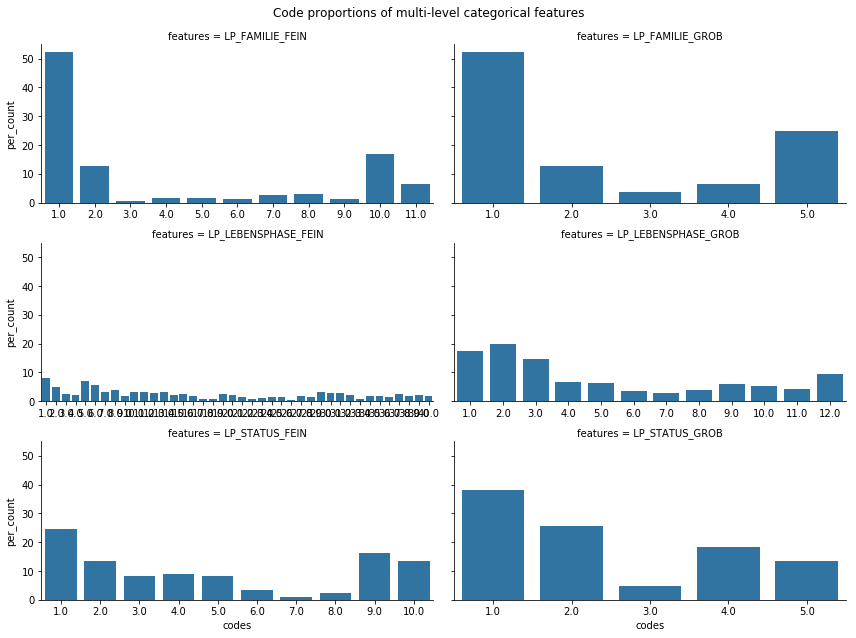

In [36]:
# check which categorical featuers with multilevel codes to drop
# select highly correlated categorical features (fine & rough scales)
cat_feat_corr = pd.Index([feat for feat in azdias_encoded.columns if re.search(r'^LP_.*$', feat)])

# check proportion of of missing values in features
((azdias_encoded[cat_feat_corr].isnull().sum() / azdias_encoded.index.size * 100)
 .plot(kind='bar', title='Proportion of missing values'))

# check code proportion distribution
cat_feat_info = (azdias_encoded[cat_feat_corr]
                 .melt(var_name='features', value_name='codes')
                 .groupby(['features', 'codes'])['codes'].count()
                 .reset_index(name='count'))

cat_feat_info['per_count'] = (cat_feat_info.groupby(['features'])    # group by missing values, features
                         ['count'].transform(                        # calculate codes relative counts
                         lambda group: group / group.sum() * 100 ))  # per group and feature 

# print code proportion distribution
g = sns.FacetGrid(cat_feat_info, col='features', col_wrap=2, sharex=False, height=3, aspect=2)
g = g.map(sns.barplot, 'codes', 'per_count')

# print title
title_height = 0.7                              # requested title height in inches
fig_height = g.fig.get_size_inches()[1]         # current figure height
top = (fig_height - title_height) / fig_height  # height of the subplot in % of figure height

plt.subplots_adjust(top=top)
g.fig.suptitle('Code proportions of multi-level categorical features');

In [37]:
# delete hihgly correlated categorical featuers with multilevel codes - rough scale
cat_feat_drop = pd.Index(
    [feat for feat in feat_info.loc[feat_info['type'] == 'categorical', 'attribute']
     if re.search(r'^LP_.*GROB$', feat)])
azdias_encoded = azdias_encoded.drop(columns=cat_feat_drop)

#### Discussion 1.2.1: Re-Encode Categorical Features
There are 49 ordinal, 21 categorical, 7 numeric, 7 mixed and 1 interval feature. There is one binary feature with non-metric codes which was numericaly encoded: 
 - `OST_WEST_KZ`: Building location via former East / West Germany (GDR / FRG) with respective levels
     - -1:  unknown -> np.nan
     -  O:  East (GDR) -> 0
     -  W:  West (FRG) -> 1

There are 16 multi-level categorical features which needs to be considered deleted or encoded. From those features there are several pairs with fine and rough scale respectively. Some of them are highly correlated as mapping between levels is defined in feature information. Those are:
- `LP_FAMILIE_FEIN` and `LP_FAMILIE_GROB` corresponding to family type
- `LP_STATUS_FEIN` and `LP_STATUS_GROB` corresponding to social status
- `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` corresponding to life stage

Both features in the pair represent same thing only with different granularity. As there is no big diffrence in proportion of missing values and codes proportion between pairs, I dediced to keep features with fine scales as using them can describe customer clusters in more detail and drop features with rough scales.

As only first two pairs are categorical only `LP_FAMILIE_GROB` and `LP_STATUS_GROB` are delted from dataset. `LP_LEBENSPHASE_GROB` will be dealt with in next step.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" "CAMEO_INTL_2015" and engineer two new variables.
# investigate mapping of codes to description
def get_new_codes(code, new_feat_pattern, code_details):
    '''
    Replaces mixed feature code by new feature code according code map
    
    Args:
        code: code corresponding to current mixed feature and sample in dataset 
        new_feat_pattern: encoding type and rule for current new feature as 
                          tuple of structure: (<enbcoding_type, encoding_rule)
        code_details: code detail corresponding to current mixed feature code as 
                      dictionary of structure: {current_mixed_feat_code: current_mixed_feat_code_detail}
    Returns: 
        code: encoded code = new feature code
    '''

    # get encoding type and rule
    encoding_type, encoding_rule = new_feat_pattern
    
    # if replace requested
    if encoding_type == 'replace':
        # get replacment mask
        mixed_feat_codes, new_feat_codes = encoding_rule
        
        # try to replace codes accroding mask
        try: 
            code = new_feat_codes[pd.Index(mixed_feat_codes).get_loc(code)]
            return code
        except IndexError as indx_err:
            print('Mixed feature code out of range of new codes:', ind_err)
        except ValueError as val_err:
            print('Mixed feature code not found:', val_err)
    
    # if encoding needs to be done in code using regex
    elif encoding_type == 'regex_code':
        try: code = re.search(encoding_rule, str(int(code)))
        except ValueError: code = re.search(encoding_rule, str(code))
    
    # if encoding needs to be done in code details description using regex
    elif encoding_type == 'regex_descr':
        # try to match regex in code details
        try: code = re.search(encoding_rule, code_details[str(int(code))])
        except ValueError: 
            try: code = re.search(encoding_rule, code_details[str(code)])
            except KeyError: return np.nan
        except KeyError: return np.nan
    
    # return matched code or missing value
    if code is None: code = np.nan
    else: 
        try: code = int(code.group(1))
        except: code = code.group(1)
    
    return code

def map_codes(mixed_feat_codes, new_feat_patterns, code_details):
    '''Creates dataframe mapping mixed feature codes to new features codes
    
    Args: 
        mixed_feat_codes: numpy array of unique mixed feature codes including nan code if available
        new_feat_patterns: dictionary of structure: {<feat_name_1>: (<enbcoding_type_1, encoding_rule_1),
                                                     <feat_name_2>: ...}
        code_details: dictionary of structure: {feat_code_1: code_detail,
                                                ...}
    Returns:
        code_map: Mapped mixed feature codes to new features codes as dataframe of shape 
                 (num_mixed_feat_codes, num_new_features) and index consisting of mixed feature codes'''
    
    # get number of mixed feature codes and new features
    num_mixed_codes, num_new_feats = len(mixed_feat_codes), len(new_feat_patterns)
    
    # initiate code map
    code_map = pd.DataFrame(
        data=np.tile(mixed_feat_codes.reshape(-1, 1), num_new_feats),
        columns=[new_feat for new_feat in new_feat_patterns],
        index=mixed_feat_codes)
    
    # fill and return the code map
    code_map = (code_map.apply(
        lambda new_feat: new_feat.apply(
            get_new_codes, args=(new_feat_patterns[new_feat.name], code_details))))
    
    # get new non numeric binary features from code map
    new_no_num_bin_feat = [
        feat for feat in code_map.columns
        if len(code_map[feat].groupby(code_map[feat]))==2 and code_map[feat].dtype.kind not in _NUMERIC_KINDS ]
    
    # encode new non numeric binary features in code map
    code_map[new_no_num_bin_feat] = (code_map[new_no_num_bin_feat].apply(
        lambda new_feat: new_feat.replace(
            [code for code in new_feat.groupby(new_feat).groups], 
            list(range(len(new_feat.groupby(new_feat).groups)))
        )))
    
    return code_map


def encode_mixed_feat(data, pattern_map, feat_details, inplace=False):
    '''
    Encode mixed features to new features and delete mixed features
    
    Args:
        data: dataset to be encoded of shape (n_cases, n_features) as pd.DataFrame
        pattern_map: encoding instructions in form of dictionary with structure:
                     {<mixed_feature_name_1>: {<new_feature_name_1: (<encoding_type_1>, <encoding_rule_1>},
                                               <new_feature_name_2: (<encoding_type-2>, <encoding_urle_2),
                                               ...},
                      <mixed_feature_name_2: {...},
                      ...}
        feat_details: mapping of feature names to details including long name and feature code description
                      in form of nested dictionary (see: map_feature_details function)
        inplace: do encoding of mixed feature in place, by default True
        
    Notes: There are 3 encoding types:
           'regex_descr': extracts new feature code from mixed code description using regex
           'regex_code': extracts new feature code from code itself using regex
           'replace': replaces codes by defining replacment rules
           
           There are 2 encoding rules:
           regular expression in form for r'<regular_expression>' for regex type encodings
           remplacment rule as tuple in form ([all mixed feature codes including missing values if any], 
           [all new codes including missing values if enocuntered in mixed feature]),where both of lists 
           need to have equal length
        
    Returns:
        encoded_data: encoded data including new featuers and excluding original mixed features in form of
                      pd.DataFrame
        
    '''
    
    # constants
    ENCODE_TYPES = {'regex_descr', 'regex_code', 'replace'}
    
    # check inputs
    # data
    assert isinstance(data, (pd.DataFrame, pd.Series)), 'Data needs to be pd.DataFrame or pd.Series'
    if isinstance(data, (pd.Series,)): data = data.to_frame()
    
    # pattern_map
    assert isinstance(pattern_map, dict), 'Pattern map needs to be a dictionary.'
    mixed_feats = [mixed_feat for mixed_feat in pattern_map]
    
    # existance of mixed features
    assert (mixed_feats is not None) and data.columns.isin(mixed_feats).sum() == len(mixed_feats), \
    'First level keys of pattern_map dictionary need to be subset of data column labels.'
    
    # pattern information
    for (mixed_feat, new_feat_patterns) in pattern_map.items():
        assert isinstance(new_feat_patterns, dict), \
        'Values of the pattern_map dictionary needs to be a dictionary. Happened at: pattern_map[{}]' \
        .format(mixed_feat)
        
        # encoding patterns
        for (new_feat, encoding_pattern) in new_feat_patterns.items():
            assert isinstance(encoding_pattern, tuple), \
            'Encoding patterns needs to be a tuple of (<encoding_type>, <encoding_rule>)'
            
            # matching of encoding type to encoding rule
            encoding_type, encoding_rule = encoding_pattern
            assert encoding_type in ENCODE_TYPES, \
            '{} is not one of encoding types {}'.format(encoding_type, ENCODE_TYPES)
            
            if encoding_type in {ENCODE_TYPE for ENCODE_TYPE in ENCODE_TYPES if 'regex' in ENCODE_TYPE}:
                assert isinstance(encoding_rule, str), \
                'Encoding rule needs to be a regular expression in form of r'<regex>' for {} encoding type' \
                .format(encoding_type)
                
            elif encoding_type == 'replace': 
                assert isinstance(encoding_rule, tuple) and len(encoding_rule) == 2, \
                '''Encoding rule needs to be a tuple for {} encoding type'''.format(encoding_type)
                
                mixed_feat_codes, new_feat_codes = encoding_rule
                assert isinstance(mixed_feat_codes, list) and isinstance(new_feat_codes, list) \
                       and len(mixed_feat_codes) == len(new_feat_codes), \
                '''Encoding rule needs to be a tuple of list of mixed feature codes 
                and list of new feature codes with same length for {} encoding type''' \
                .format(encoding_type) 
    
    # feature deatials
    assert (isinstance(feat_details, dict) and set(data.columns) <= set(feat_details.keys()) and \
            'long_name' in feat_details[list(feat_details.keys())[0]]) or feat_details is None, \
    '''feature details need to be a nested dictionary with 1st level keys matching data features names, 
    and have second level key "long_name".'''
    
    # inplace flag
    assert isinstance(inplace, bool)
    
    # get mixed features
    mixed_feats = [mixed_feat for mixed_feat in pattern_map]
    
    # initiate dataframe to store new variables
    new_data = pd.DataFrame(index=data.index)
    
    # cycle over mixed features
    for mixed_feat in mixed_feats:
        # get new mixed feature codes sorted by ascanding order
        mixed_feat_codes = data[mixed_feat].unique()
        
        # get mixed feature codes details
        code_details = feat_details[mixed_feat]['levels']
        
        # get new feature patterns
        new_feat_patterns = pattern_map[mixed_feat]
        
        # map mixed feature codes to codes of new features
        code_map = map_codes(mixed_feat_codes, new_feat_patterns, code_details)

        # create new features from mixed feature
        # initiate dataframe for new features
        new_feat_data = pd.DataFrame(
            data=np.tile(data[mixed_feat].values.reshape(-1, 1), len(new_feat_patterns)),
            columns=code_map.columns, 
            index=data.index)
        
        # encode mixed feature codes by new feature codes
        new_feat_data = new_feat_data.apply(
            lambda new_feat: new_feat.replace([*code_map.index], code_map[new_feat.name].values))

        # store encoded features
        new_data = pd.concat([new_data, new_feat_data], axis=1)
    
    # encode data in place if requested
    if inplace: encoded_data = data
    else: encoded_data = data.copy(deep=True)
    
    # drop mixed features and add encoded features to data
    encoded_data = pd.concat([encoded_data.drop(columns = [feat_name for feat_name in pattern_map]),
                      new_data], axis=1)
    
    return encoded_data

def print_encoding(pattern_map, data, encoded_data):
    '''
    Prints encoding table - mapping of mixed feature codes to new feature codes
    Args:
        pattern_map: mapping of mixed features to new featues and repspective patterns
        data: original data used for encoding as pd.DataFrame
        encoded_data: encoded data means original data after encoding as pd.DataFrame
    '''
    # make deep copy for temporary modification of encoded data
    encoded_temp_data = encoded_data.copy(deep=True)
    
    # cycle over mixed features
    for mixed_feat in pattern_map:
        # extract new encoded features corresponding to mixed feature
        new_feats = [new_feat for new_feat in pattern_map[mixed_feat]]
        
        # add mixed feature to respective new encoded features
        encoded_temp_data[mixed_feat] = data[mixed_feat]
        
        # generate & display map
        encoded_map = (encoded_temp_data[[mixed_feat, *new_feats]].astype(str)
                       .groupby([mixed_feat, *new_feats])
                       .size()
                       .reset_index(name='count')
                       .set_index(mixed_feat)
                       .sort_index(axis=0)
                      )
        display(encoded_map)
        
# map encoding patterns to mixed features and features with non-numerical codes (ref. see discussion below)
codes = azdias_encoded['CAMEO_DEU_2015'].unique().tolist()
new_codes = [np.nan if pd.isna(code) else 
             int(re.sub(r'\D', 
                        str(ord(re.search(r'\D', code).group(0)) - ord('A') + 1), 
                        code) 
                )
             for code in codes]

pattern_map = {'PRAEGENDE_JUGENDJAHRE': {'PRAEGENDE_DEKADE'      : ('regex_descr', r'(-?\d+\.?\d*)'),
                                         'PRAEGENDE_BEWEGUNG'    : ('regex_descr', r'(Avantgarde|Mainstream)')},
               'CAMEO_INTL_2015':       {'CAMEO_INTL_REICHTUM'   : ('regex_code', r'^(\d)\d$'),
                                         'CAMEO_INTL_LEBENSPHASE': ('regex_code', r'^\d(\d)$')},
               'WOHNLAGE':              {'NACHBARSCHAFT_QLT'     : ('regex_code', r'([1-5])'),
                                         'LANDLICHES_GEBIET'     : ('replace', 
                                                                    ([np.nan, 0, 1, 2, 3, 4, 5, 7, 8],
                                                                     [np.nan, 0, 0, 0, 0, 0, 0, 1, 1]))},
               'KBA05_BAUMAX':          {'KBA05_ANTG'            : ('replace', 
                                                                    ([np.nan, 1, 2, 3, 4, 5],
                                                                     [np.nan, 1, 2, 3, 4, 0])),
                                         'KBA05_GSFT'            : ('replace',
                                                                    ([np.nan, 1, 2, 3, 4, 5],
                                                                     [np.nan, 0, 0, 0, 0, 1]))},
               'PLZ8_BAUMAX':          {'PLZ8_ANTG'              : ('replace',
                                                                    ([np.nan, 1, 2, 3, 4, 5],
                                                                     [np.nan, 1, 2, 3, 4, 0])),
                                         'PLZ8_GSFT'             : ('replace',
                                                                    ([np.nan, 1, 2, 3, 4, 5],
                                                                     [np.nan, 0, 0, 0, 0, 1]))},
               'CAMEO_DEU_2015':       {'CAMEO_DEU_2015_ENC'     : ('replace',
                                                                    (codes,
                                                                     new_codes))}
              }

# encode mixed features
azdias_encoded = encode_mixed_feat(azdias_encoded, pattern_map, feat_details, inplace=True)

# print encoding tables
print_encoding(pattern_map, azdias_cnvrt, azdias_encoded)

PRAEGENDE_DEKADE PRAEGENDE_BEWEGUNG   count
PRAEGENDE_JUGENDJAHRE                                            
1.0                               40.0                1.0   21282
10.0                              80.0                1.0   85808
11.0                              80.0                0.0   35752
12.0                              80.0                1.0   24446
13.0                              80.0                0.0    5764
14.0                              90.0                1.0  188697
15.0                              90.0                0.0   42547
2.0                               40.0                0.0    7479
3.0                               50.0                1.0   55195
4.0                               50.0                0.0   20451
5.0                               60.0                1.0   86416
6.0                               60.0                0.0   25652
7.0                               60.0                0.0    4010
8.0                               70.0                1.0  145988
9.0                               70.0                0.0   33570
nan                                nan                nan  108164

CAMEO_INTL_REICHTUM CAMEO_INTL_LEBENSPHASE   count
CAMEO_INTL_2015                                                   
12.0                            1.0                    2.0   13249
13.0                            1.0                    3.0   26336
14.0                            1.0                    4.0   62884
15.0                            1.0                    5.0   16974
22.0                            2.0                    2.0   33155
23.0                            2.0                    3.0   26750
24.0                            2.0                    4.0   91158
25.0                            2.0                    5.0   39628
31.0                            3.0                    1.0   19024
32.0                            3.0                    2.0   10354
33.0                            3.0                    3.0    9935
34.0                            3.0                    4.0   18524
35.0                            3.0                    5.0   10356
41.0                            4.0                    1.0   92336
43.0                            4.0                    3.0   56672
44.0                            4.0                    4.0   14820
45.0                            4.0                    5.0   26132
51.0                            5.0                    1.0  133694
52.0                            5.0                    2.0   20542
54.0                            5.0                    4.0   45391
55.0                            5.0                    5.0   23955
nan                             nan                    nan   99352

NACHBARSCHAFT_QLT LANDLICHES_GEBIET   count
WOHNLAGE                                            
0.0                    nan               0.0    6950
1.0                    1.0               0.0   43918
2.0                    2.0               0.0  100376
3.0                    3.0               0.0  249719
4.0                    4.0               0.0  135973
5.0                    5.0               0.0   74346
7.0                    nan               1.0  169318
8.0                    nan               1.0   17473
nan                    nan               nan   93148

KBA05_ANTG KBA05_GSFT   count
KBA05_BAUMAX                              
1.0                 1.0        0.0  208417
2.0                 2.0        0.0    9684
3.0                 3.0        0.0   59955
4.0                 4.0        0.0   37718
5.0                 0.0        1.0   98923
nan                 nan        nan  476524

PLZ8_ANTG PLZ8_GSFT   count
PLZ8_BAUMAX                            
1.0               1.0       0.0  499550
2.0               2.0       0.0   70407
3.0               3.0       0.0   50732
4.0               4.0       0.0   56684
5.0               0.0       1.0   97333
nan               nan       nan  116515

CAMEO_DEU_2015_ENC  count
CAMEO_DEU_2015                          
1A                           11.0  10850
1B                           12.0   4071
1C                           13.0   4317
1D                           14.0  11909
1E                           15.0   5065
2A                           21.0  13249
2B                           22.0  15486
2C                           23.0  19422
2D                           24.0  35074
3A                           31.0  10543
3B                           32.0   7160
3C                           33.0  34769
3D                           34.0  34307
4A                           41.0  33155
4B                           42.0   9047
4C                           43.0  47819
4D                           44.0   8570
4E                           45.0   5321
5A                           51.0  12214
5B                           52.0  10354
5C                           53.0   9935
5D                           54.0  14943
5E                           55.0   3581
5F                           56.0   4283
6A                           61.0   6810
6B                           62.0  56672
6C                           63.0  14820
6D                           64.0   6073
6E                           65.0  16107
6F                           66.0   5392
7A                           71.0  34399
7B                           72.0  24503
7C                           73.0   9065
7D                           74.0   5333
7E                           75.0   4633
8A                           81.0  52438
8B                           82.0  33434
8C                           83.0  30993
8D                           84.0  17576
9A                           91.0  20542
9B                           92.0  27676
9C                           93.0  24987
9D                           94.0  28593
9E                           95.0   6379
nan                           nan  99352

#### Discussion 1.2.2.1: Engineer Mixed-Type Features
There are 7 mixed features and following engineering decision has been made:

##### `PRAEGENDE_JUGENDJAHRE` : Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
Feature re-engineered to:
 - `PRAEGENDE_DEKADE`: Generation decade, levels 40's to 90's, interval type
 - `PRAEGENDE_BEWEGUNG`: Movement, levels {0: Avantgarde, 1: Mainstream}, binary type
 
##### `CAMEO_INTL_2015`: German CAMEO: Wealth / Life Stage Typology, mapped to international code
Feature is re-engineered to:
 - `CAMEO_INTL_REICHTUM`: Households wealth, levels from poor to wealthy, levels 1st digit, ordinal type
 - `CAMEO_INTL_LEBENSPHASE`: Life stage typology, levels 2nd digit, nominal type
 
##### `KBA05_BAUMAX`: Most common building type within the microcell, `PLZ8_BAUMAX`: Most common building type within the PLZ8 region 
Both features have same scale, which is in nature ordinal except of code 5: "mainly business buildings" which is nominal. To transform scale from nominal to ordinal to following re-engineering is necessary:
 - `KBA05_ANTG`: Number of family homes in microcell, levels {0: 0, 1: 1-2, 2: 3-5, 3: 6-10, 4: 10+}, ordinal type
 - `KBA05_GSFT`: Mainly business buildings in microcell, levels {0: No, 1: Yes}, binary type
 - `PLZ8_ANTG`: Number of family homes in PLZ8 region, levels {0: 0, 1: 1-2, 2: 3-5, 3: 6-10, 4: 10+}, ordinal type
 - `PLZ8_GSFT`: Mainly business buildings in PLZ8 region, levels {0: No, 1: Yes}, binary type
 
#####  `LP_LEBENSPHASE_FEIN`: Life stage, fine scale, `LP_LEBENSPHASE_GROB`: Life stage, rough scale 
Life stage fine scale feature is composite measure consisting of 3 features in dataset
 - `LP_FAMILY_GROB`: Family type rough scale
 - `LP_STATUS_GROB`: Social status rough scale
 - `ALTERKATEGORIE_GROB`: Estimated age based on given name

Life stage rough scale is deduced from fine scale version. It it safe to delete both features as underlying information they have been created from will remain in dataset (only in form of fine scales, rough scales will be deleted)

##### `WOHNLAGE`: Neighborhood quality (or rural flag)
Feature include neighborhood quality score with ordinal scale (codes 1-5) and rural flag with nominal scale(codes 7-8). It is re-engineered to:
- `NACHBARSCHAFT_QLT`: Neighborhood quality, levels {nan: 0, 7-8 original codeds, 1-5: 1-5 original codes}, ordinal type
- `LANDLICHES_GEBIET`: Rural neighborhood flag, levels {0: No (0-5 orignal codes), 1: YES (7-8 original codes)}, binary type

#### Discussion 1.2.2.2: Engineer Multi-Level Categorical Features with Non Numeric Codes
##### `CAMEO_DEU_2015`: German CAMEO: Wealth / Life Stage Typology, detailed scale
Feature codes are mappings to `CAMEO_DEUG_2015` rough scale numerical codes with added detail representing letters A-E. It is re-engineered to:
- `CAMEO_DEU_2015_ENC`: levels {XX: 1st position represent numerical rough scale code of `CAMEO_DEUG_2015` and 2nd position is mapped as A: 1, B: 2,... E: 5}

#### Discussion 1.2.2.3: Delete Highly Collinear Features
Highly collinear features (the ones with association/correlation coefficients > 0.999) are causing convergence problems of multiple imputation algorithms and should be deleted but with caution consideration of each pair of features. Which one from pair to delete is decided by following priorities:
- 1. number of other features the inspected feature is highly correlated with
- 2. conceptual information of the feature
- 3. information amount in scale: ordinal, binary, multilevel not ordered
- 4. number of levels/codes
- 5. amount of missing data

##### `CAMEO_DEU_2015_ENC`: German CAMEO: Wealth / Life Stage Typology, detailed scale encoded to numerical levels
Even if engineered to numerical scale previously this feature is highly correlated with 3 other features
- 1. `CAMEO_INTL_LEBENSPHASE`: Life stage typology, 2nd digit of CAMEO_INTL_2015 levels, nominal type
- 2. `CAMEO_INTL_REICHTUM`: Households wealth, levels from poor to wealthy, 1st digit of CAMEO_INTL_2015 levels, ordinal type
- 3. `CAMEO_DEUG_2015`: German CAMEO: Wealth / Life Stage Typology, rought scale

This seems to be coposite measure of life stage typology and househould wealth, resulting in 44 different levels which are then simplify in rough scale `CAMEO_DEUG_2015`. I will delete the feature as conceptual information will stay in dataset in form of other correlated variables and it will greatly reduce computation time of multiple imputation cut by 44 hot encoded variables.

##### `PRAEGENDE_BEWEGUNG`: Movement, levels {0: Avantgarde, 1: Mainstream}, binary type
It is highly correlated with `GREEN_AVANTGARDE` Membership in environmental sustainability as part of youth.
Both are the binary features and assuming that code 0: not a member of green avantgarde is equal to code 0: mainstream, I decide to delete `PRAEGENDE_BEWEGUNG` as it has 10% of missing data opposte to`GREEN_VANTGARDE` with all valid cases.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [39]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# delete mixed composite features
azdias_encoded = azdias_encoded.drop(columns=['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], errors='ignore')

In [40]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# udpate new features information
# prepare
new_to_mixed_feat = {new_feat: mixed_feat for mixed_feat in pattern_map for new_feat in pattern_map[mixed_feat]}
new_feats = [new_feat for new_feat in new_to_mixed_feat]
attribute = new_feats
information_level = [feat_info.set_index('attribute').loc[new_to_mixed_feat[new_feat], 'information_level'] 
                     for new_feat in new_feats]
attr_types = ['interval', 'categorical', 
             'ordinal', 'categorical', 
             'ordinal', 'categorical', 'ordinal', 'categorical',
             'ordinal', 'categorical',
             'categorical']
missing_or_unknown = [np.nan] * len(new_feats)
unique_codes = [len(azdias_encoded[new_feat].groupby(azdias_encoded[new_feat]).groups) 
                if attr_type == 'categorical' else np.nan 
                for new_feat, attr_type in zip(new_feats, attr_types)]
categorical_type = ['unary' if num_codes == 1 else 
                    'binary' if num_codes == 2 else 
                    'multi-level' if num_codes > 2 else num_codes
                    for attr_type, num_codes in zip(attr_types, unique_codes)]
code_type = ['numeric' if azdias_encoded[new_feat].dtype.kind in _NUMERIC_KINDS else 'non-numeric'
             for new_feat in new_feats]

# consolidate
new_feat_info = np.array([attribute, information_level, attr_types, missing_or_unknown, 
                          unique_codes, categorical_type, code_type]).T

# update 
new_feat_info = pd.DataFrame(new_feat_info, columns=feat_info.columns)
feat_info = pd.concat([feat_info, new_feat_info], axis=0, ignore_index=True)

# set categorical variables to category dtype
cat_feats = [feat for feat in azdias_encoded.columns 
             if feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].isin([feat]).any()]

azdias_encoded[cat_feats] = azdias_encoded[cat_feats].astype('category')

In [41]:
# load MCAR test resutls from HDF5 file
items = ['p_values', 'num_cases_valid_data', 'num_cases_missing_data',
         'num_cases_power80', 'num_cases_used' ]
store = pd.HDFStore('temp_data.h5')
mcar_test_results = {item: store[item] for item in items}

In [42]:
# explore test results tables
@interact(mcar_descr_item=[*mcar_test_results.keys()])
def print_missing_at_random(mcar_descr_item='p_values'):
    format_str = '{:.2f}' if mcar_descr_item == 'p_values' else '{:.0f}'
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
                           'display.float_format', format_str.format):
        display(mcar_test_results[mcar_descr_item])

interactive(children=(Dropdown(description='mcar_descr_item', options=('p_values', 'num_cases_valid_data', 'nu…

In [43]:
# explore test results heatmaps
@interact(mcar_descr_item=[*mcar_test_results.keys()])
def show_mcar(mcar_descr_item='p_values'):
    '''
    Displays heatmap of choosen result item from missing comletely at random test 
    
    Args:
        mar_descr_item is arbitrary key of dictionary output from missing_at_random function
        'p_values': p values of missing value randomness test as dataframe of shape (# of features, # of features)
        'num_cases_valid_data': number of samples of valid values group as dataframe of shape (# of features, # of features)
        'num_cases_missing_data': number of samples of missing values group as dataframe of shape(# of features, # of features)
        'num_cases_power80': min number of samples to have statistical power 80% as dataframe of shape(# of features, # of features)
        'num_cases_used': min number of samples used to calculate statistical test
    '''
    # create deep copy of data in case they need to be transformed
    data = mcar_test_results[mcar_descr_item].copy(deep=True)
    
    # transform p_values to emphesize significance in heatmap
    if mcar_descr_item == 'p_values':
        # p value limits
        p_min, p_signf, p_border, p_max = 0, 0.05, 0.1, 1
        vmin, vmax = p_min, p_max
        
        # create descrete scale to distingish sifnificant diffrences (p<=0.05) from bordeline (p(0.05, 0.1>) and 
        # not_significant p>0.1 
        data = data.apply(
            lambda col: pd.to_numeric(pd.cut(col, [p_min, p_signf, p_max], labels=[p_signf, p_max])))
        
        # plot heat map
        fig = plt.figure(figsize=(20,20))
        sns.heatmap(data, ax=fig.gca(), cmap='viridis', vmin=vmin, vmax=vmax, square=True);
    
    # if sample sizes are requested trasnform color bar scale to logaritmic
    else: 
        # get scale range from all sample size description items
        min_vmin = 0.1 # acount for log 0 exception
        vmin, vmax = (min([mcar_test_results[item].values.min() for item in mcar_test_results if 'num' in item]),
                      max([mcar_test_results[item].values.max() for item in mcar_test_results if 'num' in item]))
        
        # logaritmicly scale and annotate colormap
        log_norm = LogNorm(vmin=vmin, vmax=vmax)
        cbar_ticks = [math.pow(10, i) for i in range(
            math.floor(math.log10(max(min_vmin, vmin ))), 1+math.ceil(math.log10(vmax)))]
        
        # plot heat map
        fig = plt.figure(figsize=(20,20))
        sns.heatmap(data+10e-1, ax=fig.gca(), cmap='viridis', vmin=max(min_vmin, vmin), vmax=vmax, square=True,
                    norm=log_norm, cbar_kws={"ticks": cbar_ticks});
    
    # annotate heatmap
    plt.title('''Assesing the randomness of missing data trough group comparisons of observations 
              with missing vs. valid data - parameter: {}'''. format(mcar_descr_item))
    plt.show()

interactive(children=(Dropdown(description='mcar_descr_item', options=('p_values', 'num_cases_valid_data', 'nu…

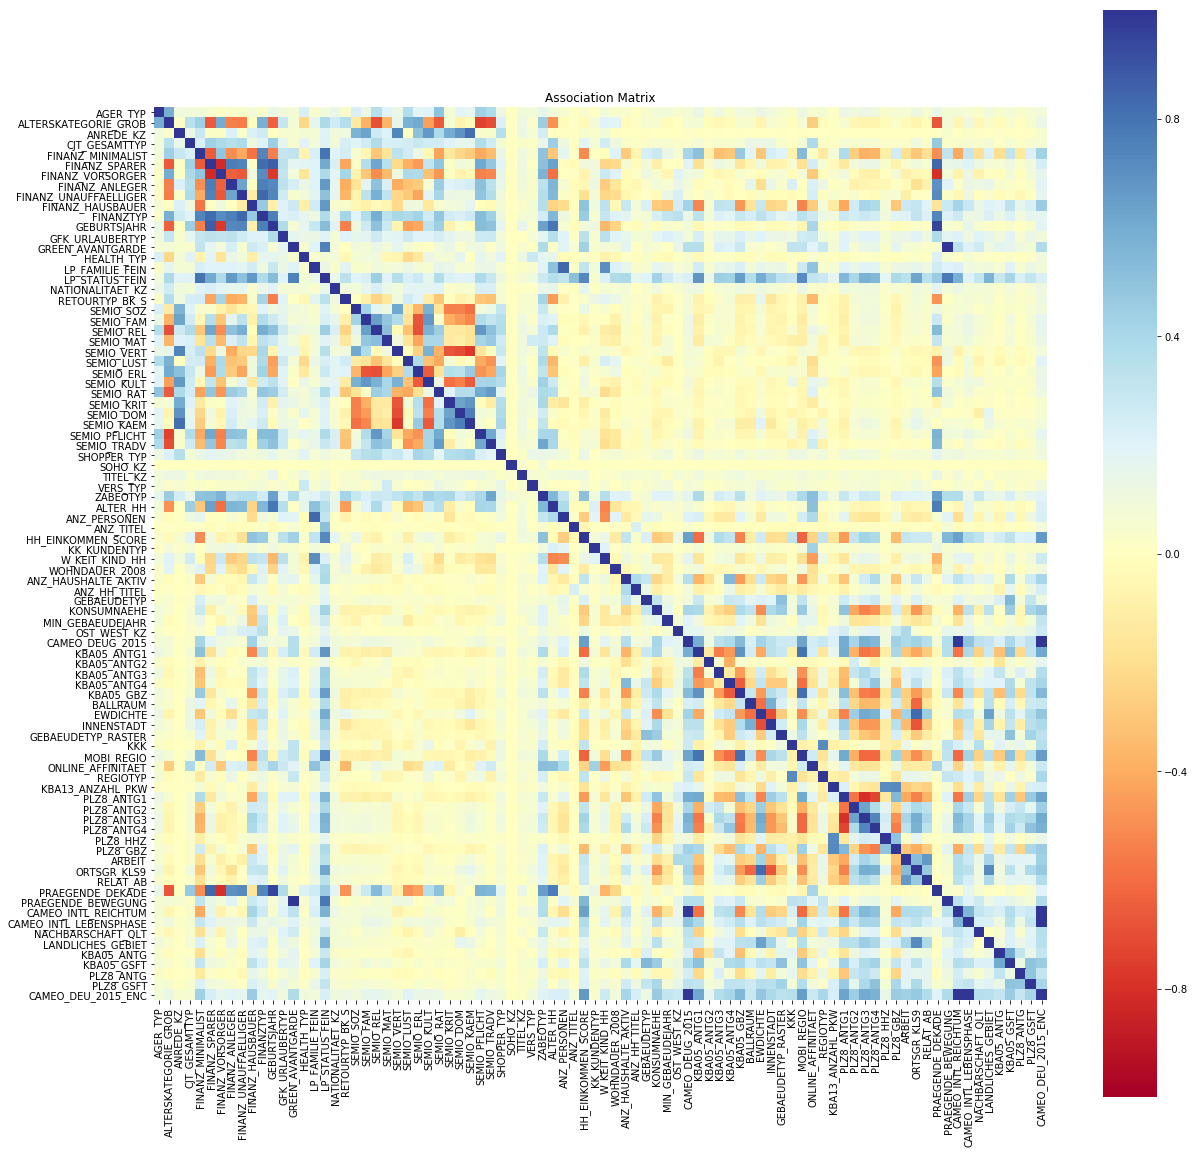

In [44]:
# load association matrix from HDF5 file
store = pd.HDFStore('temp_data.h5')
corr = store['corr']

# print association heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr, cmap='RdYlBu', vmin=-1, vmax=1, square=True)
plt.title('Association Matrix')
plt.show()

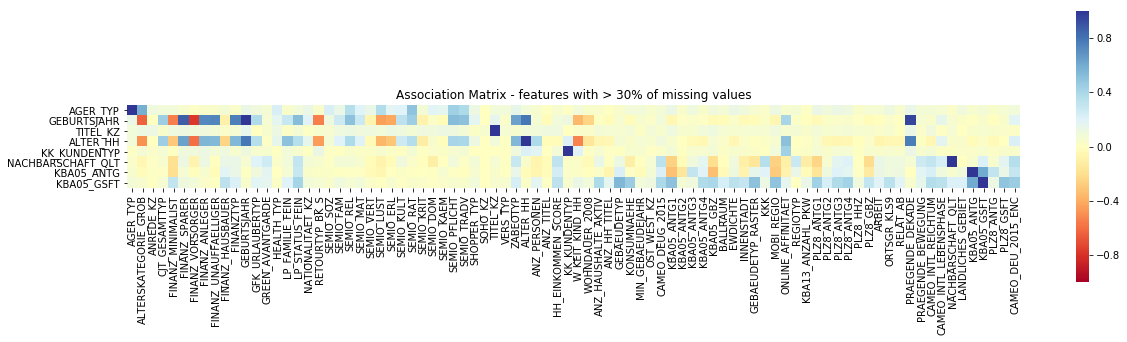

In [45]:
# filter features with > drop_treshold(30%) of missing values
feat_drop = azdias_encoded.columns[
    (azdias_encoded.isna().sum() / azdias_encoded.index.size * 100) >= drop_treshold]
corr_drop = pd.DataFrame(corr.values, columns = azdias_encoded.columns, index=azdias_encoded.columns).loc[feat_drop]

# filter association heatmap for features with high % of missign values
plt.figure(figsize=(20, 5))
sns.heatmap(corr_drop, cmap='RdYlBu', vmin=-1, vmax=1, square=True)
plt.title('Association Matrix - features with > {}% of missing values'.format(drop_treshold))
plt.show()

In [46]:
feat_drop

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'NACHBARSCHAFT_QLT', 'KBA05_ANTG', 'KBA05_GSFT'],
      dtype='object')

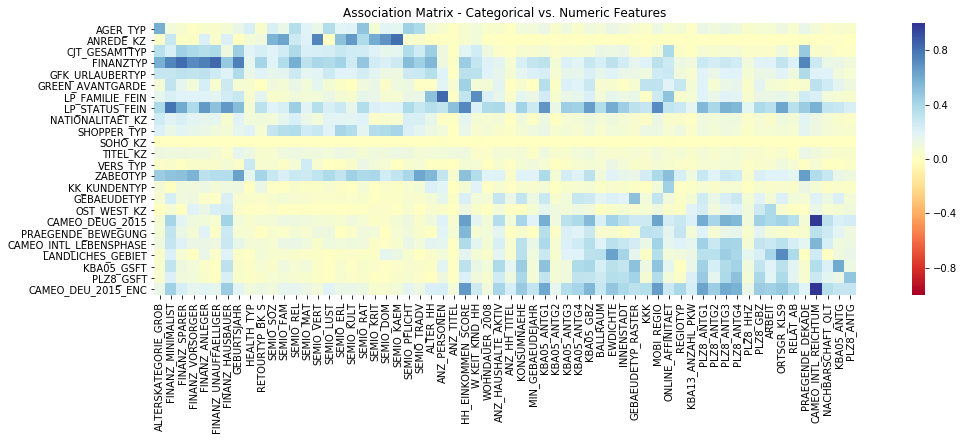

In [47]:
# filter categorical and numerical features
cat_feats = azdias_encoded.select_dtypes('category').columns
num_feats = azdias_encoded.select_dtypes('number').columns
cat_corr = (
    pd.DataFrame(corr.values, columns = azdias_encoded.columns, index=azdias_encoded.columns)
    .loc[cat_feats, num_feats]
)

# filter association heatmap for features with high % of missign values
plt.figure(figsize=(20, 5))
sns.heatmap(cat_corr, cmap='RdYlBu', vmin=-1, vmax=1, square=True)
plt.title('Association Matrix - Categorical vs. Numeric Features')
plt.show()

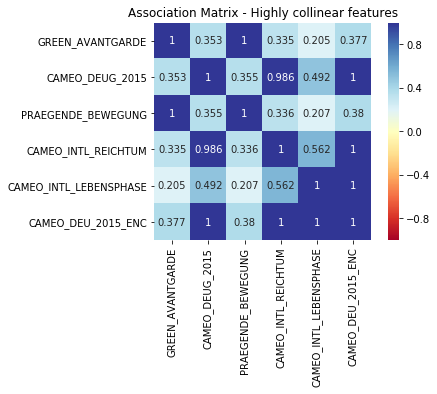

information_level         type missing_or_unknown  \
CAMEO_DEUG_2015            microcell_rr4  categorical             [-1,X]   
CAMEO_DEU_2015             microcell_rr4  categorical               [XX]   
CAMEO_DEU_2015_ENC         microcell_rr4  categorical                nan   
CAMEO_INTL_2015            microcell_rr4        mixed            [-1,XX]   
CAMEO_INTL_LEBENSPHASE     microcell_rr4  categorical                nan   
CAMEO_INTL_REICHTUM        microcell_rr4      ordinal                nan   
GREEN_AVANTGARDE                  person  categorical                 []   
PRAEGENDE_BEWEGUNG                person  categorical                nan   
PRAEGENDE_JUGENDJAHRE             person        mixed             [-1,0]   

                       unique_codes categorical_type    code_type  
CAMEO_DEUG_2015                   9      multi-level      numeric  
CAMEO_DEU_2015                   44      multi-level  non-numeric  
CAMEO_DEU_2015_ENC               44      multi-level      numeric  
CAMEO_INTL_2015                 NaN              NaN      numeric  
CAMEO_INTL_LEBENSPHASE            5      multi-level      numeric  
CAMEO_INTL_REICHTUM             nan              nan      numeric  
GREEN_AVANTGARDE                  2           binary      numeric  
PRAEGENDE_BEWEGUNG                2           binary      numeric  
PRAEGENDE_JUGENDJAHRE           NaN              NaN      numeric

GREEN_AVANTGARDE           0.000000
CAMEO_DEUG_2015           11.147852
PRAEGENDE_BEWEGUNG        12.136608
CAMEO_INTL_REICHTUM       11.147852
CAMEO_INTL_LEBENSPHASE    11.147852
CAMEO_DEU_2015_ENC        11.147852
Name: per_nan_values, dtype: float64

CAMEO_INTL_2015: German CAMEO: Wealth / Life Stage Typology, mapped to international code 
levels:{'-1': 'unknown', '11': 'Wealthy Households - Pre-Family Couples & Singles', '12': 'Wealthy Households - Young Couples With Children', '13': 'Wealthy Households - Families With School Age Children', '14': 'Wealthy Households - Older Families & Mature Couples', '15': 'Wealthy Households - Elders In Retirement', '21': 'Prosperous Households - Pre-Family Couples & Singles', '22': 'Prosperous Households - Young Couples With Children', '23': 'Prosperous Households - Families With School Age Children', '24': 'Prosperous Households - Older Families & Mature Couples', '25': 'Prosperous Households - Elders In Retirement', '31': 'Comfortable Households - Pre-Family Couples & Singles', '32': 'Comfortable Households - Young Couples With Children', '33': 'Comfortable Households - Families With School Age Children', '34': 'Comfortable Households - Older Families & Mature Couples', '35': 'Comfortable Hou

In [48]:
# delete highly collinear features to prevent divergence of multiple imputation methods like MICE and EMB.
max_cor = 0.999
collin_feats = corr.index[(max_cor <= corr).sum() > 1]

# plot association matrix with highly collinear features
sns.heatmap(corr.loc[collin_feats, collin_feats], annot=True, fmt='.3g', cmap='RdYlBu', vmin=-1, vmax=1, square=True)
plt.title('Association Matrix - Highly collinear features')
plt.show()

# inspect highly collinear features
org_inspect_feats = pd.Index(['CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'PRAEGENDE_JUGENDJAHRE' ])
inspect_feats = org_inspect_feats.union(collin_feats)
display(feat_info.set_index('attribute').loc[inspect_feats])
display((azdias_encoded[collin_feats].isna().sum() / azdias_encoded.index.size * 100).rename('per_nan_values'))
print_feat_details(org_inspect_feats.tolist(), feat_details, verbose=True)

In [49]:
# drop highly collinear features
collin_feats = pd.Index(['CAMEO_DEU_2015_ENC', 'PRAEGENDE_BEWEGUNG'])

# drop features with high % of missing values
azdias_drop_feats = azdias_encoded.drop(columns=feat_drop.union(collin_feats), errors='ignore')

# drop cases with high % of missing values, to improve imputation rmse and accuracy
cases_drop = azdias_encoded.index[
    (azdias_encoded.isna().sum(axis=1) / azdias_encoded.columns.size * 100) >= drop_treshold
]
azdias_drop = azdias_drop_feats.drop(index=cases_drop, errors='ignore')

# save data for imputation to HDF5 file:
azdias_drop.to_hdf('imp_data.h5', 'imp_0_full', format='table')

In [50]:
# MICE IMPUTATION DEPENDENCES
# ---------------------------  
def df2odr(data, verbose=False):
    '''
    Convert pandas dataframe to r ordered dictionary of pairs (feat_name, feat_vector).
    Category dtype is casted as factorVector. It considers missing values 
    (original py2ri function of rpy2 can't handle this properly so far)
    
    Args:
        data: pandas dataframe of shape (# samples, # features)
    
    Returns:
        odr: r ordered dictionary of length # of features of pairs (feat_name, feat_vector).
    '''
    # check arguments
    assert isinstance(data, pd.DataFrame), 'Argument df need to be a pd.Dataframe.'
    
    # create deep copy of the dataframe as it will be altered
    df = data.copy(deep=True)
    
    # transform dataset to r dataframe
    feat_vectors = []
    for feat in df.columns:
        if df[feat].dtype.name == 'category':
            # recast missing values from numpy to r for categorical features
            df[feat].cat.add_categories(NA_Character, inplace=True)
            df[feat].fillna(NA_Character, inplace=True)
            vct = FactorVector(StrVector(tuple(df[feat])))
            vct.names = IntVector(df.index)
            feat_vectors.append((feat, vct))

        # for numberic features recasting not needed
        elif df[feat].dtype.kind in _NUMERIC_KINDS:
            vct = FloatVector(tuple(df[feat]))
            vct.names = IntVector(df.index)
            feat_vectors.append((feat, vct))
        else:
            vct = StrVector(tuple(df[feat]))
            feat_vectors.append(feat, I(vct))

    return rlc.OrdDict(feat_vectors)
    
def df2dfr(df):
    '''
    Convert pandas dataframe to r dataframe. Category dtype is casted as factorVector
    considering missing values (original py2ri function of rpy2 can't handle this properly so far)
    
    Args:
        df: pandas dataframe of shape (# samples, # features)
    
    Returns:
        dfr: r datafraem of shape (# sampels, # features)
    '''
    # check arguments
    assert isinstance(df, pd.DataFrame), 'Argument df need to be a pd.Dataframe.'
    
    # create r ordered dictionary with feat name and r vector pairs
    dfr = df2odr(df)

    # create r dataframe
    return DataFrame(dfr)   

def dfr2df(dfr, dtypes=None):
    '''
    Convert r dataframe to pandas dataframe. FactorVector is casted as category type.
    
    Args: 
        dfr: r dataframe of shape (# samples, # features)
        dtypes: dtypes of the dataframe to cast columns to as pd.Series of dtypes
    
    Returns:
        df: pd.Dataframe of shape (# samples, # features)
    '''
    # if not requested read dtypes from r dataframe
    rownames = list(map(int, list(dfr.rownames)))
    if dtypes is None: 
        dt = {col_name: pd.Series(pd.Categorical([float(column.levels[i-1]) for i in column]), index=rownames) 
              if column.rclass[0] == 'factor' else pd.Series(list(column), index=rownames)
              for column, col_name in zip(dfr, dfr.names)}
        
        df = pd.DataFrame(dt)
    
    # if requested read dtypes from dtypes
    else:
        dt = [(col_name, pd.Series([float(column.levels[i-1]) for i in column], index=rownames, dtype=dtype) 
              if column.rclass[0] == 'factor' else pd.Series(list(column), index=rownames, dtype=dtype))
              for column, col_name, dtype in zip(dfr, dfr.names, dtypes)]

        df = pd.DataFrame.from_items(dt) 
    
    return df

def df2mtr(df):
    '''
    Convert pandas dataframe to r matrix. Category dtype is casted as factorVector
    considering missing values (original py2ri function of rpy2 can't handle this properly so far)
    
    Args:
        data: pandas dataframe of shape (# samples, # features) with numeric dtype
    
    Returns:
        mtr: r matrix of shape (# samples # features)
    '''
    # check arguments
    assert isinstance(df, pd.DataFrame), 'Argument df need to be a pd.Dataframe.'
    
    # select only numeric columns
    df = df.select_dtypes('number')

    # create and return r matrix
    values = FloatVector(df.values.flatten())
    dimnames = ListVector(rlc.OrdDict([('index', StrVector(tuple(df.index))),
                                      ('columns', StrVector(tuple(df.columns)))]))
    return robjects.r.matrix(values, nrow=len(df.index), ncol=len(df.columns), 
                             dimnames = dimnames, byrow=True)

def mtr2df(mtr):
    '''
    Convert r matrix to pandas dataframe. 
    
    Args:
        data: r matrix of shape (# samples # features)
    
    Returns: 
        mtr: pandas dataframe of shape (# samples, # features) 
    '''
    # check arguments
    assert isinstance(mtr, rpy2.robjects.vectors.Matrix), 'Argument df need to be robjects.vectors.Matrix.'

    # create and return dataframe
    return pd.DataFrame(np.array(mtr), index=list(mtr.rownames), columns=list(mtr.colnames))

def get_puc_matrix(df):
    '''
    Calculates proportion of usable cases matrix
        
    Args:
        df: data in form of pd.DataFrame of shape (# samples, # features)
    
    Return:
        puc_df: proportion of usable cases in form of pd.DataFrame of shape(# features, # features)
    '''
    # check arguments
    assert isinstance(df, pd.DataFrame), 'Argument df need to be a pd.Dataframe.'
    
    # transform pd.DataFrame to r dataframe
    dfr = df2dfr(df)
    
    # calculate puc matrix as r dataframe
    mdpairs = robjects.r('md.pairs')
    p = mdpairs(dfr)
    ps = p.rx2('mr').ro + p.rx2('mm')
    pp = p.rx2('mr').ro / ps

    # return puc matrix in form of pd.Dataframe
    return pd.DataFrame(pandas2ri.ri2py(pp),
                        index = df.columns,
                        columns = df.columns)

def quickpred(df, min_puc=0, min_cor=0.1, include=None, exclude=None, cor_df=None):
    '''
    Selects predictors accordint to simple statistics (adapted from MICE quickpred function)
    
    Args:
        df: pd.Dataframe frame with incomplete data of shape (# samples, # features)
        mincor: scalar specifying the mininmum treshold against which the 
                absolute corelation in data is compared
        minpuc: scalar specifying the minimum teshold for the proportion of usable cases
        include: list of one or more feature names which will be always included as predictor
        excluded: list of one or more feature names which will be always excluded as predictor
        cor_df: correlation matrix in form of dataframe of size # features, by default None
    
    Return:
        pred_df: A square pd.DataFrame of size len(df.columns)
    
    Note: Correlation matrix can be provided to speed up optimization.
    '''
    # check arguments
    assert isinstance(df, pd.DataFrame), 'Argument df need to be a pd.Dataframe.'
    assert (0 <= mincor <= 1) and (0 <= minpuc <=1), 'mincor and minpuc need to be in range of <0, 1>.'
    
    if include is not None: 
        assert isinstance(include, list) and set(include).issubset(df.columns), \
        'Include needs to be subset list of features in dataframe.'
    
    if exclude is not None: 
        assert isinstance(exclude, list) and set(exclude).issubset(df.columns), \
        'include needs to be subset list of features in dataframe.'
        
    if (include is not None) and (exclude is not None):
        assert not bool(set(include) & set(exclude)), \
        'include and exclude can not consist the same feature(s) {}'.format(set(include) & set(exclude))

    if cor_df is not None:
        assert isinstance(cor_df, pd.DataFrame) and \
               cor_df.index.identical(df.columns) and cor_df.columns.identical(cor_df.columns), \
        'correlation matrix need to be pd.Dataframe of size # of features'
    
    # limits for minimum and maximum nuber of predictors
    min_pred, max_pred = (10, 10)
    
    # calculate portion of usable cases
    puc_df = get_puc_matrix(df)

    # calculate association matrix
    if cor_df is None: 
        cor_df = associations_test(data, nominal_columns=[*data.select_dtypes('category').columns], 
                                   mark_columns=False, return_results=True, plot=False)
    
    # calculate predictors matrix (1 inculded, 0 excluded)
    pred_df = (
        ((min_puc <= puc_df) & (min_cor <= np.abs(cor_df)))
        .astype(int)
    )
    
    # adjust predictor matrix to comply with # of predictors limits
    # -------------------------------------------------------------
    # get features with no missing values
    no_nan_feats = df.columns[~df.isna().any()]
    
    # calculate number of predictors
    num_pred = pred_df.sum(axis=1)
    
    # get features outside of # of predictors limits
    out_feats = pred_df.columns[((num_pred <= min_pred) | (max_pred <= num_pred)).values]
    out_feats = out_feats.drop(no_nan_feats)
    
    # calculate composite measure as harmonic mean 2*puc*cor/(puc+cor)
    com_df = 2 * puc_df * cor_df / (puc_df + cor_df)
    
    for feat in pred_df.columns.drop(no_nan_feats): # out_feats:
        # get top-k predictors with highest composite measure
        topk = min_pred if num_pred[feat] <= min_pred else max_pred
        preds = com_df.loc[feat].nlargest(topk).index
        
        # update predictors matrix
        pred_df.loc[feat] = 0
        pred_df.loc[feat, preds] = 1
    
    # include requested features to be predictors for all imputed features
    if include is not None:
        for feat in include:
            pred_df.loc[:, feat] = 1
            pred_df.loc[feat, feat] = 0
    
    if exclude is not None: pred_df.loc[:, exclude] = 0
    
    # return predictor binary r and association matrix
    return pred_df

def get_quickpredict_params(df, puc_space=(0.05, 0.95, 19), cor_space=(0.05, 0.95, 19), cor_df=None, plot=True):
    '''
    Calculate optimal parameters for quickpredict method of MICE package to comply with 
    MICE documentation recommendation to have predictors in range of 15-25 to prevent
    computational problems (ref van Burren et al.(1999))
    
    Args:
        df: pd.DataFrame of data of shape (# samples, # features)
        puc_space: space of the min proprotion of usable cases parameter
        cor_space: space of the min correlation/association coeficient parameter
        cor_df: correlation matrix in form of dataframe of size # features, by defult None
        plot: whether heatmap of the # predictors = f(puc, cor) should be plotted, True by default
    
    Return:
        opt_min_puc: optimal min proprtion of usable cases
        opt_min_cor: optimal min correlation/assocation coeficient
        cor_df: correlation matrix
    
    Note: Space is defined as tuple (min, max, # of steps), where min, max is in <0, 1>
    The objective function of optimization algorithm maximizes number of features
    with predictors in range <15-25>.
    Correlation matrix can be provided to speed up optimization.
    '''
    # check arguments
    assert isinstance(df, pd.DataFrame) and len(df.columns) >= 2, 'df need to be pd.DataFrame with at least 2 columns'
    
    ranges = np.array(list(set([*puc_space[:-1], *cor_space[:-1]])))
    assert np.any(0 < ranges) and np.any(ranges < 1), 'min and max bounds need to be in range (0, 1)'
    
    if cor_df is not None:
        assert isinstance(cor_df, pd.DataFrame)and \
               cor_df.index.identical(df.columns) and cor_df.columns.identical(cor_df.columns), \
        'correlation matrix need to be pd.Dataframe of size # of features'
    
    assert isinstance(plot, bool)
    
    # # of predictors range
    min_pred, max_pred = (15, 20)    
    
    # convert dataset to r dataframe
    dfr = df2dfr(df)
    
    # calculate portion of usable cases
    mdpairs = robjects.r('md.pairs')
    p = mdpairs(dfr)
    ps = p.rx2('mr').ro + p.rx2('mm')
    puc_dfr = p.rx2('mr').ro / ps
    puc_df = pd.DataFrame(pandas2ri.ri2py(puc_dfr),
                          index = list(puc_dfr.rownames),
                          columns = list(puc_dfr.colnames))

    # cacluclate association matrix
    if cor_df is None:
        cor_df = associations_test(df, nominal_columns=[*df.select_dtypes('category').columns], 
                                   mark_columns=False, return_results=True, plot=False)
    
    # set parameter spaces precision
    puc_prec= abs(math.floor(math.log10(abs((puc_space[1] - puc_space[0]) / puc_space[2]))))
    cor_prec = abs(math.floor(math.log10(abs((cor_space[1] - cor_space[0]) / cor_space[2]))))
    
    # expand parameter spaces
    puc_space = pd.Index(np.round(np.linspace(*puc_space), puc_prec), name='min_portion_of_usable_cases')    
    cor_space = pd.Index(np.round(np.linspace(*cor_space), cor_prec), name='min_association')    

    # optimize minimum proportion of usable cases and association coeficient
    opt_pred_df = pd.DataFrame(index=cor_space, columns=puc_space)
    for min_cor in cor_space:
        for min_puc in puc_space:
            # calculate number of predictors for each dependent variable
            # each predictor must have correlation and number of usable cases 
            # >= initcor and initpuc in respect to dependent variable
            num_pred = (
                ((min_puc <= puc_df) & (min_cor <= np.abs(cor_df)))
                .sum(axis=1)
                .rename('num_predictors')
            )

            # calculate number of dependent features with predictors in range <minpred, maxpred>
            spec_pred = (min_pred <= num_pred) & (num_pred <= max_pred)

            # dependent features in spec
            opt_pred_df.loc[min_cor, min_puc] = spec_pred[df.isna().any()].sum()
    
    # extract optimal parameters
    opt_min_puc, opt_min_cor = opt_pred_df.max().idxmax(), opt_pred_df.max(axis=1).idxmax()

    # print optimal parameters
    if plot:
        # show heatmap
        fig = plt.figure(figsize=(15, 15))
        sns.heatmap(opt_pred_df, ax=fig.gca(), square=True);
        plt.title('Optimal parameters for predictor selection: Num of features with predictors in range <{:.0f}, {:.0f}>'
                 .format(min_pred, max_pred));
        
        # print optimal parameters
        print('Optimal parameters: puc = {:.{puc_prec}f}, cor = {:.{cor_prec}f}'
              .format(opt_min_puc, opt_min_cor, puc_prec=puc_prec, cor_prec=cor_prec))
    
    return opt_min_puc, opt_min_cor, cor_df

Generating datasets...
----------------------
Parameter: frac_missing ---> Level: all  --->  2 datasets generated in 0 min 0.25 s
Parameter: n_samples    ---> Level: all  --->  6 datasets generated in 0 min 0.08 s
Parameter: n_feats      ---> Level: all  ---> 12 datasets generated in 0 min 0.10 s
Parameter: nan_process  ---> Level: mar  ---> 12 datasets generated in 1 min 16.31 s
Parameter: nan_process  ---> Level: mnar ---> 12 datasets generated in 1 min 15.46 s

Imputing datasets...
--------------------


frac_missing n_samples n_feats nan_process methods       rmse       acc  \
run                                                                            
1             0.1       800      60         mar     knn   3.072156       NaN   
2             0.1       800      60        mnar     knn   2.483277       NaN   
3             0.1       800     151         mar     knn   2.014048  0.702703   
4             0.1       800     151        mnar     knn   2.391342  0.750000   
5             0.1      1600      60         mar     knn  22.073161       NaN   
6             0.1      1600      60        mnar     knn  72.140186       NaN   
7             0.1      1600     151         mar     knn   2.176673  0.691824   
8             0.1      1600     151        mnar     knn   2.140433  0.696721   
9             0.1      3200      60         mar     knn  36.513885       NaN   
10            0.1      3200      60        mnar     knn  46.837377       NaN   
11            0.1      3200     151         mar     knn  43.315306  0.676471   
12            0.1      3200     151        mnar     knn  68.473334  0.684825   
13            0.3       800      60         mar     knn   2.050631       NaN   
14            0.3       800      60        mnar     knn   2.179171       NaN   
15            0.3       800     151         mar     knn   2.589479  0.715278   
16            0.3       800     151        mnar     knn   2.045534  0.718213   
17            0.3      1600      60         mar     knn  47.211494       NaN   
18            0.3      1600      60        mnar     knn  51.927516       NaN   
19            0.3      1600     151         mar     knn   2.152313  0.695402   
20            0.3      1600     151        mnar     knn   2.157602  0.701266   
21            0.3      3200      60         mar     knn  43.951006       NaN   
22            0.3      3200      60        mnar     knn  51.700082       NaN   
23            0.3      3200     151         mar     knn  28.495662  0.670534   
24            0.3      3200     151        mnar     knn  43.095393  0.696352   

     rmse_uavg   acc_sub       time  
run                                  
1     0.632145       NaN   1.237071  
2     0.514303       NaN   1.080062  
3     0.473432  0.270270   2.256129  
4     0.587982  0.392857   2.462141  
5     5.722905       NaN   4.392251  
6    17.539607       NaN   3.739214  
7     0.470538  0.464789   5.410310  
8     0.458383  0.448276   4.713270  
9     8.371779       NaN  10.896623  
10   10.898822       NaN  10.803618  
11   10.045456  0.447552  17.494001  
12   16.177536  0.557252  17.405995  
13    0.427099       NaN   2.172124  
14    0.457837       NaN   2.289131  
15    0.643324  0.385417   4.587262  
16    0.484379  0.350515   4.128236  
17   12.351191       NaN   9.669553  
18   13.233348       NaN  10.206583  
19    0.472509  0.452381  10.623608  
20    0.470718  0.458564  11.443655  
21   10.476710       NaN  30.365737  
22   12.404902       NaN  31.670811  
23    6.733616  0.502525  43.417483  
24   10.210193  0.517483  46.374653

<Figure size 432x288 with 0 Axes>

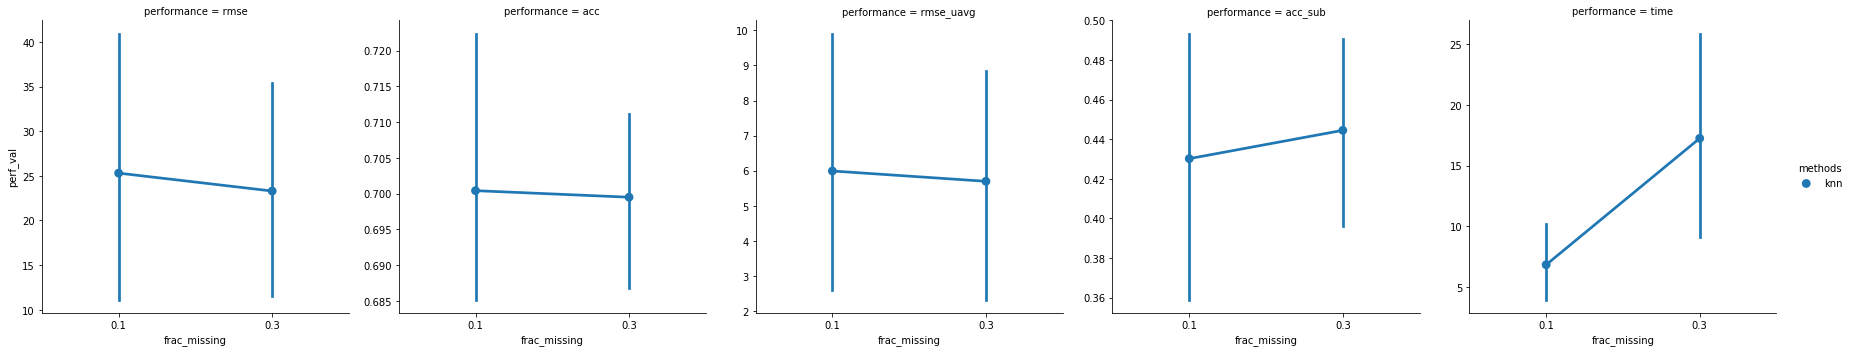

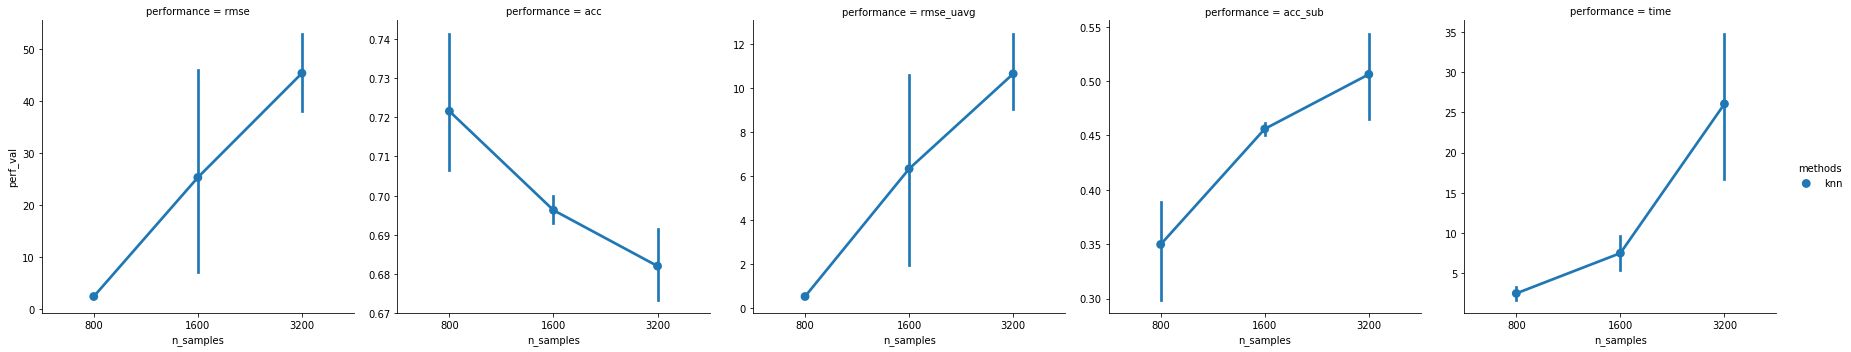

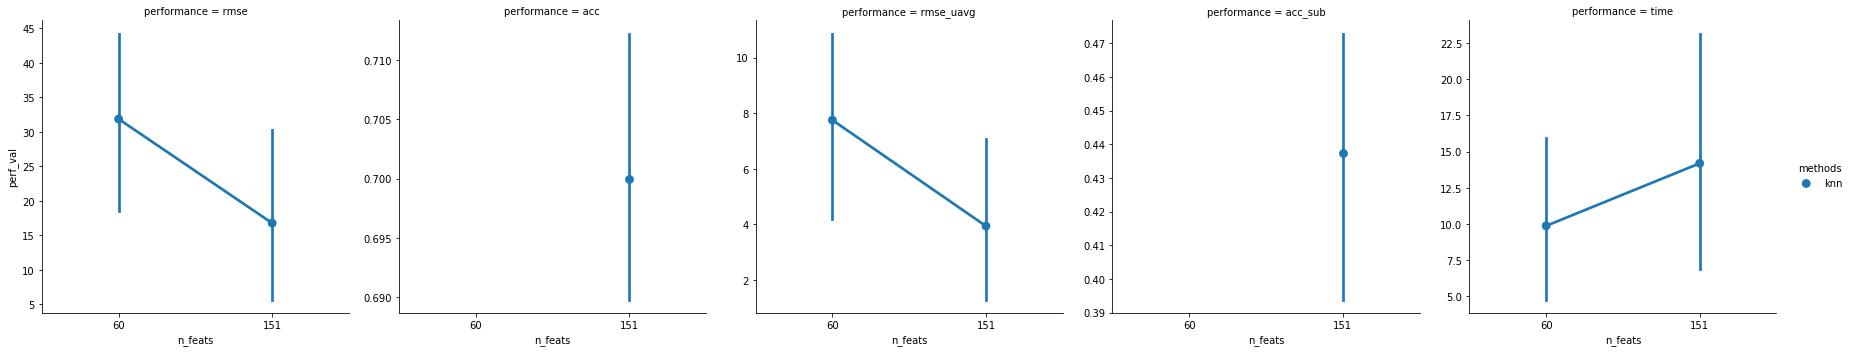

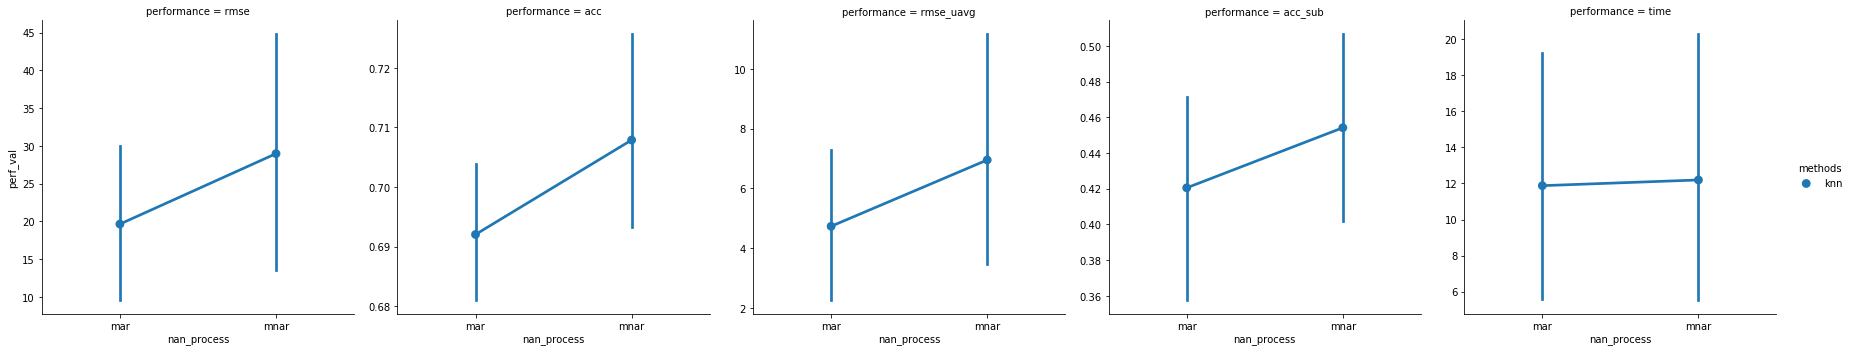

In [353]:
# global constants
_NAN_PROCESS = ['MCAR', 'MAR', 'MNAR']
_DATASET_PARAMS = ['frac_missing', 'n_samples', 'n_feats', 'nan_process']
_PARAMS = [*_DATASET_PARAMS, 'methods']

def evaluate_imputation(df, param_grid, plot='brief', **kwargs):
    '''
    Evaluates performance of diffrent missing data imputation methods using Uniform Average RMSE and 
    raw value RMSE for numerical and Accuracy and Subset Accuracy for categorical features, 
    also comparing execution times.
    
    For Uniform Average RSME and Subset Accuracy see sklearn documentation.

    Args: 
        df: Dataset in form of pd.DataFrame of shape (# samples, # features).
            Nominal features are 'category' dtype, Ordinal same but ordered arguments is True
        param_grid: dictionary of diffrent parameters to test in form of {<param_name_x>: <param_x_list>, ...}
                    possible parameters names: 
                    frac_missing - list of different fractions of missing data 
                    n_samples - list of different sample sizes, int-absolute, <0-1> relative,
                    n_feats - list of pd.Indexes specifying diffrent feature sets to test. The name of the index will 
                              be displayed in result dataframe and plot.
                              {'n_feats': [index_1, index_2,...]}
                    nan_process - list of missing data processes one or more of 
                                 'mcar' - missing completely at random
                                 'mar'  - missing at random
                                 'mnar' - missing not at random 
                    methods - list of imputation methods used. Options are:
                              mice: Multiple Imputation by Chained Equazions
                              emb: Expectation-Maximization with Bootstrapping
                              mf: missForest Imputation
                              knn: Imputation by k-nearest neighbours

        plot:  Plots RMSE, Accuracy and Execution Time comparison of selected imputation aglorithms, be default
               'brief': plots rmse, accuracy and execution time
               'verbose': plots rmse, uniform average rmse, accuracy and subset accuracy
               False: does not plot output
    Returns:
        results: datagrame with desined runs including grid parameters, RMSE, Accuracy and Execution Time
        ds_tree: DataSet Tree (DST) object containing Dataset objects for each param level and param_val combination.
                 
                 Dataset attributes: 
                 .param: Name of the parameter from param_grid
                 .param_val: Value of the parameter from param_grid
                 .data: sampled complete cases data used for amputation in form of pd.DataFrame
                 .amp: amputed data in form of pd.DataFrame
                 .imp: dictionary of {'method': <imp_data>}, where imp_data are imputed data
                             by defined imputation method in form of pd.DataFrame
                
                 Dataset methods:
                 Dataset.search(<search_key>): searches Dataset object in the tree accroding search_key
                                               = list of param_val in param order in param_grid
    '''
    # local constants
    _METHODS = ['mice', 'emb', 'mf', 'knn']
    _PERFORMANCE = ['rmse', 'acc', 'rmse_uavg', 'acc_sub', 'time']
    _PERF_BRIEF = ['rmse', 'acc', 'time']
    _PLOT = [False, 'verbose', 'brief']

    # check arguments
    assert isinstance(df, pd.DataFrame) and len(df.columns) >= 2, \
    'df needs to be pd.DataFrame with at least 2 features'

    assert plot in _PLOT, 'plot argument needs to be one of {}'.format(_PLOT)

    # check parameters grid
    assert isinstance(param_grid, dict) and set(param_grid) <= set(_PARAMS) and 'methods' in param_grid, \
    'param_grid needs to be a dictionary with key "methods" and other optional available parameters {}'.format(_PARAMS)
    
    assert isinstance(param_grid['methods'], list) and set(param_grid['methods']) <= set(_METHODS), \
    'methods is a list of available imputation methods: {}'.format(_METHODS)
     
    if 'n_samples' in param_grid: 
        assert isinstance(param_grid['n_samples'], list) and all(0 < np.array(param_grid['n_samples'])), \
        'n_samples needs to be a list of number or fraction of randomly selected samples from dataset.'

    if 'n_feats' in param_grid:
        assert isinstance(param_grid['n_feats'], list) and \
        all([(isinstance(feat_set, (list, pd.Index)) and set(feat_set) <= set(df.columns)) 
             for feat_set in param_grid['n_feats']]), \
        'n_feats needs to be a list or index of 2 or more different features'

    if 'frac_missing' in param_grid:
        assert isinstance(param_grid['frac_missing'], list) and 'nan_process' in param_grid and \
        all(0 < np.array(param_grid['frac_missing'])) and all(np.array(param_grid['frac_missing']) < 1), \
        'frac_missing needs to be a list of fractions in interavl (0, 1) and it is requested to provide nan_process as well'

    if 'nan_process' in param_grid:
        assert set([mech.upper() for mech in param_grid['nan_process']]) <= set(_NAN_PROCESS), \
        'nan process needs to be one or more from existing missign data processes: {}'.format(_NAN_PROCESS)

    # create parameters grid
    columns = _PARAMS + _PERFORMANCE
    results = pd.DataFrame(columns = columns, index = pd.Index([], name='run'))

    for run, setup in enumerate(
        itertools.product(
            *[[index.name for index in param_grid[param]] 
              if param == 'n_feats' else param_grid[param] 
              for param in param_grid]
        )
    ):
        results.loc[run+1] = pd.Series(setup, index=[*param_grid])
    
    # generate complete cases and amputed datasets
    msg = 'Generating datasets...'
    print(msg + '\n' + '-' * len(msg))
    
    ds_tree = DST(df)
    num = 1
    for param in param_grid:
        if param != 'methods':
            num *= len(param_grid[param])
            if param != 'nan_process':
                start = time.time()
            for param_val in param_grid[param]:
                if param == 'nan_process':
                    start = time.time()
                ds = Dataset(param=param, param_val=param_val)
                ds_tree.insert(ds, 
                               random_state=kwargs['random_state'] if 'random_state' in kwargs else None)
                if param == 'nan_process':
                    elapsed = time.time() - start
                    msg = ('Parameter: {:12} ---> Level: {:4} ---> {:2} datasets generated in {:.0f} min {:.2f} s'
                           .format(param, param_val, int(num / len(param_grid[param])), elapsed // 60, elapsed % 60)
                          )
                    print(msg)
            if param != 'nan_process':
                elapsed = time.time() - start
                msg = ('Parameter: {:12} ---> Level: {:4} ---> {:2} datasets generated in {:.0f} min {:.2f} s'
                       .format(param, 'all', num, elapsed // 60, elapsed % 60)
                      )
                print(msg)
                
    # impute missing data to amputed datasets
    msg = 'Imputing datasets...'
    print('\n' + msg + '\n' + '-' * len(msg))
    
    for run in tqdm_nt(results.index):
        search_key = results.loc[run, _DATASET_PARAMS].values.tolist()
        method = results.loc[run, 'methods']
        
        # find dataset for particular run
        ds = ds_tree.search(search_key)
        
        # impute dataset
        start = time.time()
        ds.impute(ds.amp, method)
        elapsed = time.time() - start

        # calculate performance
        # ---------------------
        cat_feats = ds.data.select_dtypes('category').columns
        num_feats = ds.data.select_dtypes('number').columns
        

        if not num_feats.empty:
            # mask imputed values and cases
            mask_imp_values = ds.amp[num_feats].isna()
            mask_imp_cases = ds.amp[num_feats].isna().any(axis=1)
            
            if mask_imp_cases.any():
                # root means squared error
                y = ds.data[num_feats].values.ravel()[mask_imp_values.values.ravel()].reshape(-1, 1)
                y_imp = ds.imp[method][num_feats].values.ravel()[mask_imp_values.values.ravel()].reshape(-1, 1)
                rmse = math.sqrt(mean_squared_error(y, y_imp))

                # uniform average means squared error (uniform weighted average of features rmse)
                y = ds.data.loc[mask_imp_cases.values, num_feats].values
                y_imp = ds.imp[method].loc[mask_imp_cases, num_feats].values
                rmse_uavg = math.sqrt(mean_squared_error(y, y_imp))
            
            else:
                rmse, rmse_uavg = (np.nan,)*2

        else: 
            rmse, rmse_uavg = (np.nan,)*2
        
        if not cat_feats.empty:
            # mask imputed values and cases
            mask_imp_values = ds.amp[cat_feats].isna()
            mask_imp_cases = ds.amp[cat_feats].isna().any(axis=1)
            
            if mask_imp_cases.any():
                # accuracy
                y = ds.data[cat_feats].astype(float).values.ravel()[mask_imp_values.values.ravel()].reshape(-1, 1)
                y_imp = ds.imp[method][cat_feats].astype(float).values.ravel()[mask_imp_values.values.ravel()].reshape(-1, 1)            
                acc = accuracy_score(y, y_imp)

                # subset accuracy
                y = pd.get_dummies(ds.data.loc[mask_imp_cases, cat_feats]).values
                y_imp = pd.get_dummies(ds.imp[method].loc[mask_imp_cases, cat_feats]).values
                acc_sub = accuracy_score(y, y_imp)
                
            else:
                acc, acc_sub = (np.nan,)*2
            
        else:
            acc, acc_sub = (np.nan,)*2
            
        # record performance
        results.loc[run, 'rmse'] = rmse
        results.loc[run, 'acc'] = acc
        results.loc[run, 'rmse_uavg'] = rmse_uavg
        results.loc[run, 'acc_sub'] = acc_sub
        results.loc[run, 'time'] = elapsed

    # print results
    if plot: display(results.head(n=run))
    
    # plot results
    if plot:
        if plot == 'verbose':
            rs = pd.melt(results, id_vars=_PARAMS, value_vars=_PERFORMANCE, var_name='performance', value_name='perf_val')
        elif plot == 'brief':
            rs = pd.melt(results, id_vars=_PARMAS, value_vars=_PERF_BRIEF, var_name='performance', value_name='perf_val')
        else:
            raise Exception('Not Implemented')
        
        for fig, param in enumerate(_DATASET_PARAMS):
            plt.figure(fig+1);
            g = sns.catplot(x=param, y='perf_val', col='performance', hue='methods', data=rs, 
                            kind='point', sharey=False);
        
    # return results & dataset tree
    return results, ds_tree

class DST(object):
    '''
       Dataset Tree which holds the orginal dataset and all children datasets which need to be tested for 
       different imputation algorithms. Only leafs are used for amputation and imputation. 
       Internal nodes are intermediate data traformation in order to save computation time.
    '''
    def __init__(self, data):
        self.root_ds = Dataset(data)
        
    def insert(self, new_ds, **kwargs):
        self.__insert(self.root_ds, new_ds, **kwargs)
    
    def __insert(self, current_ds, new_ds, **kwargs):
        # if child(ren) exists
        if len(current_ds.children) > 0:
            
            # if parent level of new dataset reached add dataset
            if current_ds.children[0].param == new_ds.param:
                current_ds.add_child(new_ds)
                new_ds.fit(current_ds.data, **kwargs)
            
            # if not go deeper
            else:
                for child_ds in current_ds.children:
                    self.__insert(child_ds, deepcopy(new_ds))
        
        # if leaf reached create new level
        else:
            current_ds.add_child(new_ds)
            new_ds.fit(current_ds.data, **kwargs)
    
    def search(self, search_key):
        searched_ds, travers = self.__search(self.root_ds, [None]+search_key, [], strict=True)
        return searched_ds
    
    def __search(self, current_ds, search_key, traverse, strict=False):
        traverse.append(current_ds.param_val.name if isinstance(current_ds.param_val, pd.Index) else \
                        current_ds.param_val)
        if traverse == search_key[:len(traverse)]:
            if len(traverse) < len(search_key):
                if len(current_ds.children) > 0:
                    for child in current_ds.children:
                        searched_ds, traverse = self.__search(child, search_key, traverse)
                        if searched_ds is not None: break
                else:
                    if strict:
                        raise Exception('Dataset branch depth {} less then search_key lenght {}'
                                       .format(len(traverse), len(search_key)))
                    else:
                        searched_ds, traverse = None, None
            elif len(traverse) == len(search_key):
                searched_ds, traverse = current_ds, traverse
            else:
                raise Excpetion('Not implemented')           
        else: 
            searched_ds= None 
            traverse.pop()
            
        return searched_ds, traverse
    
            
    def __repr__(self, level=0):
        return self.root_ds.__repr__(0)

class Dataset(object):
    '''
        Dataset class which holds the parameter and patemeter value for dataset tranformation. 
        Transformed data are stored in data attribute. 
    '''
    
    def __init__(self, data=None, parent=None, param=None, param_val=None, **kwargs):
        
        # check arguments
        if data is not None:
            assert isinstance(data, pd.DataFrame), 'Data needs to be pd.DataFrame of shape (# samples, # features)'
        
        if parent is not None:
            assert isinstance(parent, Dataset), 'Parent needs to point to Dataset object'
            
        if param is not None:
            assert param in _DATASET_PARAMS, 'Parameter needs to be one of {}'.format(_DATASET_PARAMS)
            
            if param == 'frac_missing':
                assert 0 < param_val < 1, 'Proportion of missing cases needs to be in interval (0, 1).'
            
            if param == 'nan_process':
                assert param_val.upper() in _NAN_PROCESS, 'Missing data process need to be one of {}'.format(_NAN_PROCESS)
                    
            # n_samples, and n_features are check in fit method
            
        self.data = data              # completed data used to generate amputed data
        self.pat = None               # most frequent patterns of missing data in root dataset used for amputation
        self.pat_enc = None           # most frequent patterns of missing data with one-hot encoded categorical variables
        self.amp = None               # amputed dataset with atttributes defined by param, para_val back to root of the tree
        self.imp = dict()             # dictionary of imputed datasets, keys are imputation methods
        self.cor = None               # correlation matrix of amputed dataset to calculate predictor matrix
        self.puc = None               # proportion of usable cases matrix for predictor matrix calculation
        self.mar = None               # missing at random test matrix for predictor matrix calculation
        self.opt_min_puc = None       # optimal minimum proprtion of usable cases for quickpredict function of mice imput.
        self.opt_min_cor = None       # optimal mininum correlation for quickpredict function of mice imputation
        self.pred = None              # predictor matrix used for mice imputation
        self.param = param            # paramter name from param_grid
        self.param_val = param_val    # parameter value from param_gird
        self.parent = parent          # parent dataset pointer
        self.children = []            # list of pointers to children datasets
        
    def add_child(self, new_ds, strict=True):
        is_inserted = (
            any([child_ds.param_val.equals(new_ds.param_val) for child_ds in self.children]) \
            if isinstance(new_ds.param_val, pd.Index) else \
            (new_ds.param_val in [child_ds.param_val for child_ds in self.children])
        )

        if is_inserted:
            if strict:
                raise Exception('Dataset {} = {} already in the dataset tree'
                               .format(new_ds.param, new_ds.param_val))
            else:
                return None
        else:
            new_ds.parent = self
            return self.children.append(new_ds)
        
    def fit(self, data, **kwargs):
        # get complete cases
        if self.param == 'frac_missing':
            data = data.dropna()
            
        # sample cases
        if self.param == 'n_samples':
            if 0 < self.param_val < 1:
                data = data.sample(frac=self.param_val, 
                                   random_state=kwargs['random_state'] if 'random_state' in kwargs else None)
            elif self.param_val >= 1:
                data = data.sample(n=self.param_val,
                                   random_state=kwargs['random_state'] if 'random_state' in kwargs else None)
            else:
                raise Exception('Not implemented')

        # sample features
        if self.param == 'n_feats':
            data = data[self.param_val]
        
        # simulate missing data process
        if self.param == 'nan_process':
            
            # get proportion of missing cases
            ancestor = self.__ancestor(param='frac_missing')
            prop = ancestor.param_val
            
            # get encoded dataset, estimate of missing pattern matrix and pattern proportions
            prefix_sep = '_'
            data_root = self.__ancestor().data
            data_enc, self.pat_enc, freq, self.pat = self.__get_patterns(data_root, data, prefix_sep=prefix_sep)

            # get missing data mechanism (MCAR, MAR or MNAR)
            mech = self.param_val.upper()

            # convert ampute arguments to r data structures
            data_enc, patterns_enc, freq = df2dfr(data_enc), df2dfr(self.pat_enc), FloatVector(freq)
            
            # ampute and decode data
            amp_result = mc.ampute(data_enc, prop=prop, patterns=patterns_enc, freq=freq, mech=mech)
            amp_enc = dfr2df(amp_result.rx2('amp'))
            amp = self.__decode(amp_enc, dtypes = data.dtypes, prefix_sep=prefix_sep)
            self.amp = amp.reindex(data.columns, axis=1)
        
        all_nan = (data.isna().sum() == data.index.size)
        if all_nan.any():
            raise Exception('Column(s) {} filled with missing values. Resample dataset'.format(data.columns[all_nan]))
            
        self.data = data
    
    def __ancestor(self, param=None, param_val=None):
        # initiate ancastor
        ancestor = self.parent
        ancestor_param_val = ancestor.param_val.name if isinstance(ancestor.param_val, pd.Index) else \
                             ancestor.param_val
        
        # traverse up and look for user defined dataset
        # look for ancestor if param and param_val is defined or root dataset requested
        if ((ancestor.param is not None) and (ancestor.param_val is not None)) or \
           ((param is None) and (param_val is None)):
            while ((ancestor.param != param) and (ancestor_param_val != param_val)):
                ancestor = ancestor.parent
                if ancestor is not None:
                    ancestor_param_val = ancestor.param_val.name if isinstance(ancestor.param_val, pd.Index) else \
                                         ancestor.param_val
                else: break
        
        # look for ancestor if only param is defined
        elif (ancestor.param is not None) and (ancestor.param_val is None):
            while (ancestor.param != param):
                ancestor = ancestor.parent
                if ancestor is None: break
        
        # look for ancestor if only param_val is defined
        elif (ancestor.param is None) and (ancestor.param_val is not None):
            while (ancestor_param_val != param_val):
                ancestor = ancestor.parent
                if ancestor is not None:
                    ancestor_param_val = ancestor.param_val.name if isinstance(ancestor.param_val, pd.Index) else \
                         ancestor.param_val
                else: break
        else: 
            raise Exception('Not implemented')
        
        return ancestor
    
    def __get_patterns(self, data_root, data, **kwargs):
        '''
        Function approximate missing data patterns matrix and pattern proportion vector for mice ampute function. 
        Approximation is done using original data with missing values and impose it on complete case data. 
        All Categorical data are one-hot encoded
        
        Args:
            data_root: original data with missing values as pd.DataFrame with shape of (# samples, # features)
            data: complete cases data as pd.DataFrame with shape of (# samples, # features) where features can
                  be subset of data_root features
                  
        Returns:
            data_enc: one-hot encoded complete cases data as pd.DataFrame of shape (# samples, # encoded features)
            patterns_enc: approximated encoded missing data pattern matrixas pd.DataFrame 
                      of shape (# patterns, # encoded features)
            freq: proportion of missing data patterns as pd.Series of size (, # patterns)
        '''

        # get missing data matrix
        patterns = ((~data_root[data.columns]
                      .isna())
                    .groupby([*data.columns])
                    .size()
                    .reset_index(name='n_cases')
                    .sort_values('n_cases', ascending=False)
                   )
        
        # delete complete cases pattern
        patterns = patterns.drop(patterns.index[patterns[data.columns].all(axis=1)])
        
        # add patterns descriptives
        patterns['cum_per_cases'] = patterns['n_cases'].cumsum() / patterns['n_cases'].sum() * 100
        patterns['avg_pattern_cases'] = data.index.size / (patterns.reset_index()['index']+1)
        
        # filter most occuring patterns
        min_pattern_per_treshold = 80
        min_pattern_cases_treshold = 15
        patterns = patterns.loc[
            (patterns['cum_per_cases'] <= min_pattern_per_treshold) & \
            (patterns['avg_pattern_cases'] >= min_pattern_cases_treshold)
        ]
        
        # get pattern porportion vector
        freq = patterns['n_cases'] / patterns['n_cases'].sum()
        
        # encode patterns
        data_enc = pd.get_dummies(data, **kwargs)
        cat_feats = data.select_dtypes('category').columns
        patterns_enc = (
            patterns[data.columns]
            .reindex(data.columns.union(data_enc.columns), axis=1)
            .fillna(axis=1, method='ffill')
            .drop(columns=[*cat_feats])
            .reindex(data_enc.columns, axis=1)
            .astype(int)
        )

        return data_enc, patterns_enc, freq, patterns[data.columns]
    
    def __decode(self, data_enc, dtypes, prefix_sep='_'):
        '''
        Decode encoded categorical columns of the original data and preserve missing values.
        Numerical columns stays intact.
        
        Args:
            data_enc: encoded data as pd.DataFrame of shape (# samples, # encoded features)
            dtypes: dtypes of original data which should be preserved as pd.Series
            prefix_sep: prefix separator used for encoding categorical features
        
        Returns:
            data_dec: decoded data as pd.DataFrame of shape (# samples, # features) including intact numerical columns/features
                      and decoded columns/features of categorical type
        '''     
        # split data to intact and decoding group
        num_feats = dtypes.index[dtypes.apply(lambda dtype: dtype.kind in _NUMERIC_KINDS)]
        data_intact = data_enc[num_feats]
        data_decode = data_enc[data_enc.columns.difference(num_feats)]
        
        # decode data
        data_decode = (data_decode
                       .groupby(
                           lambda feat: prefix_sep.join(feat.split(prefix_sep)[:-1]),
                           axis=1,
                           sort=False
                       )
                       .apply(
                           lambda group: group.apply(
                               lambda case: np.nan if case.isna().all() else \
                                            int(float((case.idxmax().split(prefix_sep)[-1]))),
                               axis=1
                           )
                       )
                       .apply(lambda feat: pd.Series(feat, dtype=dtypes[feat.name]))
                      )
        
        # return decoded dataframe
        return pd.concat([data_intact, data_decode], axis=1)
    
    def impute(self, df, method, strict=True):
        if df is None: 
            if strict:
                raise Exception('Dataset object not yet amputed')
            else:
                self.imp[method] = None
        else:   
            if method.lower() == 'mice':
                self.imp['mice'] = self.mice(df)
            elif method.lower() == 'emb':
                self.imp['emb'] = self.emb(df)
            elif method.lower() == 'mf':
                self.imp['mf'] = self.mf(df)
            elif method.lower() == 'knn':
                self.imp['knn'] = self.knn(df)
            else:
                raise Exception('Not implemented')

    def knn(self, df, **kwargs):
        '''
        Imputes data by k-nearest neigbours imputation based on a variation of the Gower Distance for 
        numerical, categorical, ordered and semi-continous variables
        
        Args:
            df: Data with missing values as pd.DataFrame of shape (# samples, # features)
                       
        Returns:
            imp: imputed data as pd.DataFrame of shape (# samples, len(mod_feats))
        '''
        # check arguments
        # ---------------
        assert isinstance(df, pd.DataFrame) and 2 <= df.columns.size 
        
        # convert dataset
        dfr = df2dfr(df)
        
        # variables where missing values should be imputed
#         var = df.columns[df.isna().any()]
#         kwargs['variable'] = StrVector(var) if 'variable' not in kwargs else kwargs['variable']
        
        # number of nearest neighbours used
        k = 5
        kwargs['k'] = k if 'k' not in kwargs else kwargs['k']
        
        # flag for creating imputation mask
        imp_var = False
        kwargs['imp_var'] = False if 'imp_var' not in kwargs else kwargs['imp_var']
        
        # run imputation
        impr = vim.kNN(dfr, **kwargs)
        
        # convert to pd.DataFrame
        imp = dfr2df(impr, df.dtypes)
        imp.index = df.index    # kNN functions does not preserved index of dfr
        
        return imp
        

    def mice(self, df, mod_feats=None, **kwargs):
        '''
        Imputes data by Multiple Imputation using Chained Equations
        
        Args:
            df: Data with missing values as pd.DataFrame of shape (# samples, # features)
            mod_feats: Featuers which will be used for modeling after imputation as pd.Index
                       as subset of df.columns
                       
        Returns:
            imp: Pooled imputed data as pd.DataFrame of shape (# samples, len(mod_feats))
        '''
        # check arguments
        # ---------------
        assert isinstance(df, pd.DataFrame) and 2 <= df.columns.size 

        if mod_feats is not None: 
            assert isinstance(mod_feats, pd.Index) and set(mod_feats) <= set(df.columns)
            
        # 1. define predictor matrix
        # -----------------------
        if 'predictorMatrix' not in kwargs:
            # calculate optimum parameters (minimum correlation, minimum number of usable cases) 
            # for quick predict function (see quickpredict documentation r of mice package)
            # if (self.opt_min_puc is None) and (self.opt_min_cor is None):
            #    self.opt_min_puc, self.opt_min_cor, self.corr = self.__get_quickpredict_params(
            #        df, puc_space=(0.1, 0.95, 20), cor_space=(0.1, 0.95, 20), cor_df=self.cor, plot=False
            #    )    
            
            # (re)define design parameters
            self.opt_min_puc = 0.1    # define min number of usable cases
            self.opt_min_cor = 0.1    # define min association/correlation coeficient
            
            # calculate predictor matrix
            self.pred, self.cor, self.puc, self.mar = self.__quickpred(
                df, min_puc=self.opt_min_puc, min_cor=self.opt_min_cor, include=mod_feats, exclude=None, 
                cor_df=self.cor, puc_df=self.puc, mar_df=self.mar
            )
            # convert predictor matrix to r matrix
            kwargs['predictor_Matrix'] = df2mtr(self.pred)

        # 2-4. define imputation methods/models to be used for each imputed feature
        # -----------------------------------------------------------------------
        # decide if transformed variables (ex. summated scales, normalized etc...) 
        # will be actively or passively imputed
        pass
        
        # check if suspected features are note nested and nested models will need to be used
        # define suspected features
        # finanz_feats = [feat for feat in df.columns if 'FINANZ' in feat]
        # shopper_feats = ['RETOURTYP_BK_S', 'SHOPPER_TYP']
        # suspect_feats = [finanz_feats, shopper_feats]

        # print cross tabulations
        # print('Check 0 patterns for nested features:')
        # for feats in suspect_feats:
        #     for idx_feat1, feat1 in enumerate(feats):
        #         for feat2 in feats[idx_feat1+1:]:
        #             print('\n', pd.crosstab(df[feat1], df[feat2]))
        
        # initiate mice parameters
        dfr = df2dfr(df)
        init = mc.mice(dfr, maxit=0, pri=False)
        
        # align selecected models with scale of target features and missing values
        if 'method' not in kwargs:
            mtd_lv = init.rx2('method')
            mtd_sr = pd.Series({feat: mtd_lv.rx2(feat)[0] for feat in mtd_lv.names}, name='method')
        
            # print selected models
            # with pd.option_context('display.max_rows', None):
            #   display(pd.concat([feat_info.set_index('attribute')[['type', 'categorical_type', 'unique_codes']],
            #                      df.isna().sum().rename('nan_cases'),
            #                      mtd_sr], 
            #                      axis=1)
            #             .reindex(df.columns)
            #             .sort_values('method'))      

            # update models: For some unknown reason imputation model is not assigned to this variable
            num_feats = df.select_dtypes('number')
            cat_feats = df.select_dtypes('category').columns
            bin_feats = pd.Index([feat for feat in cat_feats if len(df[feat].cat.categories) == 2])
            mul_feats = pd.Index([feat for feat in cat_feats 
                                  if (len(df[feat].cat.categories > 2)) and (df[feat].cat.ordered == False)])
            ord_feats = pd.Index([feat for feat in cat_feats 
                                  if (len(df[feat].cat.categories > 2)) and (df[feat].cat.ordered == True)])
            for feat in mtd_sr.index:
                mtd_lv[mtd_lv.names.index(feat)] = (
                    'pmm' if feat in num_feats else       # predictive mean matching for numerical variables
                    'logreg' if feat in bin_feats else    # logistic regression for binary variables
                    'polyreg'if feat in mul_feats else    # polytomous regression for multilevel unordered categorical data
                    'polr' if feat in ord_feats else      # proportional odds model for ordinal multilevel data
                    ''                                    # no imputation model defined
                )
            kwargs['method'] = mtd_lv

        # 5. define visit sequence
        # ----------------------
        # if monotone missing data pattern present in dataset, this settings will speed up computation
        kwargs['visitSequence'] = 'monotone' if 'visitSequence' not in kwargs else kwargs['visitSequence']

        # 6. set up starting imputation and number of iterations
        # -----------------------------------------------------
        # r equivalent to random_state for deterministic resutls
        kwargs['seed'] = 9212 if 'seed' not in kwargs else kwargs['seed']
        
        # MICE algorithm converts in min 5-10 iterations
        kwargs['maxit'] = 5 if 'maxit' not in kwargs else kwargs['maxit'] 
        
        # 7. set number of multiply imputed datasets
        # -------------------------------------------
         # too low may result in large simulation error, too high need lot of computational power
        kwargs['m'] = 5 if 'm' not in kwargs else kwargs['m']

        # run imputation
        # set number of maximum weights to allow comptation with lot of featuers
        kwargs['nnet_MaxWts'] = 5000 if 'nnet_MaxWts' not in kwargs else kwargs['nnet_MaxWts']
        mc.mice = STM(mc.mice, init_prm_translate={'nnet_MaxNWts': 'nnet.MaxNWts'})
        imp = mc.mice(dfr, **kwargs)
        
        # m imputed datasets are pooled to average for numerical variables and mode for categorical
        return self.__imp_pool(df, imp)
    
    def __imp_pool(self, amp, imp):
        '''
        Generate pooled set from m imputed data sets. Pooling is done by averaging numerical features and
        calculating mode of categorical features across data sets.
        
        Args:
            amp: data with missing values as pd.DataFrame of shape (# samples, # features)
            imp: mids (Multiple Imputed Dataset Object of R) as result of mc.mice r function
            
        Returns: pool_imp: pooled data set as pd.DataFrame
        '''
        # local helper funcion
        def get_imp_set(feats):
            '''
            Stack multiple imputed datasets over 3rd dimension for selected features
            '''
            imp_set = []
            for i in range(int(imp.rx2('m')[0])):
                imp_dfr = mc.complete(imp, i+1)
                imp_df = dfr2df(imp_dfr)
                imp_set.append(imp_df[feats].astype(float).values)    # categoricals need to be casted to float
            imp_set = np.dstack(imp_set)
            return imp_set
        
        # split categorical and numerical features
        num_feats = amp.select_dtypes('number').columns
        cat_feats = amp.select_dtypes('category').columns
        
        # pool numerical features using average
        if not num_feats.empty:
            imp_num = pd.DataFrame(
                get_imp_set(num_feats).sum(axis=2), 
                index=amp.index, 
                columns=num_feats
            )
        else:
            imp_num = pd.DataFrame()
        
        # pool categorical features using mode
        if not cat_feats.empty:
            imp_cat_val = stats.mode(get_imp_set(cat_feats), axis=2)[0].squeeze(axis=2)
            imp_cat = pd.DataFrame.from_items(
                [(feat_name, pd.Series(data=imp_cat_val[:, i], dtype=feat_vals.dtype, index=amp.index))
                for i, (feat_name, feat_vals) in enumerate(amp[[*cat_feats]].iteritems())]
            )
        else:
            imp_cat = pd.DataFrame()
            
        
        # return pooled imputed dataset
        pool_imp = pd.concat([imp_num, imp_cat], axis=1)
        return pool_imp.reindex(amp.columns, axis=1)

    def __get_quickpredict_params(self, df, puc_space=(0.05, 0.95, 19), cor_space=(0.05, 0.95, 19), cor_df=None, plot=True):
        '''
        Calculate optimal parameters for quickpredict method of MICE package to comply with 
        MICE documentation recommendation to have predictors in range of 15-25 to prevent
        computational problems (ref van Burren et al.(1999))

        Args:
            df: pd.DataFrame of data of shape (# samples, # features)
            puc_space: space of the min proprotion of usable cases parameter
            cor_space: space of the min correlation/association coeficient parameter
            cor_df: correlation matrix in form of dataframe of size # features, by defult None
            plot: whether heatmap of the # predictors = f(puc, cor) should be plotted, True by default

        Return:
            opt_min_puc: optimal min proprtion of usable cases
            opt_min_cor: optimal min correlation/assocation coeficient
            cor_df: correlation matrix

        Note: Space is defined as tuple (min, max, # of steps), where min, max is in <0, 1>
        The objective function of optimization algorithm maximizes number of features
        with predictors in range <15-25>.
        Correlation matrix can be provided to speed up optimization.
        '''
        # check arguments
        assert isinstance(df, pd.DataFrame) and len(df.columns) >= 2, 'df need to be pd.DataFrame with at least 2 columns'

        ranges = np.array(list(set([*puc_space[:-1], *cor_space[:-1]])))
        assert np.any(0 < ranges) and np.any(ranges < 1), 'min and max bounds need to be in range (0, 1)'

        if cor_df is not None:
            assert isinstance(cor_df, pd.DataFrame)and \
                   cor_df.index.identical(df.columns) and cor_df.columns.identical(cor_df.columns), \
            'correlation matrix need to be pd.Dataframe of size # of features'

        assert isinstance(plot, bool)

        # # of predictors range
        min_pred = min(15, df.columns.size - 1)
        max_pred = min(25, df.columns.size - 1)    

        # convert dataset to r dataframe
        dfr = df2dfr(df)

        # calculate portion of usable cases
        mdpairs = robjects.r('md.pairs')
        p = mdpairs(dfr)
        ps = p.rx2('mr').ro + p.rx2('mm')
        puc_dfr = p.rx2('mr').ro / ps
        puc_df = pd.DataFrame(pandas2ri.ri2py(puc_dfr),
                              index = list(puc_dfr.rownames),
                              columns = list(puc_dfr.colnames))

        # cacluclate association matrix
        if cor_df is None:
            cor_df = self.__cor_matrix(df, nominal_columns=[*df.select_dtypes('category').columns], 
                                       mark_columns=False, return_results=True, plot=False)
        # set parameter spaces precision
        puc_prec= abs(math.floor(math.log10(abs((puc_space[1] - puc_space[0]) / puc_space[2]))))
        cor_prec = abs(math.floor(math.log10(abs((cor_space[1] - cor_space[0]) / cor_space[2]))))

        # expand parameter spaces
        puc_space = pd.Index(np.round(np.linspace(*puc_space), puc_prec), name='min_portion_of_usable_cases')    
        cor_space = pd.Index(np.round(np.linspace(*cor_space), cor_prec), name='min_association')    

        # optimize minimum proportion of usable cases and association coeficient
        opt_pred_df = pd.DataFrame(index=cor_space, columns=puc_space)
        for min_cor in cor_space:
            for min_puc in puc_space:
                # calculate number of predictors for each dependent variable
                # each predictor must have correlation and number of usable cases 
                # >= initcor and initpuc in respect to dependent variable
                num_pred = (
                    ((min_puc <= puc_df) & (min_cor <= np.abs(cor_df)))
                    .sum(axis=1)
                    .rename('num_predictors')
                )

                # calculate number of dependent features with predictors in range <minpred, maxpred>
                spec_pred = (min_pred <= num_pred) & (num_pred <= max_pred)

                # dependent features in spec
                opt_pred_df.loc[min_cor, min_puc] = spec_pred[df.isna().any()].sum()

        # extract optimal parameters
        opt_min_puc, opt_min_cor = opt_pred_df.max().idxmax(), opt_pred_df.max(axis=1).idxmax()

        # print optimal parameters
        if plot:
            # show heatmap
            fig = plt.figure(figsize=(15, 15))
            sns.heatmap(opt_pred_df, ax=fig.gca(), square=True);
            plt.title('Optimal parameters for predictor selection: Num of features with predictors in range <{:.0f}, {:.0f}>'
                     .format(min_pred, max_pred));

            # print optimal parameters
            print('Optimal parameters: puc = {:.{puc_prec}f}, cor = {:.{cor_prec}f}'
                  .format(opt_min_puc, opt_min_cor, puc_prec=puc_prec, cor_prec=cor_prec))

        return opt_min_puc, opt_min_cor, cor_df

    def __cor_matrix(self, dataset, nominal_columns=None, mark_columns=False, theil_u=False, plot=True,
                     return_results = False, **kwargs):
        """
        Calculate the correlation/strength-of-association of features in data-set with both categorical (eda_tools) and
        continuous features using:
         * Pearson's R for continuous-continuous cases
         * Correlation Ratio for categorical-continuous cases
         * Cramer's V or Theil's U for categorical-categorical cases

        **Returns:** a DataFrame of the correlation/strength-of-association between all features

        **Example:** see `associations_example` under `dython.examples`

        Parameters
        ----------
        dataset : NumPy ndarray / Pandas DataFrame
            The data-set for which the features' correlation is computed
        nominal_columns : string / list / NumPy ndarray
            Names of columns of the data-set which hold categorical values. Can also be the string 'all' to state that all
            columns are categorical, or None (default) to state none are categorical
        mark_columns : Boolean, default = False
            if True, output's columns' names will have a suffix of '(nom)' or '(con)' based on there type (eda_tools or
            continuous), as provided by nominal_columns
        theil_u : Boolean, default = False
            In the case of categorical-categorical feaures, use Theil's U instead of Cramer's V
        plot : Boolean, default = True
            If True, plot a heat-map of the correlation matrix
        return_results : Boolean, default = False
            If True, the function will return a Pandas DataFrame of the computed associations
        kwargs : any key-value pairs
            Arguments to be passed to used function and methods
        """
        dataset = convert(dataset, 'dataframe')
        columns = dataset.columns
        if nominal_columns is None:
            nominal_columns = list()
        elif nominal_columns == 'all':
            nominal_columns = columns
        corr = pd.DataFrame(index=columns, columns=columns)
        for i in range(0,len(columns)):
            for j in range(i,len(columns)):
                if i == j:
                    corr[columns[i]][columns[j]] = 1.0
                else:
                    datapair = dataset[[columns[i], columns[j]]].dropna()
                    if columns[i] in nominal_columns:
                        if columns[j] in nominal_columns:
                            if theil_u:
                                corr[columns[j]][columns[i]] = dt.theils_u(datapair[columns[i]],datapair[columns[j]])
                                corr[columns[i]][columns[j]] = dt.theils_u(datapair[columns[j]],datapair[columns[i]])
                            else:
                                cell = dt.cramers_v(datapair[columns[i]],datapair[columns[j]])
                                corr[columns[i]][columns[j]] = cell
                                corr[columns[j]][columns[i]] = cell
                        else:
                            cell = dt.correlation_ratio(datapair[columns[i]], datapair[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        if columns[j] in nominal_columns:
                            cell = dt.correlation_ratio(datapair[columns[j]], datapair[columns[i]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                        else:
                            cell, _ = stats.pearsonr(datapair[columns[i]], datapair[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
        corr.fillna(value=np.nan, inplace=True)
        if mark_columns:
            marked_columns = ['{} (nom)'.format(col) if col in nominal_columns else '{} (con)'.format(col) for col in columns]
            corr.columns = marked_columns
            corr.index = marked_columns
        if plot:
            plt.figure(figsize=kwargs.get('figsize',None))
            sns.heatmap(corr, annot=kwargs.get('annot', None), fmt=kwargs.get('fmt','.2f'), cmap=kwargs.get('cmap', 'RdYlBu'), 
                        vmin=kwargs.get('vmin', -1), vmax=kwargs.get('vmax', 1), square=kwargs.get('square', True))
            plt.title(label=kwargs.get('label', 'Assosciation Matrix'))
            plt.show()
        if return_results:
            return corr
        
    def __quickpred(self, df, min_puc=0, min_cor=0.1, include=None, exclude=None, cor_df=None, puc_df=None, mar_df=None):
        '''
        Selects predictors according to simple statistics (adapted from MICE quickpred function)

        Args:
            df: pd.Dataframe frame with incomplete data of shape (# samples, # features)
            min_cor: scalar specifying the mininmum treshold against which the 
                    absolute corelation in data is compared
            minp_uc: scalar specifying the minimum teshold for the proportion of usable cases
            include: pd.Index of one or more feature names which will be always included as predictor
            excluded: pd.Index of one or more feature names which will be always excluded as predictor
            cor_df: correlation matrix in form of dataframe of size # features, by default None
            puc_df: proportion of usable cases matrix in form of dataframe of size # features, by defualt None
            mar_df: missing at random test matrix (p-values of two groups tests) in form of dataframe of size # features
            Note: matrices if calculated prior and pass as arguments speed up the computation

        Return:
            pred_df: Predictor matrix of size # fatures
            puc_df: Proportion of usable cases matrix of size # features
            cor_df: Correation matrix of size # features
            mar_df: Missing at random matrix (p-values of two groups test) of size # features

        Note: Correlation matrix can be provided to speed up optimization.
        '''
        # check arguments
        assert isinstance(df, pd.DataFrame), 'Argument df need to be a pd.Dataframe.'
        assert (0 <= min_cor <= 1) and (0 <= min_puc <=1), 'mincor and minpuc need to be in range of <0, 1>.'

        if include is not None: 
            assert isinstance(include, pd.Index) and set(include).issubset(df.columns), \
            'Include needs to be subset list of features in dataframe.'

        if exclude is not None: 
            assert isinstance(exclude, pd.Index) and set(exclude).issubset(df.columns), \
            'include needs to be subset list of features in dataframe.'

        if (include is not None) and (exclude is not None):
            assert not bool(set(include) & set(exclude)), \
            'include and exclude can not consist the same feature(s) {}'.format(set(include) & set(exclude))

        if cor_df is not None:
            assert isinstance(cor_df, pd.DataFrame) and \
                   cor_df.index.identical(df.columns) and cor_df.columns.identical(cor_df.columns), \
            'correlation matrix need to be pd.Dataframe of size # of features'
        
        if puc_df is not None:
            assert isinstance(puc_df, pd.DataFrame) and \
                   puc_df.index.identical(df.columns) and puc_df.columns.identical(puc_df.columns), \
            ' Proportion of usable cases matrix need to be pd.Dataframe of size # of features'
        
        if mar_df is not None:
            assert isinstance(mar_df, pd.DataFrame) and \
                   mar_df.index.identical(df.columns) and mar_df.columns.identical(mar_df.columns), \
            ' Missing at random test matrix need to be pd.Dataframe of size # of features'

        # limits for minimum and maximum number of predictors
        min_pred, max_pred = min(15, df.columns.size - 1), min(25, df.columns.size - 1)
        
        # statistical significance limit
        p_alpha = 0.05
        
        # maximum allowed collinearity
        max_cor = 0.999

        # calculate portion of usable cases
        if puc_df is None:
            puc_df = self.__puc_matrix(df)

        # calculate association matrix
        if cor_df is None: 
            cor_df = self.__cor_matrix(df, nominal_columns=[*df.select_dtypes('category').columns], 
                                       mark_columns=False, return_results=True, plot=False)
            
        # calculate missing at random matrix
        if mar_df is None:
            mar_df = self.__mar_matrix(df)['p_values']
            
        # initiate predictor matrix
        pred_df = pd.DataFrame(np.zeros(df.columns.shape*2), index=df.columns, columns=df.columns)

        # extract included features and set them as predictors, adjust predictors limits
        if include is not None: 
            incl_df = pred_df[include].copy()
            pred_df.drop(columns=include, inplace=True)
            incl_df.loc[:, :] = 1
            min_pred -= include.size
            max_pred -= include.size
        
        # extract excluded features and set them as not predictors
        if exclude is not None: 
            excl_df = pred_df[exclude].copy()
            pred_df.drop(columns=exclude, inplace=True)
            excl_df.loc[:, :] = 0
        
        # calculate predictors matrix (1 inculded, 0 excluded)
        pred_df = (
            ((min_puc <= puc_df) | (mar_df <= p_alpha)) & ((min_cor <= np.abs(cor_df)) & (np.abs(cor_df) <= max_cor))
            .astype(int)
            [pred_df.columns]
        )

        # adjust predictor matrix to comply with # of predictors limits
        # -------------------------------------------------------------

        # calculate number of predictors
        num_pred = pred_df.sum(axis=1)

        # get features outside of # of predictors limits excluding features no missing values
        out_feats = pred_df.index[((num_pred <= min_pred) | (max_pred <= num_pred)).values]

        # calculate composite measure as harmonic mean of correlation and/or proportion of usable cases
        # and/or mar p-values
        com_df = (
            3 * puc_df * cor_df.abs() * (1 - mar_df) / 
            (puc_df * cor_df.abs() + puc_df * (1 - mar_df) + cor_df.abs() * (1 - mar_df))
        )
        puc_cor_df = 2 * puc_df * cor_df.abs() / (puc_df + cor_df.abs()) 
        puc_mar_df = 2 * puc_df * (1 - mar_df) / (puc_df + (1 - mar_df))
        cor_mar_df = 2 * cor_df.abs() * (1 - mar_df) / (cor_df.abs() + (1 - mar_df))        
        
        # calculates weighted average of composite measures (all properties interaction interactions)
        # and main effects of properties (puc, cor, mar)
        weights = [3, 2, 2, 2, 1, 1, 1]
        com = np.dstack(
            (com_df.values, 
             puc_cor_df.values, puc_mar_df.values, cor_mar_df.values,
             puc_df.values, cor_df.abs().values, (1 - mar_df).values)
        )
        com = ma.masked_array(com, np.isnan(com))
        com, w_sum_valid = ma.average(com, weights=weights, axis=2, returned=True)
        com = com * w_sum_valid / sum(weights)
        
        # exclude recursive predictions
        np.fill_diagonal(com, np.nan)
        com_df = pd.DataFrame(com, index=com_df.index, columns=com_df.columns)
    
        for feat in out_feats :
            # get top-k predictors with highest composite measure
            topk = min_pred if num_pred[feat] <= min_pred else max_pred
            preds = com_df.loc[feat, pred_df.columns].nlargest(topk).index

            # update predictors matrix
            pred_df.loc[feat] = 0
            pred_df.loc[feat, preds] = 1
        
        # merge included features as predictors with predictors matrix
        if include is not None:
            pred_df = pd.concat([pred_df, incl_df], axis=1)
        
        # merge excluded features as no predictors with predictors matrix
        if exclude is not None:
            pred_df = pd.concat([pred_df, excl_df], axis=1)

        # set features with no missing values not having predictors
        no_nan_feats = pred_df.index[~df.isna().any()]
        pred_df.loc[no_nan_feats] = 0
            
        
        # exclude highly colinear features (ref. max_cor) to keep mice convergance
        collin_feats = self.__get_collin_feats(cor_df, max_cor)
        pred_df.loc[collin_feats, :] = 0
        pred_df.loc[:, collin_feats] = 0
         
        # exclude recursive predictions and return predictor matrix
        pred_df_val = pred_df.reindex(columns=df.columns).values
        np.fill_diagonal(pred_df_val, 0)
        pred_df = pd.DataFrame(pred_df_val, index=df.columns, columns=df.columns)
        return pred_df, cor_df, puc_df, mar_df
    
    def __puc_matrix(self, df):
        '''
        Calculates proportion of usable cases matrix

        Args:
            df: data in form of pd.DataFrame of shape (# samples, # features)

        Return:
            puc_df: proportion of usable cases in form of pd.DataFrame of shape(# features, # features)
        '''
        # check arguments
        assert isinstance(df, pd.DataFrame), 'Argument df need to be a pd.Dataframe.'

        # transform pd.DataFrame to r dataframe
        dfr = df2dfr(df)

        # calculate puc matrix as r dataframe
        mdpairs = robjects.r('md.pairs')
        p = mdpairs(dfr)
        ps = p.rx2('mr').ro + p.rx2('mm')
        pp = p.rx2('mr').ro / ps

        # return puc matrix in form of pd.Dataframe
        return pd.DataFrame(pandas2ri.ri2py(pp),
                            index = df.columns,
                            columns = df.columns)

    def __mar_matrix(self, data):
        '''
        Check if there are no differences in frequences of codes or averages between missing & valid value groups
        across all features. Helps to evalute if missing data process is MAR (Missing At Random) or
        MCAR (Missing Completely At Random) or NMAR (Not Missing At Random).

        Args:
            data: dataset as dataframe of shape (# of samples, # of features)

        Returns: Dictionary with keys and respective test characteristics as dataframes of shape (# of features, # of features) 
                 described below: 
                 'p_values': p values 
                 'num_cases_valid_data': number of samples with valid values
                 'num_cases_missing_data': number of samples with missing values
                 'num_cases_power80': number of samples to have statistical power 80%
                 'num_cases_used': min number of samples used to calculate statistical test, quarantied power 70-80%


        Note: Features in the row of the p_value dataframe determine groups with missing and valid values
              Features in the column of the p_value dataframe determine values within the groups for hypthesis testing.
              Following hypothesis tests are used:
               - t-test for numeric column features with samples size =<30 
               - z-test for numeric column features with sample size > 30
               - chi-square test for categorical column features

             To prevent high sensitivity of statistical tests for reason of high samples sizes in dataset (~1M samples),
             functions implements random sampling to have power of the test between 70-80%

             Reasons for NaN values in the p_value dataframe:
              - diagonal of the p-value dataframe, as using same feature for groups and values completely confound groups
              - if only one group is created - partial confouding of groups with values
              - if groups does not contain same codes and code feuqencies are < 5 - ref. chi-square test
              - if threre is high diffrence between # of samples between groups and invalid result is outputed 
                by statistical test
              - if power of statistical test is out of allowed range 70-80%
              - column feature is not numeric neither categorical type

             Column feature detection:
              - numeric features are detected based on numeric dtype
              - categorical features are detected based on 'category' dtype
              - str or object dtypes are not considered categorical neither numeric and retunrs NaN in the result

        Interpratation Example: It is safe to delete/impute row feature x in respect to column feature y.
                                There is no diffrence in code frequences or averages of feature y
                                between feature x groups with mising and valid values if p value >0.5 and
                                power of the test 70-80%.
        '''
        # INPUT ASSERTION
        # ---------------

        # check if data array like objects
        assert isinstance(data, pd.DataFrame), 'Data needs to be pd.DataFrame of np.array.' 

        # FUNCTION BODY
        # ------------    
        # create missing value mask
        nan_mask = data.isnull()

        # parameters to estimate sample size
        effect = 0.5       # medium effect between two sample groups (0.2 small effect, 0.8 large effect)
        alpha = 0.05       # significance level
        power = 0.8        # target power of the statistical test
        min_power = 0.7    # minimal  power of statistical test

        # initialize output dataframes
        num_feats = data.shape[1]
        # p values
        p_value = pd.DataFrame(np.full((num_feats, num_feats), np.nan), index=data.columns, columns=data.columns)

        # sample sizes
        no_nan_sz, nan_sz, power_sz, used_sz = (p_value.copy(deep=True) for _ in range(4))

        # cycle over row features determined to form missing and valid value groups
        for feat_row in data.columns:
            # get missing value mask of particular row feature
            feat_nan_mask = nan_mask[feat_row]

            # cycle over column features determined to fill groups by codes/values for hypothesis testing
            for feat_col in data.columns:
                # skip cycle if row and column feature are the same
                if feat_col == feat_row: 
                    # calculate sample sizes
                    no_nan_sz.loc[feat_row, feat_col], nan_sz.loc[feat_row, feat_col] = (~feat_nan_mask).sum(), 0
                    # skip cycle
                    continue

                # get values/codes of column feature
                values = data[feat_col]

                # create dataframe with groups and values/codes
                df = pd.concat([feat_nan_mask, values], axis=1)

                # drop missing values
                df = df.dropna(subset=[feat_col])

                # get groups sample sizes
                grouped_fr = df.groupby([feat_row])
                group_sample_sizes = grouped_fr.count()

                # ad sample sizes to output dataframes
                try: no_nan_sz.loc[feat_row, feat_col] = group_sample_sizes.loc[False, feat_col]
                except KeyError: no_nan_sz.loc[feat_row, feat_col] = 0
                try: nan_sz.loc[feat_row, feat_col] = group_sample_sizes.loc[True, feat_col]
                except KeyError: nan_sz.loc[feat_row, feat_col] = 0

                # check if the both groups are present
                grouped_fr_fc = df.groupby([feat_row, feat_col])    # group data by groups and codes
                frequency = grouped_fr_fc[feat_col].count()         # calculate frequency of each code within group
                groups = frequency.index.remove_unused_levels().levels[0]
    #             if feat_row == 'KONSUMNAEHE' and feat_col == 'NACHBARSCHAFT_QLT': ipdb.set_trace()
                if set(groups) == set([True, False]):

                    # check if the feature is categorical then apply chi-square test
                    if values.dtype.name == 'category':

                        # account for sample size to have statistical power 80%
                        num_codes = len(frequency.index.levels[1])
                        power_sz.loc[feat_row, feat_col] = GofChisquarePower().solve_power(
                            effect, nobs=None, alpha=alpha, power=power, n_bins=num_codes)

                        # select optimum sample size
                        opt_sz = int(min(power_sz.loc[feat_row, feat_col], 
                                         no_nan_sz.loc[feat_row, feat_col],
                                         nan_sz.loc[feat_row, feat_col]))

                        # if optimum sample size does not reach min power return NaN and run next cycle
                        if opt_sz < GofChisquarePower().solve_power(
                            effect, nobs=None, alpha=alpha, power=min_power, n_bins=num_codes):
                            continue

                        # randomply select optimimum number of samples from each group 

                        df = (grouped_fr[feat_col]
                              .apply(pd.DataFrame.sample, n=opt_sz)
                              .reset_index(level=0))

                        # calculate code frequences with sampled data
                        frequency = df.groupby([feat_row, feat_col]).size()

                        # get observed and expected frequencies
                        observed = frequency[(True,)].values     # missing values are observed frequencies
                        expected = frequency[(False,)].values    # non missing values are expected freqencies

                        # calculate one way chi square test
                        # check if same codes are present in both groups and counts are >=5
                        if (np.product(frequency.index.levshape) == len(frequency.index.codes[0])) and \
                           (np.array(observed) >= 5).any() and (np.array(expected) >=5).any():

                            # run one way chi square test
                            _, p = stats.chisquare(f_obs=observed, f_exp=expected)

                            # if test return invalid value return NaN and run next cycle
                            if isinstance(p, np.ma.MaskedArray): continue    
                            else: 
                                p_value.loc[feat_row, feat_col] = p    # else return p_value
                                used_sz.loc[feat_row, feat_col] = opt_sz   # and used sample size

                        # if expected at least one of frequenices is <5 return NaN run next cycle
                        else: continue

                    # if feature is numeric apply two samples mean difference test for numerical features
                    elif data[feat_col].dtype.kind in _NUMERIC_KINDS: 

                        # calculate sample size ratio as of number of observation of group 2 (missing values)
                        # to number of obesrvation of group 1 (valid values)
                        ratio = nan_sz.loc[feat_row, feat_col] / no_nan_sz.loc[feat_row, feat_col]

                        # if at least one groups sample size is less then 30 apply t-test
                        if group_sample_sizes.min().values <= 30:

                            # account for sample size to have statistical power 80%
                            pwr_sz = tt_ind_solve_power(
                                effect, power=power, nobs1=None, ratio=ratio, alpha=alpha)

                            # add sample size to have statistical power 80% to output dataframe
                            power_sz.loc[feat_row, feat_col] = int(min(pwr_sz, pwr_sz * ratio))

                            # calculate optimum sample sizes
                            no_nan_opt_sz = int(min(pwr_sz, no_nan_sz.loc[feat_row, feat_col]))
                            nan_opt_sz = int(min(pwr_sz * ratio, nan_sz.loc[feat_row, feat_col]))

                            # if optimum sample size does not reach min power return NaN and run next cycle
                            min_power_sz = tt_ind_solve_power(
                                effect, power=min_power, nobs1=None, ratio=ratio, alpha=alpha)
                            if no_nan_opt_sz < min_power_sz or nan_opt_sz < min_power_sz * ratio:
                                continue


                            # select optimal random samples from the groups
                            values = (grouped_fr[feat_col]
                                      .apply(
                                          lambda group: group.sample(
                                              n= no_nan_opt_sz if group.name==False else nan_opt_sz))
                                      .reset_index(level=1, drop=True))

                            # extract groups and drop missing values
                            no_nan_values = values.groupby(level=0).get_group(False).values
                            nan_values = values.groupby(level=0).get_group(True).values

                            # run t-test for two idependent samples
                            _, p = stats.ttest_ind(
                                no_nan_values, nan_values, equal_var=False)

                            # if test was invalid return np.nan and continue next cycle
                            if isinstance(p, np.ma.MaskedArray): continue
                            else: 
                                p_value.loc[feat_row, feat_col] = p    # else return p value 
                                used_sz.loc[feat_row, feat_col] = min(no_nan_opt_sz, nan_opt_sz)   # and used sample size

                        # if both group sample sizes are more then 30 apply z-test
                        elif group_sample_sizes.min().values > 30:  
                            # account for sample size to have statistical power 80%
                            pwr_sz = zt_ind_solve_power(
                                effect, power=power, nobs1=None, ratio=ratio, alpha=alpha)

                            # add sample size to output dataframe
                            power_sz.loc[feat_row, feat_col] = int(min(pwr_sz, pwr_sz * ratio))

                            # calculate optimum sample sizes
                            no_nan_opt_sz = int(min(pwr_sz, no_nan_sz.loc[feat_row, feat_col]))
                            nan_opt_sz = int(min(pwr_sz * ratio, nan_sz.loc[feat_row, feat_col]))

                            # if optimum sample size does not reach min power return NaN and run next cycle
                            min_power_sz = zt_ind_solve_power(
                                effect, power=min_power, nobs1=None, ratio=ratio, alpha=alpha)
                            if no_nan_opt_sz < min_power_sz or nan_opt_sz < min_power_sz * ratio:
                                continue


                            # select optimal random samples from the groups
                            values = (grouped_fr[feat_col]
                                      .apply(
                                          lambda group: group.sample(
                                              n= no_nan_opt_sz if group.name==False else nan_opt_sz))
                                      .reset_index(level=1, drop=True))

                            # extract groups and drop missing values
                            no_nan_values = values.groupby(level=0).get_group(False).values
                            nan_values = values.groupby(level=0).get_group(True).values

                            # run z-test for two independent samples
                            _, p = ztest(no_nan_values, nan_values)

                            # if test was invalid return np.nan and continue next cycle
                            if isinstance(p, np.ma.MaskedArray): continue
                            else: 
                                p_value.loc[feat_row, feat_col] = p    # else return p-value 
                                used_sz.loc[feat_row, feat_col] = min(no_nan_opt_sz, nan_opt_sz)   # and used sample size                
                    # if there is non numeric feature not set as categorical dtype return np.nan and go to next cycle
                    else: continue

                # if both groups are not present return NaN and run next cycle
                else: continue
        return  {'p_values': p_value, 'num_cases_valid_data': no_nan_sz, 
                 'num_cases_missing_data': nan_sz, 'num_cases_power80': power_sz, 'num_cases_used': used_sz}

    def __get_collin_feats(self, cor_df, min_cor):
        '''
        Selects collinear features above min association coeficient treshold
        Agrs:
            cor_df: Association/correlation matrix as pd.DataFrame of size # features
            min_cor: Minimum association/correlation coeficient treshold

        Return:
            collin_feats: pd.Index of collinear features
        '''
        collin_mask = (cor_df.abs() > min_cor)
        collin_counts = collin_mask.sum()
        collin_feats = pd.Index([])
        while (collin_counts > 1).any():
            excl_feats = collin_counts[collin_counts == collin_counts.max()].index
            cor_sum = corr[excl_feats].sum()
            excl_feat = pd.Index([cor_sum.argmax()])
            collin_feats = collin_feats.append(excl_feat)
            incl_feats = collin_df.index.difference(collin_feats)
            collin_counts = collin_df.loc[incl_feats, incl_feats].sum()
        return collin_feats

    def __repr__(self, level=0):
        ret = "\t"*level+repr(self.param)+','+repr(self.param_val.name)+"\n" if isinstance(self.param_val, pd.Index) else \
              "\t"*level+repr(self.param)+','+repr(self.param_val)+"\n"
        for child in self.children:
            ret += child.__repr__(level+1)
        return ret

# laod data for imputation from HDF5 file
store = pd.HDFStore('imp_data.h5')
data = store['imp_0_full']

# sample data
sample = 36000
data = data.sample(n=sample, random_state=1)
    
# define hyperparameters for validation of diffrent imputation methods
cat_feats = data.select_dtypes('category').columns
num_feats = data.columns.difference(cat_feats)

param_grid = {'frac_missing': [0.10, 0.30],
              'n_samples': [800, 1600, 3200],  
              'n_feats': [num_feats.union(pd.Index(['SOHO_KZ'])).rename(60), 
                          data.columns.rename(151)],
              'nan_process': ['mar', 'mnar'],              
              'methods': ['knn']
             }
# run validation
results, ds_tree = evaluate_imputation(df=data, param_grid=param_grid, plot='verbose', random_state=1)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [104]:
def clean_data(df, feat_info, feat_details, keep_cat=True, encode=False, dtypes=None, 
               nan_threshold=0.3, impute=None, ohc_kwargs=dict(), verbose=True, timing=False ):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    Args: 
        df: Customer demographics data as pd.DataFrame of shape (# samples, # features)
        feat_inf: Feature information as pd.DataFrame with included columns 'attribute' and 'missing_or_uknown'
        feat_details: mapping of feature names to details including long name and feature code description
                      in form of nested dictionary (see: map_feature_details function)
        kee_cat: flag to keep and encode categorical variables, True by default
        dtypes: dtypes to force on dataframe during transformations (ex. to keep all levels of categorical variables
                if using smaller sample of the data) as pd.Series (result of df.dtypes function)
        nan_threshold: Maximum proprotion of missing values to keep in customer demographics data
                       across features and cases
        impute: imputation method, see _IMP_METHODS for implemented imputations
        ohc_kwargs: kward arguments for one_hot_encoding function
        verbose: flag for printing execution status
        timing: time imputation, False by default
        
    Return: 
        df: Trimmed and cleaned customer demographics DataFrame
        ds: Dataset object used for imputation (see class Dataset reference), None if imputation not defined
    """
    # implemented imputation algorithms
    _IMP_METHODS = ['mice', 'knn']
    
    # convert missing value codes into NaNs
    # -------------------------------------
    if verbose: print('Converting missing value codes...')
    df = df.apply(
        replace_unknown_codes, 
        args=(feat_info.set_index('attribute')['missing_or_unknown'], np.nan)
    )

    # delete features
    # ---------------
    if verbose: print('Deleting features...')
    # features with high % of missing values
    nan_feats = pd.Index(
        ['TITEL_KZ', 
         'AGER_TYP', 
         'KK_KUNDENTYP', 
         'KBA05_BAUMAX', 
         'GEBURTSJAHR',
         'ALTER_HH']
    )
    
    # redundant composite categorical features where undrelying information is kept with non composite measures
    com_feats = pd.Index(
        ['LP_LEBENSPHASE_FEIN', 
         'LP_LEBENSPHASE_GROB']
    )
    # redundant rough scale categorical features where underlying information kept with fine scale versions
    rgh_feats = pd.Index(
        ['LP_FAMILIE_GROB',
         'LP_STATUS_GROB']
    )
    # highly collinear features > 0.999: to keep convergence of multiple imputation algorithm
    col_feats = pd.Index(
        ['CAMEO_DEU_2015']
    )
    
    # drop features
    drop_feats = nan_feats.union(com_feats).union(rgh_feats).union(col_feats)
    df = df.drop(columns=drop_feats)

    # select, re-encode, and engineer column values
    # ---------------------------------------------
    if verbose: print('Engineering features...')
    # map encoding patterns to mixed features and features with non-numerical codes (ref. see discussion below)
    pattern_map = {'OST_WEST_KZ'          : {'OST_WEST_KZ_NUM'       : ('replace',
                                                                        ([np.nan, 'O', 'W'],
                                                                         [np.nan, 0, 1]))},
                   'PRAEGENDE_JUGENDJAHRE': {'PRAEGENDE_DEKADE'      : ('regex_descr', r'(-?\d+\.?\d*)')},
                   'CAMEO_INTL_2015':       {'CAMEO_INTL_REICHTUM'   : ('regex_code', r'^(\d)\d$'),
                                             'CAMEO_INTL_LEBENSPHASE': ('regex_code', r'^\d(\d)$')},
                   'WOHNLAGE':              {'LANDLICHES_GEBIET'     : ('replace', 
                                                                        ([np.nan, 0, 1, 2, 3, 4, 5, 7, 8],
                                                                         [np.nan, 0, 0, 0, 0, 0, 0, 1, 1]))},
                   'PLZ8_BAUMAX':           {'PLZ8_ANTG'             : ('replace',
                                                                        ([np.nan, 1, 2, 3, 4, 5],
                                                                         [np.nan, 1, 2, 3, 4, 0])),
                                             'PLZ8_GSFT'             : ('replace',
                                                                        ([np.nan, 1, 2, 3, 4, 5],
                                                                         [np.nan, 0, 0, 0, 0, 1]))}
                  }

    # encode mixed features
    df = encode_mixed_feat(df, pattern_map, feat_details, inplace=True)
    df = df.rename(columns={'OST_WEST_KZ_NUM': 'OST_WEST_KZ'})
    
    # create categorical variables
    # ----------------------------
    # get names of categorical variables
    cat_feats = pd.Index(
        [feat for feat in df.columns 
         if feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].isin([feat]).any()]
    )

    if keep_cat:
        if verbose: print('Creating categorical features....')
        # set categorical variables to category dtype
        if dtypes is not None:
            df[cat_feats] = df[cat_feats].apply(
                lambda feat: pd.Series(feat, dtype=dtypes[feat.name], index=feat.index)
            )
        else:   
            df[cat_feats] = df[cat_feats].astype('category')
    
    # drop categorical variables
    else:
        if verbose: print('Droping categorical features...')
        df = df.drop(columns=cat_feats)
    
    # impute missing values
    if impute in _IMP_METHODS:
        if verbose: print('Deleting cases with >= {:.0f} % of missing values...'.format(nan_threshold * 100))
        drop_cases = df.index[(df.isna().sum(axis=1) / df.columns.size) >= nan_threshold]
        df = df.drop(index=drop_cases)
        
        if verbose: print('Imputing features...')
        ds = Dataset()
        ds.amp = df
        if timing: start = time.time()
        ds.impute(ds.amp, impute)
        if timing: 
            elapsed = time.time() - start
            print('''Imputation method: {:7} | missing cases: {:3.1f}% | features: {:3} | samples: {:10} | time: {:3.0f}h {:2.0f}min {:2.0f}s'''
                  .format(
                      impute.upper(),
                      df.isna().any(axis=1).sum() / df.index.size * 100,
                      df.shape[1],
                      df.shape[0],
                      elapsed // (60*60),
                      elapsed % (60*60) // 60,
                      elapsed % (60*60) % 60 % 60
                  )
                 )
        df = ds.imp[impute]
    
    elif impute == 'complete_cases':
        if verbose: print('Getting complete cases...')
        df = df.dropna()
        
    # hot encode defined variables
    if encode:
        if verbose: print('Encoding categorical variables...')
        ohc_kwargs['columns'] = cat_feats if 'columns' not in ohc_kwargs else ohc_kwargs['columns']
        ohc_kwargs['prefix_sep'] = '_' if 'prefix_sep' not in ohc_kwargs else ohc_kwargs['prefix_sep']
        ohc_kwargs['dummy_na'] = True
        df = one_hot_encode(df, **ohc_kwargs)
    
    # Return the cleaned dataframe.
    if verbose: print('Done!')
    return (df, ds) if impute in _IMP_METHODS else (df, None)

def one_hot_encode(df, **kwargs):
    '''
    One hot encoding. Missing values are kept. Encoded columns are categorical dtype.
    
    Args: 
        df: data to encode as pd.DataFrame of shape (# samples, # features)
        kwargs: keyword arguments to pd.get_dummies function
    
    Returns:
        df_enc: encoded dataframe
    '''
    # one hot encode
    df_enc = pd.get_dummies(df, **kwargs)
    
    # replace related feature codes 0 by NaN in according dummy missing value mask
    for feat2enc in kwargs['columns']:
        related_feats = [feat2enc + kwargs['prefix_sep'] + str(code) 
                         for code in df[feat2enc].astype(float).unique() if code is not np.nan]
        mask = df_enc[feat2enc + kwargs['prefix_sep'] + 'nan'].astype(bool)
        df_enc.loc[mask, related_feats] = np.nan

        # set encoded features as categories
        df_enc[related_feats]=df_enc[related_feats].astype('category')

        # drop dummy_na
        df_enc = df_enc.drop(columns=mask.name)
    
    return df_enc

In [54]:
# cleaned azdias dataset with small amount of missing values
azdias_cln, _ = clean_data(azdias, feat_info=feat_info, feat_details=feat_details,
                           keep_cat=True, dtypes=None, encode=False, impute=None)    

Converting missing value codes...
Deleting features...
Engineering features...
Creating categorical features....
Done!


In [55]:
# cleaned azdias dataset with complete cases
azdias_cln_enc_cc, _ = clean_data(azdias, feat_info=feat_info, feat_details=feat_details, 
                                  keep_cat=True, dtypes=azdias_cln.dtypes, encode=True, impute='complete_cases' )    

Converting missing value codes...
Deleting features...
Engineering features...
Creating categorical features....
Getting complete cases...
Encoding categorical variables...
Done!


In [105]:
# cleaned azdias dataset with knn imputed missing values
samples = [800, 1600, 3200]
for sample in samples:
    azdias_cln_enc_knn, ds = clean_data(
        azdias.sample(n=sample, random_state=1), feat_info=feat_info, feat_details=feat_details, 
        keep_cat=True, dtypes=azdias_cln.dtypes, encode=False, impute='knn', timing=True, verbose=False)

Imputation method: KNN     | missing cases: 21.9% | features:  76 | samples:        700 | time:   0h  0min  5s
Imputation method: KNN     | missing cases: 22.2% | features:  76 | samples:       1422 | time:   0h  0min 11s
Imputation method: KNN     | missing cases: 21.1% | features:  76 | samples:       2861 | time:   0h  0min 35s


In [101]:
# cleaned azdias dataset with numeric variables and comlete cases
azdias_cln_num_cc, _ = clean_data(azdias, feat_info=feat_info, feat_details=feat_details, 
                                  keep_cat=False, dtypes=azdias_cln.dtypes, encode=False, impute='complete_cases') 

Converting missing value codes...
Deleting features...
Engineering features...
Droping categorical features...
Getting complete cases...
Done!


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [367]:
# Apply feature scaling to the general population demographics data.
X = azdias_cln_num_cc
scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)

### Discussion 2.1: Apply Feature Scaling
Due to the fact that missing data process is MAR or MNAR, the single imputation methods implemented in `SimpleImputer` can't be used as imputation would be biased. `IterativeImputer` class can use only one model/estimator for all dataset. It limits its use for dataset with mixed variable scales. To tacke the issue I have used rpy2 and r imputation packages below
- `mice`: Multiple Imputation by Chained Equations
- `VIM`: K-Nearest Neighbours imptuation based on variation of the Gower Distance

Not implemented due to time limitation:
- vim: Hot Deck Imputation
- EMB: Expected Maximization with Boostraping
- missForest: Random Forest Imputation

Multiple imputation methods like mice, EM provide best estimates but are computationaly expensive. I have tested execution time of mice algorithm for 30% of missing cases and 60 features (58 numerical + 'SOHO_KZ' encoded) with sample sizes from 1500 to 96000. Execution time would go to 300h for 60 features and 9k samples on 8.00GB RAM with Intel(R) i5 2.20GHz. Much faster knn imputation resulted in memory issues generated 16.3 GB out of memory bug. One of the promissing solutions could be Hot Deck Imputation which is even faster than knn and reaches similar estimation performance.
<div style="overflow: hidden; padding: 20px 0px">
    <img src="01_mice_exec_time.png" style="float: left; width: 50%;"/>
</div>

I decided to delete rest of the cases with missing values as dataset still represent 70% of original cases which is sufficient. As most of categorical features are hihgly correlated with numerical ones, they are deleted as well. Also the reason is that PCA is not designed for categorical features, as they use other association measures, which are not part of covariance matrix estimation within PCA algorithm. In practice few of categorical features can be hot-encoded and used in PCA, or other unsupervised techniques can be used as [Factor Analysis for Mixed Data](https://github.com/MaxHalford/prince#factor-analysis-of-mixed-data-famd).

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [423]:
# Apply PCA to the data.
def do_pca(X_std, **kwargs):
    pca = PCA(**kwargs)
    model = pca.fit(X_std)
    X_pca = model.transform(X_std)
    return pca, X_pca

pca, X_pca = do_pca(X_std, random_state=1)

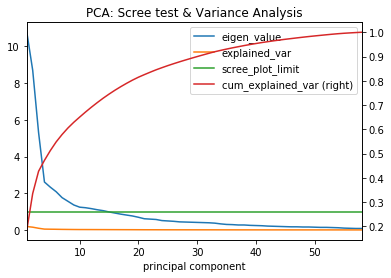

In [424]:
# Investigate the variance accounted for by each principal component.
def scree_pca(pca, plot=False, **kwargs):
    # PCA components
    n_pcs = len(pca.components_)
    pcs = pd.Index(range(1, n_pcs+1),  name='principal component')
    
    # Eigen Values
    eig = pca.explained_variance_.reshape(n_pcs, 1)
    eig_df = pd.DataFrame(np.round(eig, 2), columns=['eigen_value'], index=pcs)
    eig_df['cum_eigen_value'] = np.round(eig_df['eigen_value'].cumsum(), 2)
    
    # Explained Variance %
    var = pca.explained_variance_ratio_.reshape(n_pcs, 1)
    var_df = pd.DataFrame(np.round(var, 4), columns=['explained_var'], index=pcs)
    var_df['cum_explained_var'] = np.round(var_df['explained_var'].cumsum() / var_df['explained_var'].sum(), 4)

    df = pd.concat([eig_df, var_df], axis=1)
    
    if plot:
        # scree plot limit
        limit = pd.DataFrame(np.ones((n_pcs, 1)), columns=['scree_plot_limit'], index=pcs)
        ax = (pd.concat([df, limit], axis=1)
              .plot(y=['eigen_value', 'explained_var', 'scree_plot_limit'], 
                    title='PCA: Scree test & Variance Analysis', **kwargs)
             )
        df.plot(y=['cum_explained_var'], secondary_y=True, ax=ax)
    
    return df

scree_df = scree_pca(pca, plot=True)

In [425]:
# Re-apply PCA to the data while selecting for number of components to retain.
def get_pc_num(scree_df, pc_num = None, exp_var_threshold=None, eig_val_threshold=1):
    '''
    Selects optimum number of prinipal components according specified ojectives
    wheter % of explained variance or eig_val criterion
    
    Args:
        scree_df: Dataframe as ouptu of scree_pca function
        exp_var_threshold: threshold for cumulative % of epxlained variance
        eig_val_threshold: min eigen value, 1 by default
        
    Returns:
        pc_num: Number of selelected principal components
        exp_var: Explained variance by selected components
        sum_eig: Sum of eigen values of selected components
    '''
    # check arguments
    assert pc_num is None or pc_num <= scree_df.index.size
    assert exp_var_threshold is None or (0 < exp_var_threshold <= 1)
    assert 0 < eig_val_threshold < scree_df.index.size
    
    assert (pc_num is None or exp_var_threshold is not None) or \
           (pc_num is not None or exp_var_threshold is None), \
           'Either number of principal components or minimum variance explained should be selected'
    
    if exp_var_threshold:
        pcs = scree_df.index[var_df['cum_explained_var'] <= exp_var_threshold]
    
    elif pc_num:
        pcs = scree_df.index[range(1, pc_num+1)]
        
    elif exp_var_threshold is None:
        pcs = scree_df.index[var_df['eigen_value'] >= eig_val_threshold]
    
    pc_num = len(pcs)
    exp_var = scree_df.loc[pc_num, 'cum_explained_var']
    sum_eig = scree_df.loc[[*pcs], 'eigen_value'].sum()

    return pc_num, exp_var, sum_eig

pc_num, exp_var, sum_eig = get_pc_num(scree_df)

print('Suggestion to select {} components explaining {:.2f} % total variance and accounting for {:.0f} original variables.'
      .format(pc_num, exp_var * 100, sum_eig))

display(scree_df[:20])

Suggestion to select 14 components explaining 72.84 % total variance and accounting for 42 original variables.


eigen_value  cum_eigen_value  explained_var  \
principal component                                                
1                          10.77            10.77         0.1856   
2                           8.70            19.47         0.1500   
3                           5.31            24.78         0.0915   
4                           2.61            27.39         0.0450   
5                           2.33            29.72         0.0402   
6                           2.08            31.80         0.0359   
7                           1.76            33.56         0.0303   
8                           1.56            35.12         0.0269   
9                           1.36            36.48         0.0235   
10                          1.24            37.72         0.0214   
11                          1.21            38.93         0.0209   
12                          1.16            40.09         0.0199   
13                          1.10            41.19         0.0189   
14                          1.05            42.24         0.0181   
15                          0.98            43.22         0.0168   
16                          0.92            44.14         0.0159   
17                          0.86            45.00         0.0148   
18                          0.81            45.81         0.0139   
19                          0.76            46.57         0.0131   
20                          0.69            47.26         0.0119   

                     cum_explained_var  
principal component                     
1                               0.1857  
2                               0.3357  
3                               0.4273  
4                               0.4723  
5                               0.5125  
6                               0.5484  
7                               0.5787  
8                               0.6056  
9                               0.6292  
10                              0.6506  
11                              0.6715  
12                              0.6914  
13                              0.7103  
14                              0.7284  
15                              0.7452  
16                              0.7611  
17                              0.7759  
18                              0.7898  
19                              0.8029  
20                              0.8148

In [426]:
# refitted pca with selected number of components
n_components = 14
pca14, X_pca14 = do_pca(X_std, n_components=n_components)

### Discussion 2.2: Perform Dimensionality Reduction
Several criteria has been consered for components selection:
#### 1. Priori criterion
Information levels in Data_Dictionary suggest that min 9 components to consider around these dimensions:
 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level features
 7. RR1 neighborhood features
 8. PLZ8 macro-cell features
 9. Community-level features

9 components would be too few as they explain only 62% of total variance which is close to 60% limit in social science.

#### 2. Latent Root criterion
Considering component significant when their eigen value > 1 is appropriate for datasets with 20 and 50 features which is pretty close to 58 features. I selected 14 components explaining 72.84 % total variance and accounting for 42 original variables.

#### 3. Percentage of variance criterion
Trying to aim for 80% of explained variance add another 4 components (18 total) which is already pretty high and would make interpretation of factors more difficult

#### 4. Scree test criterion
Cut-off point of the scree test criterion seems to be at 10 components which is pretty close to priori information. This would explain 65% of total variance. Something to think about when more siplification is needed.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

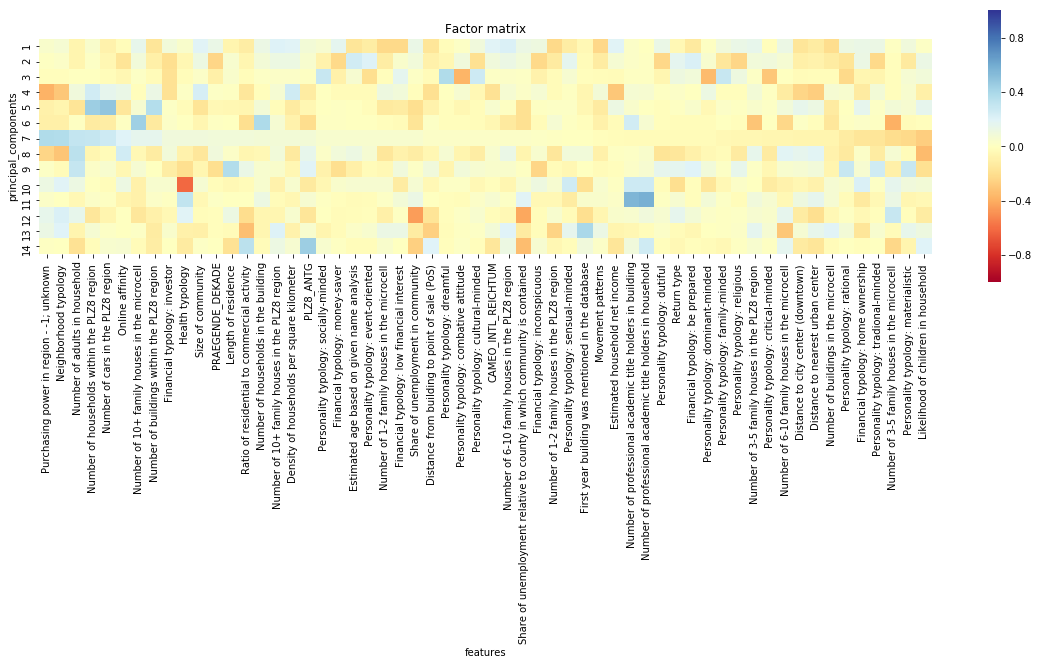

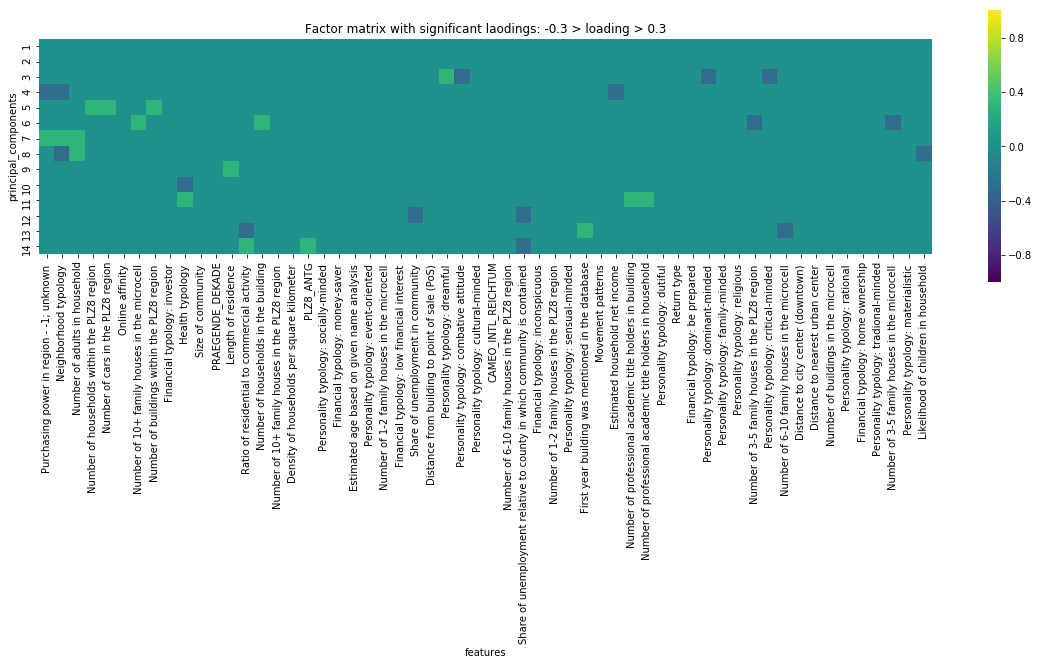

In [427]:
def varimax(factor_df, **kwargs):
    '''
    varimax rotation of factor matrix
    
    Args:
        factor_df: factor matrix as pd.DataFrame with shape (# features, # principal components)
    
    Return:
        rot_factor_df: rotated factor matrix as pd.DataFrame
    '''
    factor_mtr = df2mtr(factor_df)
    varimax = robjects.r['varimax']
    rot_factor_mtr = varimax(factor_mtr)
    return pandas2ri.ri2py(rot_factor_mtr.rx2('loadings'))

def get_components(df, pca, rotation=None, sort_by='sig_ld', feat_details=None, plot='None', **kwargs):
    '''
    Show significant factor loadings depending on sample size
    
    Args:
        df: data used for pca as pd.DataFrame
        pca: fitted pca object
        rotation: if to apply factor matrix rotation, by default None.
        sort_by: sort sequence of components, by default accoring number of significant loadings 'sig_load'
        feat_details: Dictionary of mapped feature detials, by default None 
        plot: 'discrete' plots heatmap enhancing sifinigicant laodings
              'continuous' plots continous heatmap,
              by default None
    
    Returns:
        factor_df: factor matrix as pd.DataFrame of shape (# features, # components) 
        sig_ld: number of significant loadings across components as pd. Series of size # components
        cross_ld: number of significant loadings across features (cross loadings)  as pd. Series of size # features
        
    '''
    # constants
    # ---------
    maxstr = 100    # amount of the characters to print
    
    # guidelines for indentifying significant factor loadings based on sample size
    # source: Multivariate Data Analysis. 7th Edition.
    factor_ld = np.linspace(0.3, 0.75, 10)
    signif_sz = np.array([350, 250, 200, 150, 120, 100, 85, 70, 60, 50])
    
    # loadings significant treshold
    ld_sig = factor_ld[len(factor_ld) - (signif_sz <= df.index.size).sum()]
    
    if rotation == 'varimax':
        components = varimax(pd.DataFrame(pca.components_.T))
    else:
        components = pca.components_.T
    
    # annotate factor matrix
    index = pd.Index([])
    for feat in df.columns:
        try: 
            index = index.append(
                pd.Index([feat]) if feat_details is None else \
                pd.Index([feat_details[feat]['long_name'][:maxstr]]))
        except KeyError:
            index = index.append(pd.Index([feat]))
        
    factor_df = pd.DataFrame(
        np.round(components, 2),
        columns = pd.Index(range(1, components.shape[1]+1), name='principal_components'),
        index = index.rename('features')
    )   
    
    # select significant loadings
    sig_mask = (factor_df.abs() >= ld_sig)
    
    # calculate cross loadings
    cross_ld = sig_mask.sum(axis=1).sort_values(ascending=False).rename('cross_loadings')
    
    # calculate number of significant loadings per component
    sig_ld = sig_mask.sum().sort_values(ascending=False).rename('significant_loadings')

    # sort vactor matrix by loadings in components
    sort_by = [*sig_ld.index] if sort_by == 'sig_ld' else sort_by
    factor_df.sort_values(sort_by, ascending=False, inplace=True)

    if plot == 'continuous':
        plt.figure(**kwargs)
        sns.heatmap(
            factor_df.sort_values(sort_by, ascending=False).T, 
            cmap='RdYlBu', vmin=-1, vmax=1, square=True
        )
        plt.title('Factor matrix')
    
    elif plot == 'discrete':
        # loadings limits
        ld_min, ld_sig_low, ld_sig_high, ld_max = -1, -ld_sig, ld_sig, 1
        vmin, vmax = ld_min, ld_max
        
        # create descrete scale to distingish sifnificant diffrence categories
        data = factor_df.apply(
            lambda col: pd.to_numeric(pd.cut(col, [ld_min, -ld_sig, ld_sig, ld_max], labels=[-ld_sig, 0, ld_sig])))
        
        # plot heat map
        fig = plt.figure(**kwargs)
        sns.heatmap(data.T, cmap='viridis', vmin=vmin, vmax=vmax, square=True)
        plt.title('Factor matrix with significant laodings: {} > loading > {}'
                 .format(-ld_sig, ld_sig));
    
    return factor_df, sig_ld, cross_ld

# investigate factor solution with 14 components
factor_df, sign_ld, cross_ld = get_components(X, pca14, feat_details=feat_details, figsize=(20, 5), plot='continuous')
factor_df, sign_ld, cross_ld = get_components(X, pca14, feat_details=feat_details, figsize=(20, 5), plot='discrete')

In [428]:
# display number of significant laodings per component
display(sign_ld)

# display cross loadings
display(cross_ld[cross_ld > 1])

principal_components
7     4
6     4
3     4
14    3
13    3
11    3
8     3
5     3
4     3
12    2
9     2
10    1
2     0
1     0
Name: significant_loadings, dtype: int64

features
Neighborhood typology                                                        3
Number of adults in household                                                3
Health typology                                                              2
Share of unemployment relative to county in which community is contained     2
Ratio of residential to commercial activity                                  2
Number of households within the PLZ8 region                                  2
Purchasing power in region - -1; unknown                                     2
Name: cross_loadings, dtype: int64

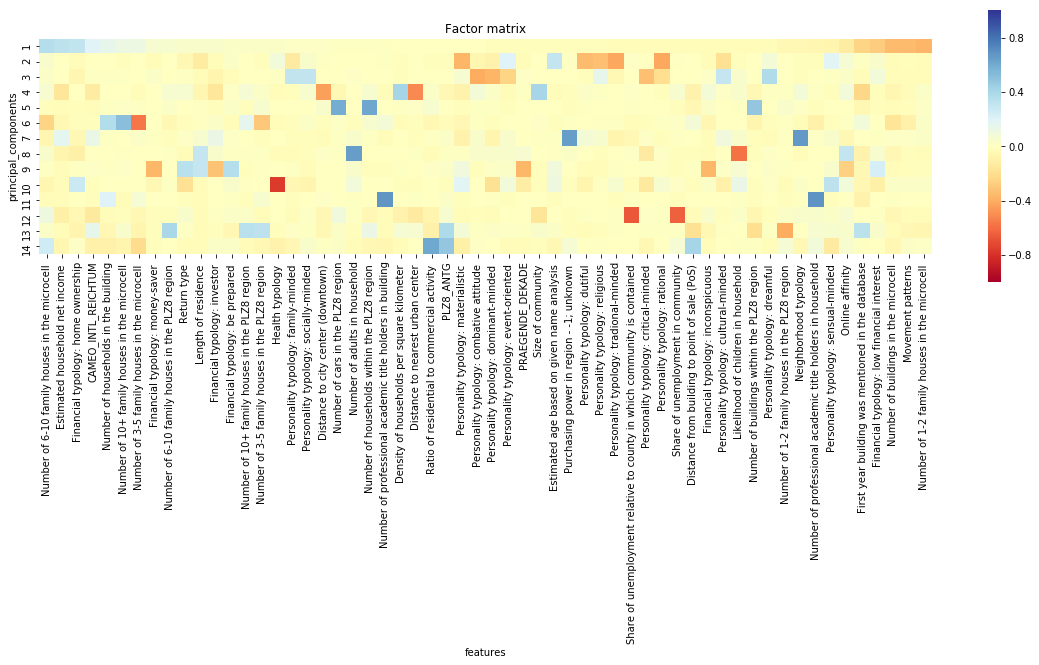

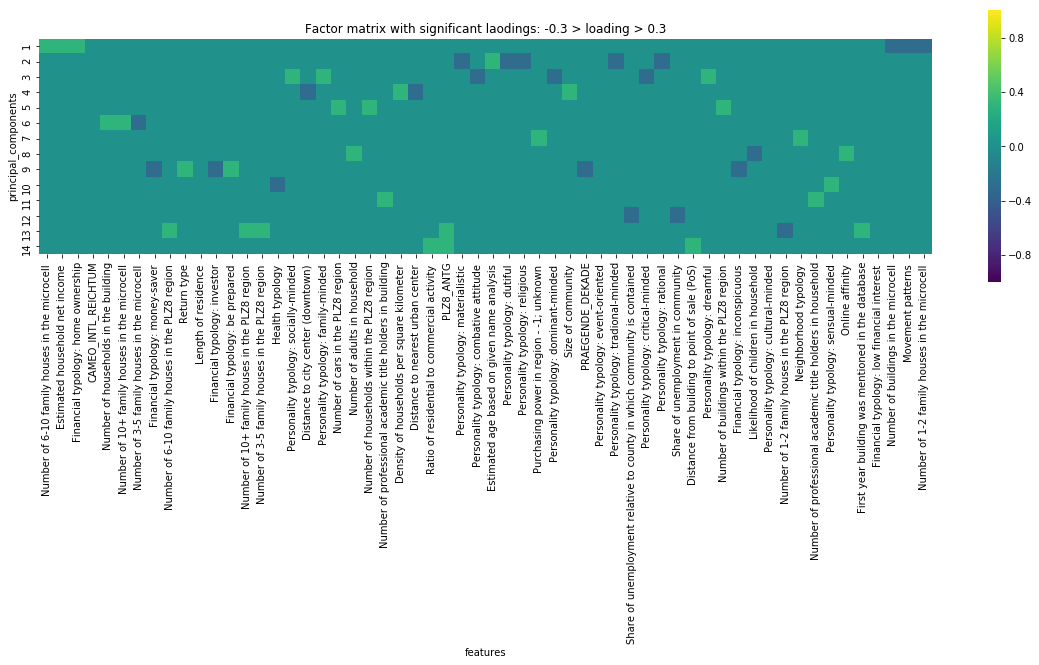

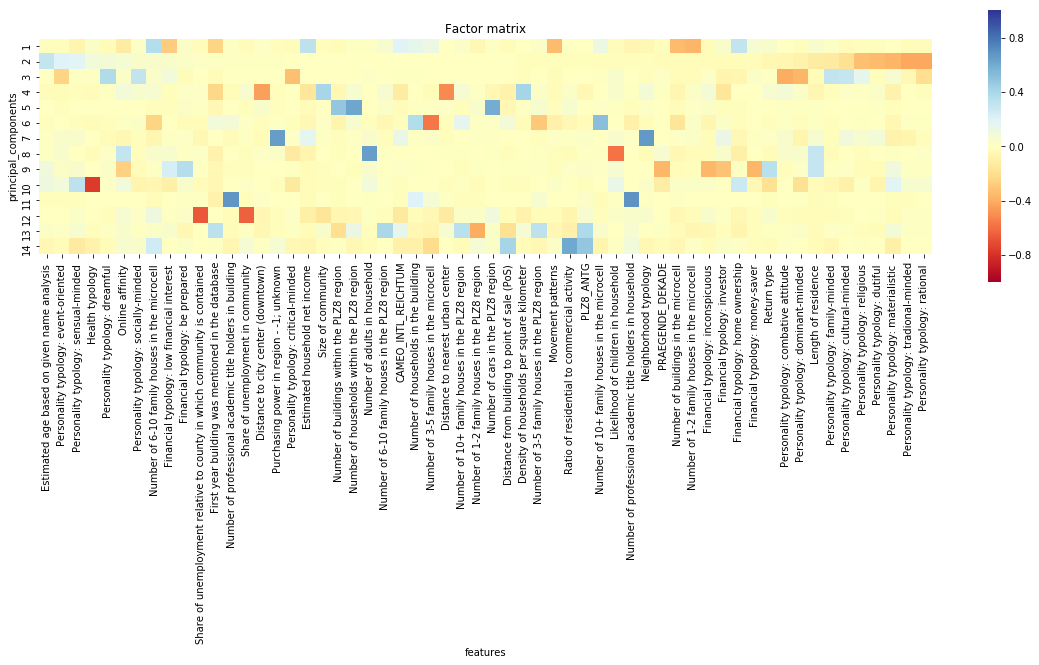

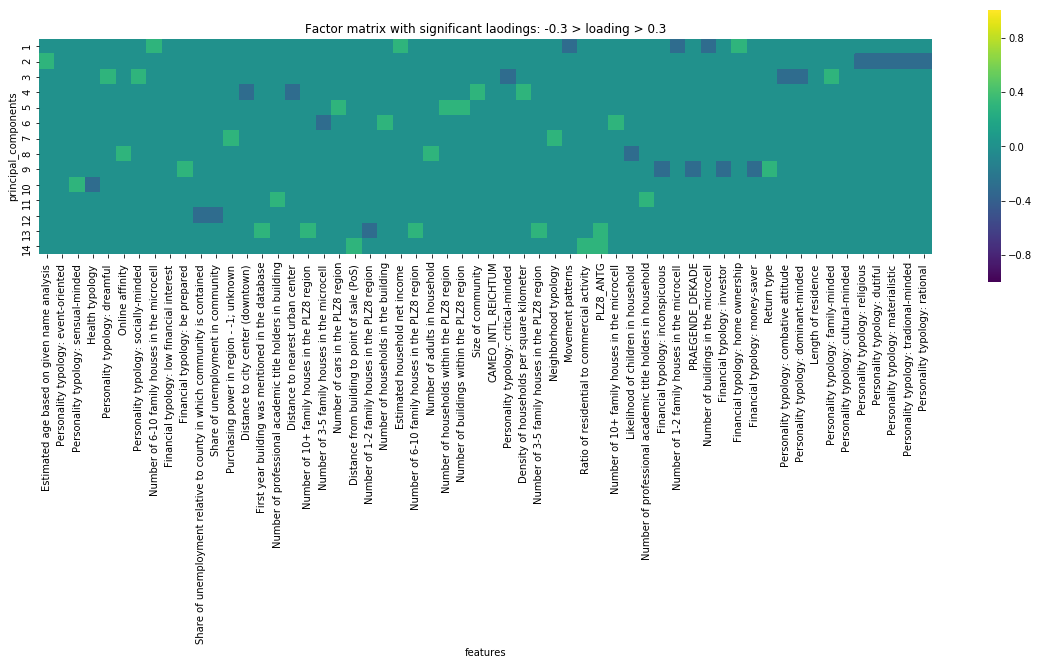

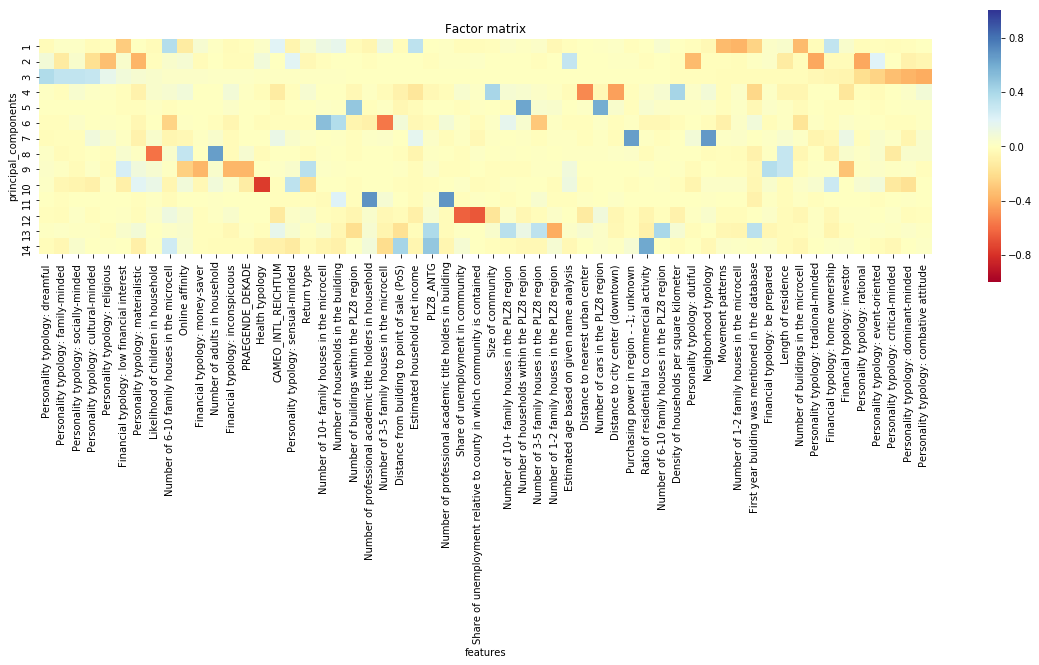

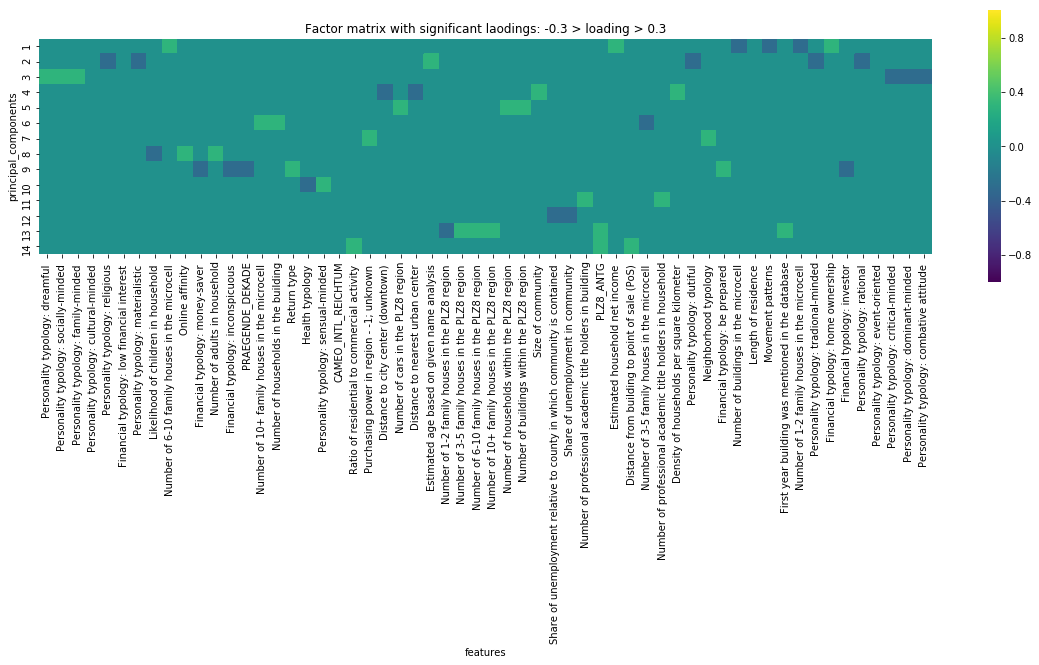

In [429]:
# use varimax rotation to investiage 1st 3 components
for component in [1, 2, 3]:
    rot_factor_df, rot_sign_ld, rot_cross_ld = get_components(
        X, pca14, rotation='varimax', feat_details=feat_details, sort_by=[component], plot='continuous', figsize=(20, 5))
    rot_factor_df, rot_sign_ld, rot_cross_ld = get_components(
        X, pca14, rotation='varimax', feat_details=feat_details, sort_by=[component], plot='discrete', figsize=(20, 5))

In [430]:
# display number of significant laodings for rotated factor matrix
display(rot_sign_ld)

# display cross loadings for rotated factor matrix
display(rot_cross_ld[rot_cross_ld > 1])

principal_components
9     7
3     7
13    6
2     6
1     6
8     4
4     4
14    3
6     3
5     3
12    2
11    2
10    2
7     2
Name: significant_loadings, dtype: int64

features
PLZ8_ANTG               2
Length of residence     2
Name: cross_loadings, dtype: int64

### Discussion 2.3: Interpret Principal Components
Unrotated factor loading matrix does not reveal underlying structure in data. First principal component does not have significant loading at all. 3 components have <2 significant loadings. 8 features have significant loadings across 2-3 factors (cross loadings) factors. 

To get better interpretability of factors varimax rotation has been used. The factor matrix represents much better structure in the data in meanigful way. No components have <2 significant laodings. Only 2 features have cross loadings over 2 factors. 

#### Principal component # 1

__Residentiality__ as characteristic of land used in which family houses dominates, as opposed to industrial or commercial areas. 
High residentiality is represented by higher number of family houses in microcell, high likehlihood of home ownership, higher household income and low movement patterns and low number of other buildings in microcell.

significant loadings +
- Number of 6-10 family houses in microcell
- Financial Typology: home ownership
- Estimated household net income

significant loadings -
- Number of 1-2 family houses in microcell
- Movement patterns
- Number of buildings in microcell

#### Principal component # 2

__Conservatist__ as older people with high afinity to be rational, tranditional minded, materialistic and dutiful.

significant loadings +
- Estimated age based on given name analysis (can be neglected as it is bordeline with sifnificance)

significant loadings -
- Personality typology: rational
- Personality typology: tranditional minded
- Personality typology: materialistic
- Personality typology: dutiful

#### Principal component # 3

__Oportunist__ as dominant person with combative attitude, criticaly minded who takes advatage of opportinities as and when they arise, regardless of planning or principle.

significant loadings +
- Personal typology: dreamful
- Personal typology: socialy_minded
- Personal typology: family_minded

significant loadings -
- Personality typology: combative attitude
- Personality typology: dominant minded
- Personality typology: critical minded

Note: typology scales are reversed 1-highes, 9-lowest

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [431]:
# refit pca object to get rotated solution
rpca = clone(pca14).fit(X_std)

# not safe!!! used solely for calculation of scores of rotated factor solution
# transform method calculates correct scores as soon as whiten=False (see source code)
# other methods can/will produce misleadnig results with modified components_ attribute
# as there is no way to refit (recalculate eigen values, variances etc...) pca object 
# in respect of modified factor matrix (Note it should not be allowed for safety reasons)
rpca.components_ = rot_factor_df.T
X_rpca = rpca.transform(X_std)

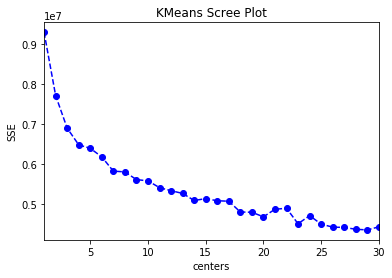

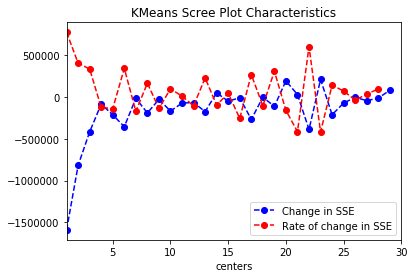

In [518]:
# Investigate the change in within-cluster distance across number of clusters.
def get_scree_char(scree_ser):
    '''
    Calculates scree function gradient and hesian
    
    Args: 
        scree_ser: Scree plot series of diffrent metrics (ex: SEE or eigen value, ...)
                   and parameter in index (ex: # of centers, # of components etc...)
    Returns:
        grad_ser: gradient series
        hes_ser: hesian series
    '''
    metric = scree_ser.values
    
    # calculate gradient
    grad = metric[1:]- metric[:-1]
    
    # calculate hesian
    hes = grad[1:] - grad[:-1]
    
    # get gradient and hesian series
    grad_ser = (pd.Series(grad, index=scree_ser.index[:-1], name='Change in {}'.format(scree_ser.name))
                  .reindex(scree_ser.index)
               )
    hes_ser = (pd.Series(hes, index=scree_ser.index[:-2], name='Rate of change in {}'.format(scree_ser.name))
                 .reindex(scree_ser.index)
              )
    return grad_ser, hes_ser

def get_kmeans_scores(X, center, **kwargs):
    # instantiate a model with k centers
    kmeans = MiniBatchKMeans(center)
    
    # fit model using fit method
    model = kmeans.fit(X)
    
    # get scores
    return np.abs(model.score(X))
    
def scree_kmeans(X, centers=5, plot=True, name='SSE', kmeans_args=dict(), **kwargs):
    '''
    Calculates kmean scores for diffrent number of centers and plot scree kmeans plot.
    
    Args:
        X: data as pd.DataFrame of shape (# samples, # features)
        centers: int max number of centers or
                 array_like of centers to calculate scores for
        name: name of the score to optimize, by default 'SSE'
        plot: plots scree plot, True by default
    
    Returns:
        opt_par: optimal parameter value
        scree_ser: Series of scores
        grad_ser: Series of change of scores
        hes_ser: Series of rate of change of scores
        
    '''
    
    # Over a number of different cluster counts...
    scores = []
    centers = np.arange(1, centers+1) if isinstance(centers, int) else np.array(centers, dtype=int).sort()
    for center in tqdm_nt(centers):
        # get kmeans scores for center k
        scores.append(get_kmeans_scores(X, center, **kmeans_args))
    
    scree_ser = pd.Series(scores, index=pd.Index(centers, name='centers'), name=name) 
    
    # get gradient and hesian
    grad_ser, hes_ser = get_scree_char(scree_ser)
    
    if plot:
        kwargs['title'] = 'KMeans Scree Plot'
        scree_ser.plot(**kwargs)
        plt.ylabel(scree_ser.name)
        
        if plot == 'verbose':
            # plot gradient and hessian of the scree plot
            scree_df = pd.concat([grad_ser, hes_ser], axis=1)
            kwargs['title'] = 'KMeans Scree Plot Characteristics'
            kwargs['color'] = ['b', 'r']
            scree_df.plot(**kwargs)  
    
    return scree_ser, grad_ser, hes_ser
    
# plot kmeans scree plot
centers = 30
scree_ser, grad_ser, hes_ser = scree_kmeans(X_rpca, centers=centers, kmeans_args={'n_jobs':-1, 'random_state': 1}, 
                                            plot='verbose', linestyle='--', marker='o', color='b')

# save scree plot data
with pd.HDFStore('temp_data.h5') as store:
    store['scree_mb_kmeans'] = scree_ser

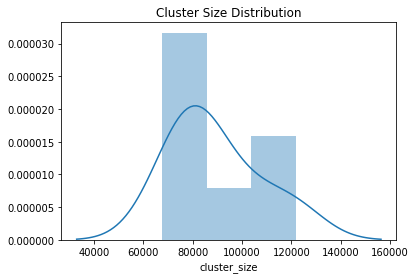

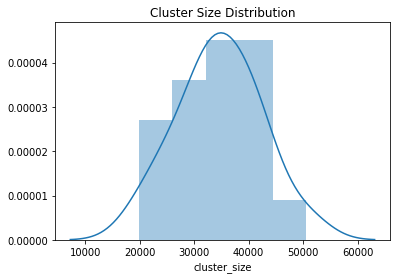

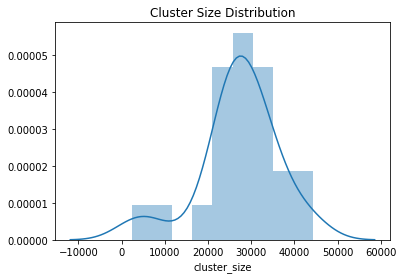

In [545]:
def get_cluster_size(X, plot=False, **kwargs):
    kmeans = MiniBatchKMeans(**kwargs)
    y_pred = kmeans.fit_predict(X)
    y_pred = pd.Series(y_pred, name='cluster')
    y_size = y_pred.groupby(y_pred).size()
    y_size.name = 'cluster_size'
    if plot:
        sns.distplot(y_size)
        plt.title('Cluster Size Distribution')
    return y_size

centers = [7, 18, 23]
for i, n_clusters in enumerate(centers):
    plt.figure(i),
    cluster_size = get_cluster_size(X_rpca, plot=True, n_clusters=n_clusters, random_state=1) 

In [546]:
cluster_size.sort_values().head()

cluster
20     2426
4      7305
12    18686
18    22844
5     23605
Name: cluster_size, dtype: int64

In [571]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_clusters = 18
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=1).fit(X_rpca)
y_pred = kmeans.predict(X_rpca)

# create dataframe with principal components and clusters
columns = pd.Index(
    ['PC_{}'.format(str(i)) for i in range(1, X_rpca.shape[1]+1)], 
    name='principal components')

azdias_cluster = pd.DataFrame( np.round(X_rpca, 4), index=X.index, columns=columns)
azdias_cluster.insert(loc=0, column='cluster', value=y_pred)
azdias_cluster.head()

principal components  cluster    PC_1    PC_2    PC_3    PC_4    PC_5    PC_6  \
1                          14 -0.8484 -0.7464 -1.4866 -2.2175 -0.9587 -1.8960   
2                           0  0.1649 -0.2382 -0.3014 -0.3332  0.2274 -0.0344   
4                           0 -1.3153  0.9471 -0.4579  1.0056  1.3064  0.5181   
5                          14 -0.0476 -0.9422 -0.3985  0.1849  0.3312 -2.6153   
6                          14  0.9616 -1.0948 -0.3863 -0.4474  0.3420  0.0493   

principal components    PC_7    PC_8    PC_9   PC_10   PC_11   PC_12   PC_13  \
1                     1.0453 -0.9893  0.6386 -0.0959  1.1109  0.5340 -0.0858   
2                    -0.9723 -0.9133  0.7928  1.1336  0.0820 -1.4461  0.6583   
4                     0.7099  0.0922 -0.2419  0.1652  0.4967 -0.7010  0.9355   
5                     0.2030 -0.0886  1.3787 -0.6137 -0.1330 -0.5545 -0.1606   
6                     0.8747  0.0820  0.5755 -0.3565  0.6510 -0.4708  0.0129   

principal components   PC_14  
1                    -2.3817  
2                     0.0982  
4                     0.7522  
5                    -0.5779  
6                     0.4501

### Discussion 3.1: Apply Clustering to General Population

The albow method suggest to have 3 clusters. When analyzing curve visually SSE smoothly decreases while number of centers increases. There is no really clear indication on number of clusters. There are several guidelines for selecting number of clusters
 - examine more closely SSE change and rate of SEE change
 - single member or extremely, small clusters are generaly not acceptable and should be eliminated
 - apply hierarchical methods ad hoc stopic rule, base on the rate of dchange in a total heterogeneity measure
 - apply other rules as gap statistic, the Silhouette Method, sum of squares method etc..
 - all clusters should be significantly diffrente across the set of clustering variables
 - cluster solutions ultimately must have theoretical validity assest trough external validation
 
As the main quastion of interest is to identify facets of the population that are most likely to be purchasers of company products for mailout campain, the number of clusters should be pretty high if general population database have around 9K samples (7K after deleting missing values).  

From the rate of SSE change plot we see that in 3 cases rate of SSE change is minimal. It means that in solutions with 7*,  18* and 23* centers have shown higher drop in SSE as their previous concurent solutions (6, 17, 22).

We can closely investigate these cases and select one solution based on distribution of cluster sizes. Best solution seems to be 17 clusters as it has not outliers in cluster sizes as opose to solution with 23 cases, where there are two outliers with small sizes. The solution with 7 classes is not sufficient in respect to priori information.

* As rate of SSE change is hessian we need to add +2 centers to minimal point when refering to particular solution

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [559]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

# EXPLORE DATA
# ------------
# customer data
display(customers.head(n=3))
display(customers.tail(n=3))
display(customers.info(verbose=False))

# summary of non numeric features
[print('{:15}: {}'.format(idx, val.unique())) for idx, val in customers.select_dtypes('O').iteritems()];

with pd.option_context('display.max_columns', None):
    display(customers.describe())

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2  ...         3.0         3.0   
1                      3                 2  ...         NaN         NaN   
2                      4                 4  ...         2.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0       5.0     1.0   
1         NaN         NaN          NaN       NaN       NaN     NaN   
2         3.0         1.0          3.0       3.0       2.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  
2          5.0       3.0  

[3 rows x 85 columns]

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
191649         2                     4          1            2.0   
191650         3                     3          2            4.0   
191651         3                     2          1            2.0   

        FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
191649                  5              1                 5               1   
191650                  2              1                 5               1   
191651                  5              1                 5               1   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
191649                      1                 2  ...         3.0         2.0   
191650                      2                 5  ...         3.0         2.0   
191651                      1                 2  ...         3.0         2.0   

        PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
191649         2.0         1.0          1.0       5.0       5.0     3.0   
191650         1.0         1.0          1.0       2.0       3.0     3.0   
191651         0.0         0.0          1.0       4.0       5.0     1.0   

        ORTSGR_KLS9  RELAT_AB  
191649          7.0       5.0  
191650          4.0       4.0  
191651          3.0       1.0  

[3 rows x 85 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 85 entries, AGER_TYP to RELAT_AB
dtypes: float64(49), int64(32), object(4)
memory usage: 124.3+ MB


None

OST_WEST_KZ    : ['W' nan 'O']
CAMEO_DEUG_2015: ['1' nan '5' '4' '7' '3' '9' '2' '6' '8' 'X']
CAMEO_DEU_2015 : ['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C'
 '5A' '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D'
 '6F' '4D' 'XX']
CAMEO_INTL_2015: ['13' nan '34' '24' '41' '23' '15' '55' '14' '22' '43' '51' '33' '25' '44'
 '54' '32' '12' '35' '31' '45' '52' 'XX']


AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  191652.000000         191652.000000  191652.000000  188439.000000   
mean        0.344359              3.060907       1.376432       3.677928   
std         1.391672              1.086254       0.484492       1.813975   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              3.000000       1.000000       2.000000   
50%         0.000000              3.000000       1.000000       4.000000   
75%         2.000000              4.000000       2.000000       6.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      191652.000000  191652.000000     191652.000000   191652.000000   
mean            3.963773       2.057051          4.183317        2.439808   
std             1.036230       1.319422          0.995365        1.697932   
min             1.000000       1.000000          1.000000        1.000000   
25%             3.000000       1.000000          3.000000        1.000000   
50%             4.000000       1.000000          5.000000        2.000000   
75%             5.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      FINANZTYP    GEBURTSJAHR  \
count          191652.000000     191652.000000  191652.000000  191652.000000   
mean                2.646176          2.781176       4.137958    1003.392733   
std                 1.586506          1.147353       1.503946     974.531081   
min                 1.000000          1.000000       1.000000       0.000000   
25%                 1.000000          2.000000       2.000000       0.000000   
50%                 2.000000          3.000000       4.000000    1926.000000   
75%                 5.000000          3.000000       5.000000    1949.000000   
max                 5.000000          5.000000       6.000000    2017.000000   

       GFK_URLAUBERTYP  GREEN_AVANTGARDE     HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
count    188439.000000     191652.000000  191652.000000        188439.000000   
mean          6.302268          0.367171       1.198396            18.181571   
std           2.877181          0.482035       1.450937            15.009985   
min           1.000000          0.000000      -1.000000             0.000000   
25%           5.000000          0.000000      -1.000000             0.000000   
50%           5.000000          0.000000       2.000000            16.000000   
75%           9.000000          1.000000       2.000000            36.000000   
max          12.000000          1.000000       3.000000            40.000000   

       LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
count        188439.000000    188439.000000    188439.000000   188439.000000   
mean              5.422694         4.254448         2.355043        6.687910   
std               4.717907         4.492807         2.052142        3.090573   
min               0.000000         0.000000         0.000000        1.000000   
25%               0.000000         0.000000         0.000000        5.000000   
50%               4.000000         2.000000         2.000000        7.000000   
75%              12.000000        10.000000         5.000000       10.000000   
max              12.000000        11.000000         5.000000       10.000000   

       LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  \
count   188439.000000     191652.000000          191652.000000   
mean         3.209251          0.773433               4.248273   
std          1.436958          0.495983               3.807671   
min          1.000000          0.000000               0.000000   
25%          2.000000          0.000000               0.000000   
50%          3.000000          1.000000               4.000000   
75%     

In [567]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# data preprocessing
# cleaned customer dataset with numeric variables and comlete cases
customers, _ = clean_data(customers, feat_info=feat_info, feat_details=feat_details, 
                                  keep_cat=False, dtypes=azdias_cln.dtypes, encode=False, impute='complete_cases')   

# unit test for equality of feature scales
print('Equality of datasets:', any(customers == azdias_cln_num_cc.dtypes))

Converting missing value codes...
Deleting features...
Engineering features...
Droping categorical features...
Getting complete cases...
Done!
Equality of datasets: True


In [574]:
# Apply feature scaling to the customer demographics data.
customers_std = scaler.transform(customers)

# calcuale scores
customers_rpca = rpca.transform(customers_std)

# predict clusters
customers_pred = kmeans.predict(customers_rpca)

# create dataframe with principal components and clusters
customers_cluster = pd.DataFrame( np.round(customers_rpca, 4), index=customers.index, columns=columns)
customers_cluster.insert(loc=0, column='cluster', value=customers_pred)
customers_cluster.head()

principal components  cluster    PC_1    PC_2    PC_3    PC_4    PC_5    PC_6  \
0                           7  0.0644 -0.7492  2.5529  1.2425  0.7363 -0.2262   
2                           4 -0.1048  0.1599  0.8272  0.5359 -1.3832  1.8992   
4                          14 -0.8055  0.4096  0.2174  0.5322  0.2811 -0.0856   
5                           5  0.0407 -0.9890  0.4304 -0.4877 -0.6102 -0.8598   
6                           7  1.1065 -0.5473  1.8265  0.9064  0.3519 -0.9593   

principal components    PC_7    PC_8    PC_9   PC_10   PC_11   PC_12   PC_13  \
0                    -1.4949  0.7168 -1.5912  0.8350 -0.2841  0.6858 -0.2361   
2                    -0.5516 -0.9086  1.0637  0.7271 -0.9045 -0.1433  0.0401   
4                     1.2426 -0.4555  0.3657 -1.1863 -0.9064 -1.1048  0.6775   
5                     0.0065 -0.3571 -0.4584  1.3031 -0.0917 -0.7890 -0.5601   
6                    -0.4720  0.6879  0.2722  0.2785 -0.1811  0.6476 -0.3426   

principal components   PC_14  
0                    -0.3793  
2                     1.0752  
4                    -0.1787  
5                    -0.3976  
6                    -0.3225

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

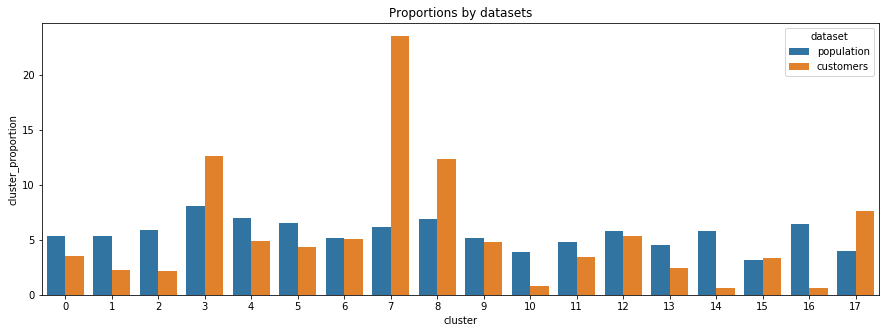

In [609]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
pop_cluster_prop = ((azdias_cluster.groupby(['cluster'])['cluster'].count() / azdias_cluster.index.size * 100)
                    .reset_index(name='cluster_proportion')
                   )
cus_cluster_prop = ((customers_cluster.groupby(['cluster'])['cluster'].count() / customers_cluster.index.size * 100)
                    .reset_index(name='cluster_proportion')
                   )
pop_cluster_prop['dataset'] = 'population'
cus_cluster_prop['dataset'] = 'customers'
cluster_prop = pd.concat([pop_cluster_prop, cus_cluster_prop], ignore_index=True)
pop_cluster_prop.head()
plt.figure(figsize=(15,5))
g = sns.barplot(x='cluster', y='cluster_proportion', hue='dataset', data=cluster_prop)
plt.title('Proportions by datasets');

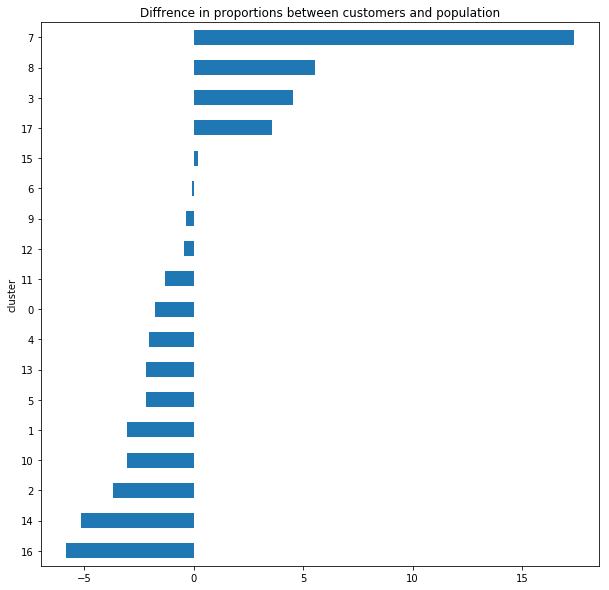

In [640]:
# compare diffrences between proportions
cluster_prop_diff = ((cus_cluster_prop.set_index('cluster')['cluster_proportion'] - \
                      pop_cluster_prop.set_index('cluster')['cluster_proportion'])
                     .sort_values()
                    )
plt.figure(figsize=(10, 10))
plt.title('Diffrence in proportions between customers and population')
cluster_prop_diff.plot.barh();

<Figure size 1440x1440 with 0 Axes>

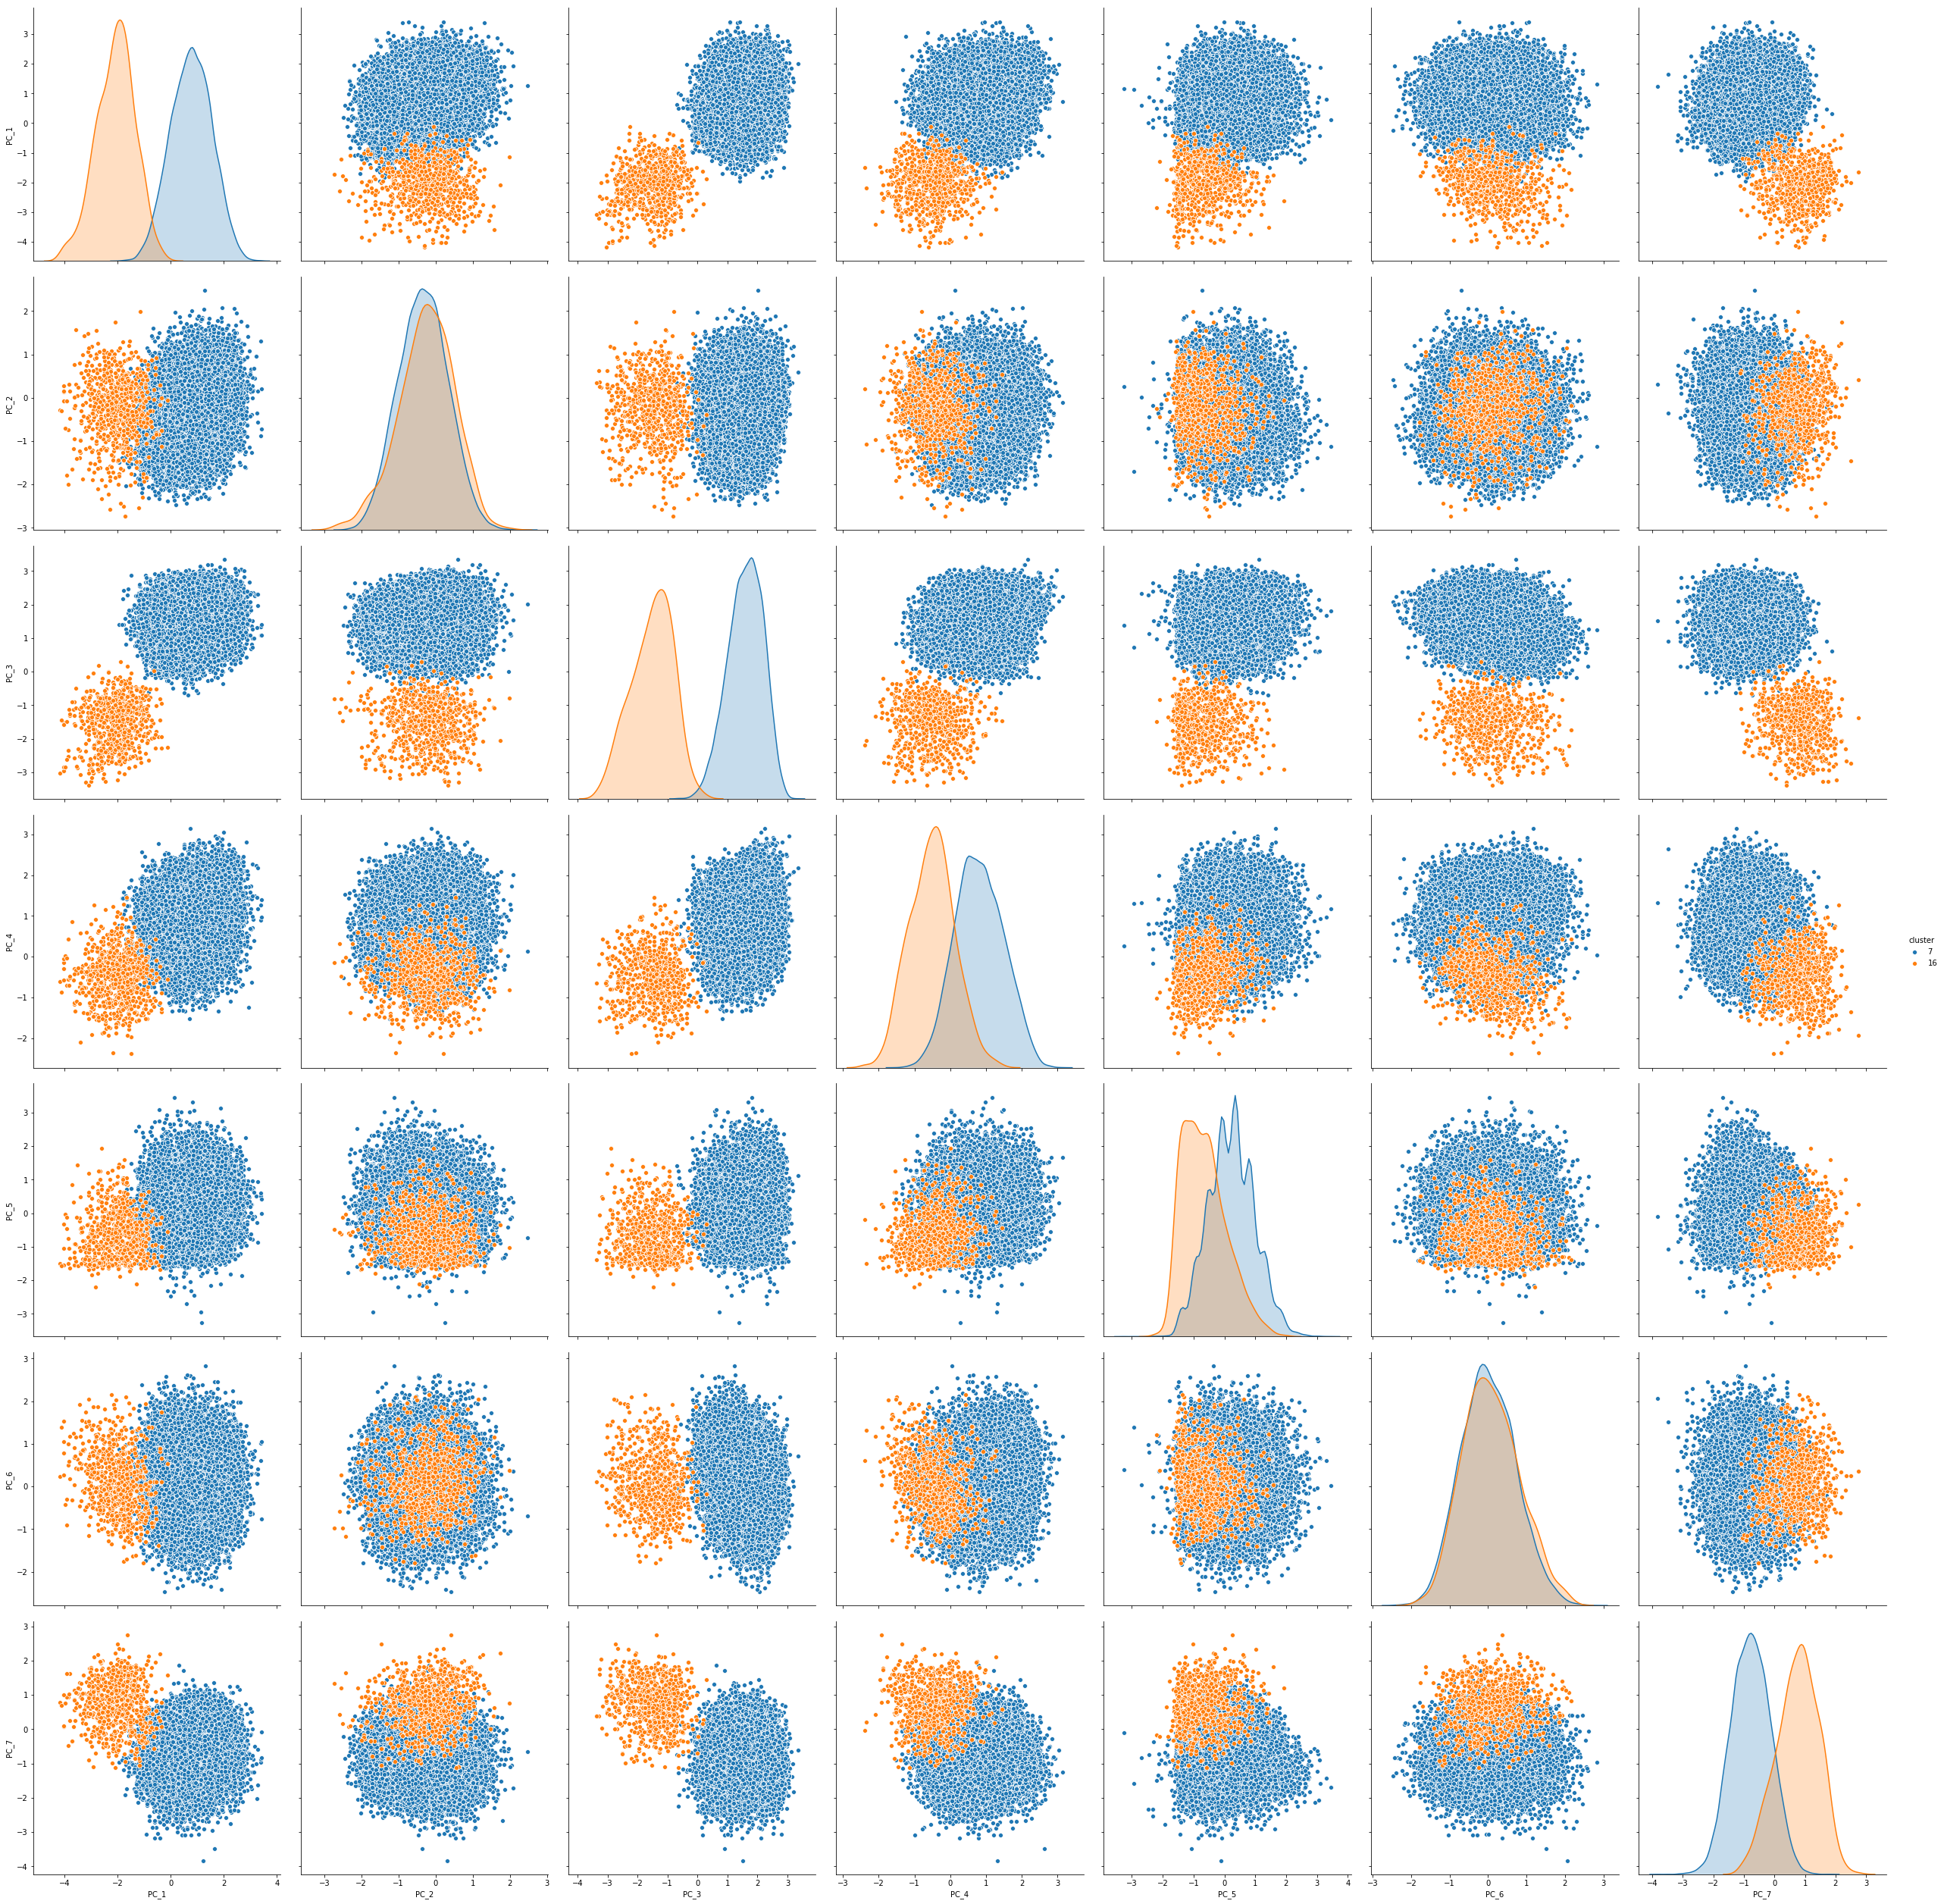

In [639]:
# What kinds of people are part of a cluster that is underpresented and overrepresented in the
# customer data compared to the general population?
inspect_clusters = customers_cluster.loc[(customers_cluster['cluster']==16) | (customers_cluster['cluster']==7)]
plt.figure(figsize=(20, 20))
g = sns.pairplot(inspect_clusters, vars=columns[:7], hue='cluster', height=5);

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Cluster 7 is overepresented and 16  underpresented in customer based compared to overal population. 

#### Interpretation overpresented cluster 7 
- postive scores on PC1: 
- postive scores on PC3: 

Dominant group of customers are those who live in residential areas with 6-10 family houses in microcell, do not move often, are home owners, opportunist with combative attitude, dominant and critical minded.

#### Interpretation of underpresented cluster 16
- postive scores on PC1:
- postive scores on PC3:

Missing group of customers are those who live in non-residential areas with max 1-2 family houses in microcell, moving often, dreamful, socially and family minded. 

We need to watch out as such a similar group 'artist' characterized as moving often, dreamfull and socially minded has been removed from population dataset (at least some proportion) due to missing values. This may flatten the propotion of cluster 16 in population and create bias in proprion diffrences between customers and population. The right approach would be to impute these data by hot deck method and run analysis again.

Note: Interpretation to original feature space is not done due to follwing reasons:
 - clusters are more distict in principle component space
 - I have used varimax rotation for better prepresentation of factors and had to altered `compontents_` attribute of This has altered `pca` object and inverse_transfom method would not work correclty.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.